<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/quantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="blue">**Quantum 🦋**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0000.png)


Video Course: [PHY361 Quantum Mechanics:
Spin And Discrete Systems](https://youtube.com/playlist?list=PLIKpuUo6d5pLdaGlx355xdH_RCZXRuWLK&si=2U2Uixe14tr1hIMm)

##### <font color="blue">*Quantum Mechanics*

###### *Expectation Value*

In [ ]:
!pip install pennylane -q

In [ ]:
import pennylane as qml
import numpy as np

# Define the number of qubits and the quantum device
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# Define an observable (this is Q in your equation)
obs = qml.Hermitian(np.array([[1, 0], [0, -1]]), wires=0)

# Define a quantum state (this is |ψ⟩ in your equation)
@qml.qnode(dev)
def circuit():
    qml.RY(np.pi / 4, wires=0)  # Example state preparation (rotation)
    return qml.state()  # Returning the state vector |ψ⟩

# Retrieve the quantum state
state = circuit()

# Calculate the expectation value of the observable
@qml.qnode(dev)
def expectation_value():
    qml.RY(np.pi / 4, wires=0)  # Same state preparation as before
    return qml.expval(obs)  # Calculate the expectation value of Q

exp_val = expectation_value()

# Print the results
print(f"Quantum State: {state}")
print(f"Expectation Value of the observable: {exp_val}")

Quantum State: [0.92387953+0.j 0.        +0.j 0.38268343+0.j 0.        +0.j]
Expectation Value of the observable: 0.7071067811865475


The expectation value of $0.7071067811865475$ corresponds to the observable $Q$ in a specific quantum state.

Observable $Q$ (Pauli-Z or Hermitian matrix)
In the example, you have an observable defined as:

$$
Q = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

This matrix is the Pauli-Z operator, which has eigenvalues $+1$ and $-1$.

State $|\psi\rangle$
The quantum state is prepared using the rotation $RY(\theta)$ gate:

$$
|\psi\rangle = RY\left(\frac{\pi}{4}\right) |0\rangle
$$

The $RY(\theta)$ gate rotates the qubit state around the Y-axis of the Bloch sphere. Specifically, when $\theta = \frac{\pi}{4}$, the state $|\psi\rangle$ becomes:

$$
|\psi\rangle = \cos\left(\frac{\pi}{8}\right) |0\rangle + \sin\left(\frac{\pi}{8}\right) |1\rangle
$$

Numerically, this is:

$$
|\psi\rangle = \cos\left(22.5^\circ\right) |0\rangle + \sin\left(22.5^\circ\right) |1\rangle \approx 0.9239 |0\rangle + 0.3827 |1\rangle
$$

Expectation Value Calculation

The expectation value of an observable $Q$ in a quantum state $|\psi\rangle$ is given by:

$$
\langle Q \rangle_\psi = \langle \psi | Q | \psi \rangle
$$

Substitute $|\psi\rangle$:

$$
\langle Q \rangle_\psi = \left(0.9239^* \langle 0| + 0.3827^* \langle 1|\right) \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} \left( 0.9239 |0\rangle + 0.3827 |1\rangle \right)
$$

Simplifying:

$$
\langle Q \rangle_\psi = 0.9239^2 \cdot 1 + 0.3827^2 \cdot (-1)
$$

This becomes:

$$
\langle Q \rangle_\psi = (0.9239)^2 - (0.3827)^2 = 0.8536 - 0.1464 = 0.7071
$$

The expectation value of the observable $Q$ is $0.7071$ because it depends on the overlap between the eigenstates of the Pauli-Z matrix (the computational basis states $|0\rangle$ and $|1\rangle$) and the rotated state $|\psi\rangle$. The specific angle $\pi/4$ for the rotation gate produces a superposition state that results in this non-trivial expectation value.

In [ ]:
!pip install qutip -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 21.5 MB/s eta 0:00:00


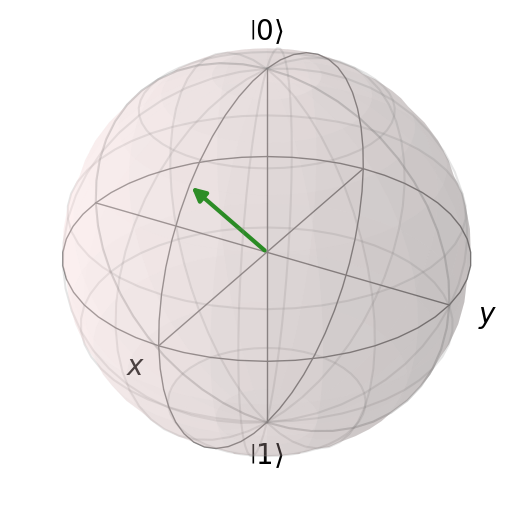

In [ ]:
import pennylane as qml
import numpy as np
from qutip import Bloch

# Define the quantum device with one qubit
dev = qml.device("default.qubit", wires=1)

# Define the quantum circuit
@qml.qnode(dev)
def circuit():
    qml.RY(np.pi / 4, wires=0)  # Apply a rotation gate to prepare a state
    return qml.state()

# Get the quantum state (|ψ⟩)
state = circuit()

# Calculate Bloch sphere coordinates
def bloch_coords(state):
    # Expectation values of Pauli-X, Pauli-Y, Pauli-Z
    x = 2 * np.real(state[0] * np.conj(state[1]))
    y = 2 * np.imag(state[0] * np.conj(state[1]))
    z = np.abs(state[0])**2 - np.abs(state[1])**2
    return [x, y, z]

# Get the Bloch sphere coordinates from the state
coords = bloch_coords(state)

# Create a Bloch sphere and add the state vector
b = Bloch()
b.add_vectors(coords)
b.show()

###### *Book Notes*

\newpage
\subsection{Quantum Information Theory}
\label{sec:quantuminformation}


\subsubsection{Quantum States}
\label{sec:quantum_states}

Quantum mechanics uses the Dirac notation, also known as "bra-ket",  introduced by Paul Dirac in the 1930s. This notation is a standard and efficient way of representing quantum states and operations, and is essential for understanding quantum computing.

\textbf{Hilbert spaces} are a crucial mathematical concept in quantum mechanics, providing the framework to describe systems with infinitely-many possible states and the operations performed upon them. Hilbert spaces allow for the description of quantum systems that can exist in superpositions, which often involve infinitely many possible states, unlike classical systems with their finitely-limited possibilities. Importantly, Hilbert spaces possess properties crucial for quantum mechanics: inner products allow us to calculate the probability of finding a system in a particular state, as well as expectation values of observables (like position or momentum). Completeness ensures that any valid quantum state can be represented within the Hilbert space and described by its mathematical framework. With these properties, Hilbert spaces provide the mathematical foundation to rigorously model quantum states and their evolution.

\textbf{Quantum states} encapsulate all the physically measurable information about a quantum system and probabilities related to its potential measurement outcomes. One way to describe a quantum state is the \textbf{wave function}, symbolized by the Greek letter $\psi$. It's a complex-valued function that encapsulates all conceivable information about a quantum system. This information is probabilistic rather than deterministic, marking a departure from classical mechanics by not specifying exact positions or momenta. Instead, it offers the probability densities for locating a particle in various positions or states of motion, with the square of the wavefunction's magnitude ($|\psi|^2$) representing the likelihood of finding the particle at a specific point in space and time.

\begin{figure}[H]
    \centering
    \includegraphics[width=0.6\linewidth]{figs/collapse.jpeg}
    \caption{The collapse of the wavefunction upon measurement}
    \label{fig:collapse}
\end{figure}

Wavefunctions embody the principle of superposition, blending all potential states a system might inhabit. Through this, it communicates possible quantum states, observables (like position, momentum, and energy), and how these states evolve over time. To glean insights on observables, one applies corresponding mathematical operators to the wavefunction. Its temporal evolution is dictated by the Schrödinger equation, enabling predictions about the system's future behavior. However, the wavefunction itself isn't directly observable; we only infer its characteristics through the probability outcomes of measurements. In numerous quantum interpretations, the act of measurement forces the wavefunction to "collapse," narrowing the system down to a single possible state from the many it potentially occupied. This aspect of quantum mechanics, central yet subject to diverse interpretations, underscores the stark contrast between quantum and classical physics in conceptualizing reality.


Quantum states can exist in \textbf{superpositions} and become \textbf{entangled}. There are two main ways to represent quantum states. \textbf{Pure States} are represented by a ket-state $| \psi \rangle $, these describe systems where we know the exact superposition. \textbf{Mixed States} are represented by a density matrix $\rho$, these describe situations where there's uncertainty about the exact superposition a system is in.

A \textbf{pure state} $| \psi \rangle $ is an eigenstate of an observable, like spin up or spin down, meaning its measurement will always yield a specific value. It can be represented as a single ket vector $|\psi\rangle$. Kets are elements of a complex vector space called a Hilbert space, and they mathematically represent the system's wave function $\Psi$. A ket state is a vector whose elements represent the probability amplitudes associated with a quantum system's possible states. For example, a qubit in a superposition of its two basis states $|0\rangle$ and $|1\rangle$ can be represented by a general ket state $|\psi\rangle = \alpha |0\rangle + \beta |1\rangle$, where $\alpha$ and $\beta$ are complex numbers representing probability amplitudes that satisfy the normalization condition: $|\alpha|^2$ +  $|\beta|^2$ = 1. Suppose $|\psi\rangle$ is an n-dimensional complex vector. It can be written in column form in \eq{bra2} for the two states spin up and spin down. We have chosen a basis in such a way that the Pauli Z matrix is diagonal. Here are its basis vectors, the spin up with $|\psi_0\rangle$ in the z direction and the spin down with $|\psi_1\rangle$  direction, written as column vectors.


\begin{equation}\label{eq:bra2}|\psi_0\rangle =
|\uparrow \rangle=\left(\begin{array}{l}1 \\ 0\end{array}\right) \quad |\psi_1\rangle =|\downarrow \rangle=\left(\begin{array}{l}0 \\ 1\end{array}\right)
\end{equation}

A \textbf{mixed state} $\rho$ represents a quantum state when there is an unknown quantum system where you lack knowledge about the state, or decoherence due to hardware defects, or quantum systems that interact with the environment.  We need the concept of \textbf{density matrix} to represent mixed states. The density matrix $\rho$ contains all statistical information of a mixed state, such that it represents a statistical ensemble of several different possible states, rather than a single definite state. If a quantum system is in a state \( |\psi_i\rangle \) with probability \( p_i \), where \( \sum_i p_i = 1 \), the density matrix \( \rho \) of the mixed state is:

\begin{equation}\label{eq:densitymatrix}
\rho = \sum_i p_i |\psi_i\rangle\langle\psi_i|  = p_1 |\psi_1\rangle\langle\psi_1| + p_2 |\psi_2\rangle\langle\psi_2| \, ... + p_i |\psi_i\rangle\langle\psi_i|
\end{equation}

The \textbf{tensor product} $\otimes$, also called the Kronecker product, is used to combine quantum states. It is essential for representing both superposition and entanglement in quantum computing. The tensor product generates a new vector in a larger Hilbert space that contains all pairwise products of the elements, unlike the dot product, which collapses vectors into a scalar, representing the degree of their parallelism. For example, if we have two qubits such that one qubit is in state $|0\rangle$ and the second qubit is in state $|1\rangle$, their combined state is represented by \eq{tensorproduct}. This combined state can represent both superpositions of separable states and entangled states, which are crucial for quantum computation.

\begin{equation}\label{eq:tensorproduct}
|0\rangle \otimes|1\rangle=\left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}0 \\ 1\end{array}\right]=\left[\begin{array}{l}1 \otimes \left[\begin{array}{l}0 \\ 1\end{array}\right] \\
0 \otimes \left[\begin{array}{l}0 \\ 1\end{array}\right]\end{array}\right]=\left[\begin{array}{l}1 \otimes 0 \\ 1 \otimes 1 \\ 0 \otimes 0 \\ 0 \otimes 1\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]
\end{equation}

A \textbf{product state} is is a particular type of pure state $| \psi \rangle $. It describes the combination of multiple \textit{separate} quantum systems where the subsystems are not entangled and can be described independently. This means that there is a precisely defined state for each subsystem. The overall state can be expressed as a tensor product $\otimes$ of the states of its individual subsystems. For example, if you have two quantum systems A and B, and the state of A is represented by \(|\psi_A\rangle\) and the state of B is represented by \(|\psi_B\rangle\), then the product state of the composite system would be \(|\psi_A\rangle \otimes |\psi_B\rangle\). Not all quantum states are product states, since most quantum states involve entanglement. Product states are often used as initial states in quantum algorithms since they are relatively easy to prepare. Quantum operations and measurements then create more complex, entangled states.


\textbf{Quantum observables} $\mathcal{A}$ represent measurable properties of a quantum system, like position, momentum, or spin of a particle. The \textbf{Hamiltonian} $\mathcal{H}$ is an important observable representing the total energy of the system. Its lowest eigenvalue describes the ground state, the most stable configuration a quantum system naturally tends toward. \textbf{Quantum operators} $\hat{A}$ mathematically represented quantum observables, or transformations in the quantum state space. These operators are 'Hermitian' and have real eigenvalues, which correspond to the possible physical solutions of a measurement. For example the eigenvalues of the momentum operator correspond to the possible momenta, or for a spin that is inherently quantized, taking on discrete values.

When a quantum observable is measured, the system collapses into an eigenstate of that observable, yielding the corresponding eigenvalue as the measurement result. Eigenstates are descriptions of physical states in quantum systems. The probability of collapsing into a particular eigenstate upon measurement is determined by the inner product between the system's quantum state and the corresponding eigenvector of the observable. Operators can change the state of a qubit, entangle multiple qubits, or perform other quantum manipulations. There are \textbf{discrete operators}, like the spin, (angular) momentum, ladder and projection operator, and \textbf{continuous quantum operators}, like the position and momentum operator.

\textbf{Super-operators} are a type of operator that acts on other operators, rather than on state vectors. Examples are quantum channels, CPTP map and Kraus operator. Super-operators are important to \textit{describe the dynamics of quantum systems, particularly in the presence of noise or other forms of quantum decoherence}. \textbf{Quantum channels} are a type of superoperator that describes the evolution of a quantum state interacting with a noisy or decohering environment. Mathematically, quantum channels are linear maps between operators spaces with the additional properties of being completely positive and trace-preserving maps, the \textbf{CPTP maps} $\mathcal{E}$. CPTP maps can be represented as a superoperator acting on the density matrix $\rho$ of a quantum state. Quantum machine learning applications involve the use of quantum channels $\mathcal{E}$, such as learning the function \eq{cptp} or its final state, where $x$ is a classical input, such as a chemical in a reaction.

\begin{equation}\label{eq:cptp}
f(x)=\operatorname{tr}(O \mathcal{E}(|x\rangle\langle x|))
\end{equation}

\textbf{Kraus operators} provide a concrete way to represent quantum channels and describe \textit{discrete} time evolutions of quantum systems. Kraus operators are particularly useful for modeling noise in an open quantum system with effects that cannot be described by simple unitary evolution. \textit{Kraus's theorem} states that a linear map $\Lambda$ from the Hilbert space $\mathcal{H}$ to $\mathcal{G}$, denoted as $\Lambda: \mathcal{H} \rightarrow \mathcal{G}$ is CPTP if it can be expressed as the Kraus representation of the linear map $\Lambda$ given by \eq{kraus} where $\left\{K_\alpha\right\}$ are the Kraus operators.

\begin{equation}\label{eq:kraus}
\Lambda[\rho]=\sum_\alpha K_\alpha \rho K_\alpha^{\dagger},
\end{equation}

\textbf{Lindblad operators} are another type of quantum operators used to model the effects of a system's interaction with its environment, leading to dissipation and decoherence in an open quantum system. In contrast to Kraus operators, who are used for discrete cases, Lindblad operators are applied to continuous time evolution. The time evolution of the density matrix (representing the state of a quantum system) under environmental influences is governed by the Lindblad master equation \eq{lindblad}, where $H$ is the system's Hamiltonian that describes its internal energy, $L_{i}$ are Lindblad operators that represent different environmental interactions, and $\rho$ is the density matrix of the system. The Lindblad master equation is also CPTP.

\begin{equation}\label{eq:lindblad}
{\dot {\rho }}=- \frac{i}{\hbar} [H,\rho] + \sum _{i}^{}\gamma _{i}\left(L_{i}\rho L_{i}^{\dagger }-{\frac {1}{2}}\left\{L_{i}^{\dagger }L_{i},\rho \right\}\right)
\end{equation}

The Lindblad master equations can be derived from the evolution described by Kraus operators in a continuous-time limit. Essentially, you break down a continuous evolution into tiny time steps, each described by Kraus operators, and then take the limit as the time steps become infinitesimally small. Furthermore, Lindblad operators offer a way to model specific types of system-environment interactions that are common in open quantum systems (like dephasing, energy relaxation, etc.).


\subsubsection{Quantum Measurements}
\label{sec:quantum_measurements}

\textbf{Quantum measurement} is a fundamental tool for understanding and manipulating quantum systems. Measuring quantum systems is used to verify the presence of desired states, determine values of observables (like position, energy, or momentum, compare theoretical predictions with experimental outcomes, or reconstruct the full quantum state of a system through tomography.  There are different measurement techniques.

The \textit{Bra-ket} notation is used to calculate state similarity. \textit{Density matrices} are essential for calculating expectation values (average results of many measurements). \textit{Projective measurements} are a type of quantum measurement that collapse the wavefunction of a system into one of the eigenstates of the measured observable. This results in a measurement outcome that corresponds to one of the possible eigenvalues (outcomes) of that observable. \textit{POVMs} generalize measurements for situations where projective measurements are too restrictive. They allow for non-orthogonal outcomes that aren't strictly exclusive. \textit{Shadow tomography} is a technique that combines repeated measurements with classical machine learning to estimate the density matrix. Additionally there is the weak measurement, square root measurement, separable measurement, random clifford measurement, two-copy Bell basis measurement and more.


The \textit{Bra-Ket sandwich for State Overlap} is the simplest method for measuring quantum systems is the computing the similarity between two quantum states. This involves calculating their inner product, which is done using the \textbf{Bra-Ket} notation. A Bra $\langle \psi |$ is a row vector, specifically a special type of row vector used in quantum mechanics (a \textit{covector} or linear functional from the dual space $V^{*}$), and represents the conjugate transpose of a Ket $|\psi\rangle$. The conjugate transpose means taking the complex conjugate of each element in the original Ket $|\psi\rangle$: $\langle\psi| = \begin{pmatrix} a_1^* & a_2^* & \cdots & a_n^* \end{pmatrix}$.

\begin{equation}\label{eq:braket}
\langle\psi|\psi\rangle = \begin{pmatrix} a_1^* & a_2^* & \cdots & a_n^* \end{pmatrix} \begin{pmatrix} a_1 \\ a_2 \\ \vdots \\ a_n \end{pmatrix} = a_1^*a_1 + a_2^*a_2 + \cdots + a_n^*a_n = 1
\end{equation}

Combining a bra and a ket, such as $\langle\psi|\psi\rangle$ for identical states, or $\langle\phi|\psi\rangle$ for different states, creates a Bra-Ket, as denoted in \eq{braket} for a n-dimensional complex vector, where the quantum state vector is normalized, meaning:
$\langle\psi|\psi\rangle$ = 1. This forms an \textit{inner product}, which yields a scalar (a single number) that measures the similarity between quantum states. It can be either the 'self-overlap' of a quantum state $|\psi\rangle$ with itself $|\psi\rangle$, or the similarity between two different states $|\psi\rangle$ and $|\phi\rangle$. When the bra \(\langle \phi |\) and ket \(|\psi\rangle\) represent the same state, the bra-ket sandwich essentially calculates the inner product of the state with itself.

\begin{equation}\label{eq:braketsandwich}
\langle \phi | A | \psi\rangle
\end{equation}

The \textit{bra-ket sandwich} is an important key concept in quantum measurements and refers to a specific operation that is used to calculate the inner product and expectation values. It consists of three components: Bra, denoted as  \(\langle \phi | \), that represents the conjugate transpose (Hermitian adjoint) of a quantum state (ket). Ket, denoted as \( | \psi \rangle \), represents a quantum state itself. An operator $A$ that corresponds to the observable you want to measure and that is placed between the bra-ket \eq{braketsandwich}. In case of computing the similarity (overlap) between two quantum states, the operator would be the identity operator \(\langle \phi | I | \psi\rangle \). The identity operator is often omitted because it acts like a scalar 1 multiplying everything, but it is technically still implied. Practically, the Swap-test is used to determine the similarity, or overlap, between two quantum states \cite{10.1137/S0097539796302452, 10.1103/PhysRevLett.87.167902}.

\begin{equation}\label{eq:overlap}
|\langle \phi | \psi \rangle|^2
\end{equation}

Using Bra-Ket notation to calculate the probability of finding a quantum system in state \(|\phi\rangle\) if it was initially prepared in state \(|\psi\rangle\) is given by the squared magnitude of the inner product between the two states as denoted in \eq{overlap}. It is used to calculate the \textit{state overlap}, expressing the degree to which one quantum state lies 'within' another. It is a bra-ket sandwich with the identity operator $I$ implied in the middle.

\textit{Bra-Ket sandwich for Expectation Values of Pure States}: If we generalize the bra-ket sandwich from \eq{overlap} by placing a specific operator $P$, corresponding to a desired observable, within it, we can calculate the \textit{expectation value} of that operator in a specific quantum state $|\psi\rangle$. This \textbf{expectation value}, denoted as  \eq{expectationvalue}, represents the average value you would expect to obtain over many repeated measurements of the quantity associated with operator $P$, when the system is prepared in the state $|\psi\rangle$. For example, if $P$ represents the momentum operator, then $\langle \psi | P | \psi \rangle$ gives us the average momentum of a particle in state $|\psi\rangle$.

\begin{equation}\label{eq:expectationvalue}
\langle P \rangle = \langle \psi | P | \psi\rangle
\end{equation}

To calculate the expectation value of a projection operator $P_i$ in the state $|\phi \rangle$, we use the expression $\langle P_i \rangle = \langle \psi | P_i | \psi\rangle$. This calculates the probability of finding the system in the state that the projector $P_i$ projects onto. The operator $P_i$ is represented as a projection operator $P_i = |\phi \rangle \langle \phi|$, and the probability is calculated by $\langle\psi| \phi\rangle\langle\phi|\psi\rangle = |\langle \phi | \psi \rangle|^2$. The expectation value of a projection operator corresponds to this probability. In the specific case where $P_i$ projects into the state $|\phi \rangle$ itself, this expectation value will always be 1, because $\langle\phi| \phi\rangle\langle\phi|\phi\rangle = |\langle \phi | \phi \rangle|^2$. This reflects the certainty of finding the system in state $|\phi \rangle$ upon measurement if it is already prepared in that state.



\textit{Density Matrix Formulation for Expectation Values of Mixed States}: Now we want to expand to \textit{mixed states}. The expression \eq{expectationvalue} assumes the system is in a well-defined \textit{pure state} represented by the ket $|\psi\rangle$. Now we expand $\langle P \rangle = \langle \psi | P | \psi\rangle$ to include also \textit{mixed states}. A mixed state represents a statistical mixture of several possible pure states, each with a corresponding probability.

To calculate the expectation value in a mixed state, you need to use the \textbf{density matrix formulation}, where a mixed state is represented by a density matrix $\rho$. This is an operator that contains the probabilities of finding the system in various pure states. The density matrix \( \rho \)  is a weighted sum of outer products of state vectors \( |\psi_i\rangle \) with their corresponding dual vectors \( \langle\psi_i| \), where each weight \( p_i \) is the probability of the system being in the state \( |\psi_i\rangle \). The projection operator \( P_i \) projects any state onto a particular state \( |\phi\rangle \). It is defined as \( P_i = |\phi\rangle\langle\phi| \). The expectation value of an operator $P_i$ in a mixed state described by the density matrix \( \rho \) is calculated as $\langle P \rangle = \text{Tr}(\rho P_i)$, where Tr(...) is the trace of the matrix.


Expanding the density operator \( \rho \) as \( \sum_i p_i |\psi_i\rangle\langle\psi_i| \) and using the projection operator \( P_i = |\phi\rangle\langle\phi| \) becomes \eq{probabilitytrace}. It describes a quantum system that is in a probabilistic mixture of pure states $|\psi_i\rangle$, each with probability $p_i$. The trace is the sum of all Eigenvalues of an operator and corresponds to the possible measurement results of the observable that is represented by the operator. Now calculating the trace ($\text{Tr}$) of ($\rho P_i$) gives the total probability of finding the system in the state \( |\phi\rangle \) when you sum all states \( |\psi_i\rangle \) the system might be in, weighted by their respective probabilities \( p_i \), to get the average expectation value, denoted in \eq{probabilitytrace}.

\begin{equation}\label{eq:probabilitytrace}
\langle P \rangle = \text{Tr}(\rho P_i) = \text{Tr}\left(\sum_i p_i |\psi_i\rangle\langle\psi_i|\phi\rangle\langle\phi|\right)
\end{equation}

This means that the expression $\langle P \rangle = \langle\phi|P_i|\phi\rangle$ from the Bra-Ket sandwich in \eq{expectationvalue} is a specific instance of the more general density matrix formulation for expectation values for a particular \textit{pure state} $ |\phi\rangle$. If the projection operator $P_i$ is projected onto the state $|\phi\rangle$, then $P_i = |\phi\rangle\langle\phi|$, and the density matrix can be written simply as $\rho =  |\phi\rangle\langle\phi|$, which results in $\langle\phi| \phi\rangle\langle\phi|\phi\rangle = |\langle \phi | \phi \rangle|^2 = 1$ if you would use the density matrix formulation $\langle P \rangle = \text{Tr}(\rho P_i)$ for the a system in \textit{pure states}.

\( \text{Tr}(\rho P_i) \) from \eq{probabilitytrace} generalizes this concept to a \textit{mixed state} represented by the density matrix \( \rho \). The expectation value of mixed states is the trace of the product of the density matrix and the observable $\langle P \rangle = \text{Tr}(\rho P_i)$. The density matrix allows us to handle mixed states, but it reduces to the simple pure state form when the system is in a well-defined single state. In both cases \eq{expectationvalue} and \eq{probabilitytrace}, the focus is on calculating the probability of observing the system in a particular quantum state after a measurement.


\textit{Expectation Values of Observables under Unitary Transformations}: If you go a step further and want to measure the \textbf{expectation value} of an observable $B$, which undergoes a \textbf{(unitary) transformation $U(x)$}, you would use the expression \eq{expectedoutcome}. This often represents a single element within a larger parameterized quantum circuit. The value $(x)$ dictates the specific form of the unitary transformation, influencing the expectation value.

\begin{equation}\label{eq:expectedoutcome}
\langle B \rangle = \langle \psi | U^{\dagger}(x) B U(x) | \psi \rangle
\end{equation}

The system starts in state $|\psi \rangle$, and the unitary operator $U(x)$ transforms the state. The observable of interest, represented by the operator $B$, acts on the transformed state $U(x) |\psi \rangle$. The final step involves taking the expectation value of this transformed state with respect to the initial state $|\psi \rangle$. This is achieved by the \textit{bra-ket sandwich} and results in the expectation value $\langle B \rangle$ of the observable $B$ after the transformation. The bra-ket sandwich uses the reverse transformation $U^{\dagger}(x)$, which is the Hermitian adjoint (conjugate transpose) of $U(x)$.

How can equation \eq{expectedoutcome} be solved? There are two main approaches to calculating the eigenvalues of a Hermitian operator $B$: Either via \textit{Diagonalization}, which involves finding an orthonormal basis of eigenvectors of $B$. The eigenvalues of $B$ are then the corresponding eigenvalues of the Hermitian matrix representing $B$ in this basis. Or via \textit{Eigenvalue Solvers}, where there are various numerical methods for calculating eigenvalues of Hermitian operators, such as the Rayleigh-Ritz quotient, the Lanczos algorithm, and the Arnoldi algorithm. These methods can be used to calculate eigenvalues for large Hermitian matrices that cannot be diagonalized directly.

Since in $E(x) =\langle\psi| U^{\dagger}(x) B U(x) | \psi\rangle$, the observable $B$ is sandwiched between the unitary operator $U(x)$ and its conjugate transpose $U^{\dagger}(x)$, it means that $B$ can be expressed as a combination of powers of $U(x)$ and $U^{\dagger}(x)$. If we can find the eigenvalues of this combination of operators $U(x)$ and $U^{\dagger}(x)$, then we can calculate the eigenvalues of $E(x)$. The diagonalization method is accurate and but computational expensive. This involves finding a suitable basis for the Hilbert space of quantum states, and representing $U(x)$ and $U^{\dagger}(x)$ in this basis. The eigenvalues of $B$ can then be calculated by diagonalizing the matrix representing $B$ in this basis. On the other side, using an eigenvalue solver - efficient, but not super accurate. This involves choosing an appropriate numerical method, and applying it to the matrix representing B in the basis defined by $U(x)$ and $U^{\dagger}(x)$. The eigenvalues of $B$ can then be calculated by using the numerical method.

\begin{equation}\label{eq:unitarytransformation}
O' = U * O * U^{\dagger}
\end{equation}

When a quantum observable undergoes a unitary transformation, the mathematical expression describing \eq{unitarytransformation}, where $O'$ represents the observable after the unitary transformation.
$O$ represents the original observable.
$U$ is the unitary operator describing the transformation, and $U^{\dagger}$ denotes the Hermitian adjoint (complex conjugate transpose) of $U$. You may noticed that the dagger placement is reversed in comparison to \eq{expectedoutcome}. The dagger placement depends on whether you are transforming the observable itself or calculating the expectation value of a transformed observable. In both cases, the unitary transformation plays a crucial role in understanding how quantum systems evolve. If you are simply describing the transformation of a physical object (observable) in space, the dagger on the second $U$ in \eq{unitarytransformation} ensures that the object is rotated or stretched consistently. When calculating the expectation value, we are essentially taking an average over the transformed object using a specific probability distribution (the state vector). The dagger on the first U achieves the correct conjugation for this averaging process.

\begin{equation}\label{eq:expectedoutcome2}
\langle B \rangle = Tr(\rho U^{(\dagger)}(x) B U(x))
\end{equation}

To calculate expectation values in \textit{mixed states}, where the system is in a probabilistic combination of pure states, you need the density matrix ($\rho$) formalism as denoted in \eq{expectedoutcome2}. Tr represents the trace operation, which sums the diagonal elements of the resulting matrix after the transformation.


\textit{Bra-Ket sandwich for Projective Measurements}: Another application of the bra-ket sandwich is calculating measurement probabilities in quantum systems using \textbf{projective measurement}. Imagine we have a quantum system in an unknown state represented by the wavefunction $|\psi\rangle$.  Our goal is to measure a specific observable $\mathcal{O}$ and determine the probability of finding it in a particular eigenstate, $|\phi\rangle$. To do this, we use the \textbf{corresponding projection operator} $P = |\phi \rangle\langle \phi |$, represented using \textbf{Ket-Bra notation} (outer products), which corresponds to one of the possible outcomes of the measurement. This operator acts like a filter.  When applied to the unknown quantum state $|\psi\rangle$, it extracts the component of $|\psi\rangle$ that aligns with the subspace spanned by the eigenstate $|\phi\rangle$, denoted in \eq{projection}.

\begin{equation}\label{eq:projection}
P |\psi \rangle = |{\phi}\rangle \langle{\phi}|{\psi}\rangle
\end{equation}

This projection, $| \phi \rangle\langle \phi |\psi \rangle$, holds information about the part of the unknown state $|\psi\rangle$ that overlaps with $|\phi\rangle$. To extract the probability of finding the system in this state, we take the inner product of this projection with itself. This is where the Bra-Ket sandwich comes in. It lets us calculate the magnitude squared of the resulting vector after the projection, which is the probability of finding the system in that eigenstate. Importantly, the act of measurement also causes the quantum state to collapse into the measured eigenstate. This means that we take the $|\phi\rangle$ component of $|\psi\rangle$, project it again onto $|\phi\rangle$, and calculate the length squared of this resulting vector. This length squared is the probability of finding the system in the state $|\phi\rangle$ after the measurement, denoted in \eq{projectivemeasurement}, where $P_i$ is the projector for this outcome, which is  $|\phi \rangle\langle \phi |$.

\begin{equation}\label{eq:projectivemeasurement}
P({\phi}) = \langle{\phi} | {\phi}\rangle \langle{\phi}| {\psi}\rangle |{\phi}\rangle = |\langle{\phi}|{\psi}\rangle|^2    = \langle{\phi} | P_i |{\phi}\rangle
\end{equation}

For a system with multiple possible measurement outcomes, each associated with a different eigenstate $ |\phi_i\rangle$, the overall projection operator can be expressed as a sum of individual projection operators: $\sum_i |\phi_i\rangle\langle\phi_i|$, where the sum is over all possible outcomes.  A projective basis is a set of projectors $\{ P_i \}$ that span the space of quantum states and are used for calculating outcomes of quantum measurements. Each $P_i$ projects onto a different one-dimensional subspace, and they satisfy the completeness relation $\sum_i P_i = I$, where $I$ is the identity operator. This means any quantum state can be expressed as a combination of these projectors.

As an example, the equation \eq{projectivemeasurement2} represents the probability of a specific measurement outcome '$\phi$' when the system could collapse into multiple possible eigenstates. $P(\phi)$ is the probability of finding the system in eigenstate $|\phi \rangle$ after the measurement. $P_j$ is the projection operator specifically corresponding to the outcome $|\phi\rangle$, i.e., $P_i = |\phi\rangle \langle \phi|$. The summation $\sum_i |\phi_i\rangle \langle \phi_i|$ represents the decomposition of the total measurement operator into projectors onto each potential outcome state $|\phi_i \rangle$.  Isolating $P_j = |\phi\rangle \langle\phi|$ within the overall measurement ensures that we calculate the probability specifically for the outcome '$\phi$'. The right-hand side of the equation demonstrates how the total measurement operator can be expressed as a sum of projection operators, each corresponding to a possible outcome. By using the projector $P_j$, we select the component of the summation that specifically corresponds to the probability of the outcome '$\phi$'.

\begin{equation}\label{eq:projectivemeasurement2}
P(\phi) = \langle \phi|P_j|\phi\rangle = \langle \phi| \sum_i |\phi_i\rangle \langle \phi_i| \phi\rangle
\end{equation}

\textit{POVM (Positive Operator-Valued Measure)} is a more general framework for quantum measurements compared to projective measurements. It extends beyond the limitations of projective measurements, which are restricted to \textbf{orthogonal outcomes} and induce \textbf{state collapse}. POVMs allow for a wider range of measurement processes, including \textbf{non-orthogonal outcomes} and even those that cannot be described by simple state collapse. This makes them particularly useful in quantum information theory and for dealing with systems where you have partial or incomplete knowledge.

To obtain classical information from a quantum state represented by density matrix $\rho$, one can apply a POVM measurement. An $m$-outcome POVM is described by a set of positive semi-definite matrices $\left\{M_i\right\}_{i \in[m]}$, where $i$ iterates over the possible outcomes $i \in [m]$. These matrices satisfy the completeness relation $\sum_i M_i=\mathrm{Id}$ (identity). When measuring $\rho$ using this POVM, the probability of outcome $j$ is given by $\operatorname{Tr}\left(M_j \rho\right)$, where $Tr$ denotes the trace operation - essentially a sum over the diagonal elements of matrix $M_j$.  It's important to note that unlike projective measurements, some POVMs may not necessarily cause the system to collapse into a specific state after the measurement.

\textbf{Weak measurements} are a type of quantum measurement that partially collapse the quantum state, providing limited information while minimizing disturbance. This contrasts with strong measurements, which fully collapse the state.  Weak measurements are achieved by intentionally making the interaction between the system and the measuring device very weak. The measurement process transfers only a small amount of information from the system to the device, and the wave function of the quantum system is only slightly disturbed. This allows for extracting some information without significantly altering the system.

\begin{equation}\label{eq:weakmeasurement}
A_w = \frac{( \langle \phi_f | A |\psi_i \rangle )}{ ( \langle \phi_f | \psi_i \rangle )}
\end{equation}

A weak measurement performed on a single qubit, where the observable being measured is the Pauli Z operator, where $\alpha$ and $\beta$ are complex numbers that represent the weights of the two terms in the sum. The value of $\alpha$ is related to the probability of measuring the outcome 0, while the value of $\beta$ is related to the probability of measuring the outcome 1. The magnitudes of $\alpha$ and $\beta$ represent the amount of information gained from the measurement. The weak value of an operator $A$ is often given by \eq{weakmeasurement}, where $|\psi_i \rangle$ is the initial pre-selected state, $|\phi_f \rangle$ is the final post-selected state, and $A$ is the operator corresponding to the observable being measured.

\subsubsection{Holevo's Bound}
\label{sec:holevo_bound}

Holevo's theorem (or Holevo's bound) is a fundamental principle in quantum information theory that reveals a crucial distinction: while a quantum system can exist in a superposition of many states (potentially encoding a vast amount of information), a single measurement can only reveal a limited amount of classical information. Specifically, Holevo's bound states that the maximum amount of classical information accessible from a single qubit is one bit, even if the qubit was initially prepared in a complex superposition \cite{621.391.1:535.14}. This emphasizes the difference between the potential information encoded within a quantum system and the information we can practically extract through classical measurements.

\begin{figure}[H]
\centering
\label{fig:holevo}
  \includegraphics[width=0.6\linewidth]{figs/holevo.png}
  \caption{Holevo's Bound}
\end{figure}

Holevo's theorem tells us that, despite the potentially vast information capacity of quantum systems, there is a strict upper limit on the amount of classical information that can be obtained from measuring those quantum systems. This means that you cannot always fully convert the rich information of quantum states into classical information.


###### ***Mathematical Formulation & Postulates of Quantum Mechanics***

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1698.jpg)

https://en.m.wikipedia.org/wiki/Bra–ket_notation

https://en.m.wikipedia.org/wiki/Quantum_state

https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics

https://en.m.wikipedia.org/wiki/Wave_function

https://www.linkedin.com/pulse/math-quantum-computing-hard-concept-simple-terms-teddy-porfiris/

"There are (at least) two possible ways to formulate precisely (i.e. mathematically) elementary
QM. The eldest one, historically speaking, is due to von Neumann in essence, and is formulated using the language of Hilbert spaces and the spectral theory of unbounded operators. A more recent and mature formulation was developed by several authors in the attempt to solve quantum field theory problems in mathematical physics. It relies on the theory of abstract algebras (*-algebras and C* -algebras) that are built mimicking the operator algebras defined and studied, again, by von Neumann (nowadays known as W* -algebras or von Neumann algebras), but freed from the Hilbert-space structure. The core result is the celebrated GNS theorem (after Gelfand, Najmark and Segal), that we will prove in Chap. 14. The newer formulation can be considered an extension of the former one, in a very precise sense that we shall not go into here, also by virtue of the novel physical context it introduces and by the possibility of treating physical systems with infinitely many degrees of freedom, i.e. quantum fields. In particular, this second formulation makes precise sense of the demand for locality and covariance of relativistic quantum field theories, and allows to extend quantum field theories to a curved spacetime."
-Valter Moretti

https://www.cs.cmu.edu/~odonnell/quantum15/lecture17.pdf

https://quantum.phys.cmu.edu/QCQI/qitd463.pdf

https://quantum.phys.cmu.edu/QCQI/qitd412.pdf

*Ehrenfest and the Liouville correspondence*

* The Ehrenfest theorem and the Liouville's theorem provide important connections between the microscopic (quantum) and the macroscopic (classical) descriptions of physical systems.

* **Ehrenfest Theorem**: In quantum mechanics, the Ehrenfest theorem provides a link between the quantum mechanical description of the motion of particles and the classical motion as described by Newton's laws. Named after Paul Ehrenfest, who proved it in 1927, it demonstrates how the expectation values (average values) of quantum observables (like position and momentum) evolve with time. **Under some circumstances, when quantum effects are small, these expectation values follow trajectories similar to classical mechanics.**

* Mathematically, the Ehrenfest theorem states that the time derivative of the expectation value of an operator equals the expectation value of the time derivative of the operator. For position (x) and momentum (p), it can be written as:

* d〈x〉/dt = 〈p〉/m  (Ehrenfest's first theorem, analogous to velocity = momentum/mass)
d〈p〉/dt = -〈dV/dx〉  (Ehrenfest's second theorem, analogous to Newton's second law)

* where V is the potential energy and m is the mass of the particle.

* **Liouville's Theorem**: In classical statistical mechanics, Liouville's theorem describes the time evolution of phase space distribution function (a function that gives the probability of the system to be in a certain state with given position and momentum) in a Hamiltonian system (a system governed by Hamilton's equations). The theorem states that the distribution function is constant along the trajectories of the system. That is, the total phase space volume is conserved.

* This provides a bridge between microscopic (individual particle trajectories) and macroscopic (bulk or average behavior) properties of the system. The Liouville's theorem is a cornerstone in the development of statistical mechanics and the concept of entropy.

* Both of these theorems provide important links between classical and quantum descriptions of physics. They show that in certain limits, classical and quantum mechanical descriptions become similar, providing a physical intuition for the correspondence principle, which states that quantum mechanics must reproduce classical physics in the limit of large quantum numbers.

https://phys.org/news/2023-01-scientists-quantum-harmonic-oscillator-room.html

> Video: [Map of Quantum Physics](https://youtu.be/gAFAj3pzvAA)

https://phys.org/news/2022-11-common-misconceptions-quantum-physics.html

https://www.derstandard.de/story/2000140294674/wie-die-quantenphysik-mit-unserer-vorstellung-von-realitaet-aufraeumt

https://physicsworld.com/a/how-the-stern-gerlach-experiment-made-physicists-believe-in-quantum-mechanics/

[Korrespondenzprinzip](https://de.m.wikipedia.org/wiki/Korrespondenzprinzip): Klassische Größen werden durch Operatoren ersetzt. Die quantenmechanische Aufenthaltswahrscheinlichkeitsdichte eines Teilchens ist proportional zum Quadrat der Wellenfunktion der Materiewelle an jener Stelle. Für große Quantenzahlen geht die quantenmechanische Wahrscheinlichkeitsdichte asymptotisch in die klassische über.

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Korrespondenzprinzip.svg/640px-Korrespondenzprinzip.svg.png)


*Postulate der Quantenmechanik (Kopenhagener Interpretation)*

1. **Zustand**: Der Zustand eines physikalischen Systems zu einem Zeitpunkt $t_{0}$ wird durch die Angabe eines zum Zustandsraum $\mathcal{H}$ gehörenden komplexen Zustandsvektors $\left|\psi\left(t_{0}\right)\right\rangle$ definiert. Vektoren, die sich nur um einen von 0 verschiedenen Faktor $c \in \mathbb{C}$ unterscheiden, beschreiben denselben Zustand. Der Zustandsraum des Systems ist ein Hilbertraum.

2. **Observable**: Jede Größe $A$, die physikalisch , gemessen" werden kann, ist durch einen im Zustandsraum wirkenden hermiteschen Operator $\hat{A}$ beschrieben. Dieser Operator wird als Observable bezeichnet und hat ein reelles Spektrum mit einer vollständigen sogenannten Spektralschar, bestehend aus einem , diskreten" Anteil mit Eigenvektoren und Eigenwerten (Punktspektrum) und aus einem Kontinuum.

3. **Messresultat**: Resultat der Messung einer physikalischen Größe $A$ kann nur einer der Eigenwerte der entsprechenden Observablen $\hat{A}$ sein oder bei kontinuierlichem Spektrum des Operators eine messbare Menge aus dem Kontinuum.

4. **Messwahrscheinlichkeit im Fall eines diskreten nichtentarteten Spektrums**: Wenn die physikalische Größe $A$ an einem System im Zustand $|\psi\rangle$ gemessen wird, ist die Wahrscheinlichkeit $P\left(a_{n}\right)$, den nichtentarteten Eigenwert $a_{n}$ der entsprechenden Observable $\hat{A}$ zu erhalten (mit dem zugehörigen Eigenvektor $\left|u_{n}\right\rangle$ ) $P\left(a_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$. Dabei seien $\psi$ und $u_{n}$ normiert.

5. **Die Zeitentwicklung des Zustandsvektors** $|\psi(t)\rangle$ ist gegeben durch die folgende Schrödingergleichung, wobei $\hat{H}(t)$ die der totalen Energie des Systems zugeordnete Observable ist:

>$\mathrm{i} \hbar \frac{\partial}{\partial t}|\psi(t)\rangle=\hat{H}(t)|\psi(t)\rangle$

http://vergil.chemistry.gatech.edu/notes/quantrev/node20.html

* [Mathematical_formulation_of_quantum_mechanics](https://en.m.wikipedia.org/wiki/Mathematical_formulation_of_quantum_mechanics)
* [C*-algebra](https://en.m.wikipedia.org/wiki/C*-algebra)
* [Quantum_geometry](https://en.m.wikipedia.org/wiki/Quantum_geometry)
* [Noncommutative_geometry](https://en.m.wikipedia.org/wiki/Noncommutative_geometry)
* [Geometric_quantization](https://en.m.wikipedia.org/wiki/Geometric_quantization)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_209.png)


###### *Video: Crash course in density matrices*

**Video: [Crash course in density matrices](https://www.youtube.com/watch?v=1tserF6VGqI)**

**Single spin one half particle, focus on spin degrees of freedom & Pauli-matrices**

* when the spin degrees of freedom interact with an electromagnetic field, the Pauli matrices come into play:

> $\sigma^{Z}=\left(\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right) \quad \sigma^{X}=\left(\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right) \quad \sigma^{Y}=\left(\begin{array}{cc}0 & -i \\ i & 0\end{array}\right)$

* we have chosen a basis in such a way that the Pauli Z matrix is diagonal. Here are its basis vectors, the spin up in the z direction and the spin down direction, written as column vectors:

> $|\uparrow\rangle=\left(\begin{array}{l}1 \\ 0\end{array}\right) \quad |\downarrow\rangle=\left(\begin{array}{l}0 \\ 1\end{array}\right)$

* we can re-express the basis vectors for the Pauli X matrix in either direction in terms of these vectors, but in the positive direction we can write it in the following way:

> $|\rightarrow\rangle=\frac{1}{\sqrt{2}}(|\uparrow\rangle+|\downarrow\rangle)$

**States we are used to use in quantum mechanics are called 'pure states'.**

* Any state can be written as the linear combination of the up and down vectors in the z-direction

> $|\psi\rangle=a|\uparrow\rangle+b|\downarrow\rangle$

* a and b are complex numbers whose modulus squared sum to 1

> $\langle\psi \mid \psi\rangle=|a|^{2}+|b|^{2}$

* a and b can be referred to as the probability amplitudes, where their modulus squared are the probabilities that the system is in a particular configuration.

* If we perform an ensemble of measurements on the system, we will find that the mean or expected value, for example of the Pauli-Z matrix, will be given by:

> $\left\langle\sigma^{Z}\right\rangle=\left\langle\psi\left|\sigma^{Z}\right| \psi\right\rangle$

**Dynamics: if we want to study how a quantum system changes in time, we usually refer to the Schroedinger equation.**

> $i \frac{d}{d t}|\psi(t)\rangle=\hat{H}|\psi\rangle$

* the operator $\hat{H}$ is called the Hamiltonian and it tells us about the total energy in a system, and how things in a system interact with each other.

* the easiest way to solve this problem is to first solve the Eigenvalue problem, which involves finding the Eigenvectors and the Eigenvalues of the hamiltonian. We are able the different values of the Eigenvalues and Eigenvectors with the label k:

> $\hat{H}\left|E_{k}\right\rangle=E_{k}\left|E_{k}\right\rangle$

* This allows us to know that the Eigenvectors, when plugged into the Schroedinger equation ...

> $i \frac{d}{d t}\left|E_{k}\right\rangle=\hat{H}\left|E_{k}\right\rangle=E_{k}\left|E_{k}\right\rangle$

* ... just pick up a phase in time depending on the energy they correspond to:

> $\left|E_{k}(t)\right\rangle=e^{-i E_{k} t}\left|E_{k}\right\rangle$

**Now to sum more general situation with some generic state $\psi$**

* we can decompose $\psi$ in terms of energy Eigenbasis:

> $|\psi\rangle=\sum_{m} c_{m}\left|E_{m}\right\rangle$

* where $c_{m}$ is given by the inner product of the energy Eigenvector labelled by m and $\psi$ itself:

> $c_{m}=\left\langle E_{m} \mid \psi\right\rangle$

* We can then time-evolve the state by simply time-evolving the energy Eigen-Kets:

> $|\psi(t)\rangle=\sum_{m} c_{m} e^{-i E_{m} t}\left|E_{m}\right\rangle$

* Tracking the expectation value of an observable is quite easy: Simply applying the state vector in time to both sides of the matrix gives the following equation:

> $\langle A(t)\rangle=\sum_{m, n} \bar{c}_{n} c_{m} A_{n, m} e^{i\left(E_{n}-E_{m}\right) t}$

* Where we have labelled the matrix entries of a by the energy Eigenbasis in the following way:

> $A_{n, m}=\left\langle E_{n}|A| E_{m}\right\rangle$

**Propeties of the trace of a matrix**

* We have a basis of states labeled by j $|j\rangle, j=1,2$.. N that form a complete orthonormal basis. Then I write the trace of a matrix in the following way:

> $\operatorname{Tr}(A)=\sum_{j}\langle j|A| j\rangle$

* the trace is a linear mapping which tells us that we can separate the trace of the sum of two matrices apart like this, and we can also pull scalar multiples outside of the trace:

> $\operatorname{Tr}(A+B)=\operatorname{Tr} A+\operatorname{Tr} B$ with $\operatorname{Tr}(c A)=c \operatorname{Tr} A$

* When we take the trace of two matrices multiplied by each other, the trace is invariant under swapping the two matrices inside of the trace.

> $\operatorname{Tr}(A B)=\operatorname{Tr}(B A)$

**Density Matrices**

* Going from a pure state represented by a Ket we can introduce the density matrix which is a completely equivalent way to represent the state of a quantum system

* the density matrix in this context is just the outer product of the state with itself:

> $\rho=|\psi\rangle\langle\psi|$

* the expectation value is rewritten in terms of a trace, but it is mathematically equivalent to the earlier expression:

> $\left\langle\sigma^{Z}\right\rangle=\operatorname{Tr}\left(\rho \sigma^{2}\right)=\left\langle\psi\left|\sigma^{Z}\right| \psi\right\rangle$

* the density matrix has two fundamental properties: it's trace is 1 in the context of a pure state:

> $\operatorname{Tr} \rho=1$

> $\operatorname{Tr}|\psi\rangle\left\langle\left.\psi|=|\langle\psi \mid \psi\rangle\right|^{2}=1\right.$

* and it's a positive operator:

> $\rho \geq 0$

* If I take any state vector our state space and perform the following operation, then the result is always greater than or equal to zero:

> $\langle\phi|\rho| \phi\rangle=|\langle\phi \mid \psi\rangle|^{2} \geq 0$

**Dynamics: von Neumann equation of time evolution**

* show from the Schroedinger equation we can derive the von Neumann equation of time evolution:

> $i \frac{\partial \rho}{\partial t}=[\hat{H}, \rho]$

* It features the commutation relationship between the Hamiltonian and the density matrix itself

* then the expectation value for an observable in time can be rewritten in the following way:

> $\langle A(t)\rangle=\operatorname{Tr}(\rho(t) A)$

* where the density matrix $\rho$ evolves with the Hamiltonian being applied to it in time:

> $\rho(t)=e^{-i \hat{H} t} \rho e^{i \hat{H} t}$

*  similarly re-expressed in the basis of the energy Eigenvalues

> $\rho(t)=\sum_{m, n} \rho_{m, n} e^{-i\left(E_{m}-E_{n}\right) t}\left|E_{m}\right\rangle\left\langle E_{n}\right|$

* where $\rho_{m,n}$ can be written in the following way, where we have re-expressed its entries in terms of the energy Eigenbasis:

> $\rho_{m, n}=\left\langle E_{m}|\rho| E_{n}\right\rangle$


**Mixed States**

* what if we are unsure of what pure state our system is in? (We are somehow ignorant / unwissend to what pure state we are in)

* then we can describe a statistical ensemble of pure states which we call a mixed states

> $\rho=\sum_{j} p_{j}\left|\psi_{j}\right\rangle\left\langle\psi_{j}\right|$

* the ensemble is written as a sum of pure states with probabilities $p_j$ and the probabilities are greater than zero and sum up to one:

> $p_{j} \geq 0 \quad \sum_{j} p_{j}=1$

* Mixed states are also trace 1 and are positive operators:

> $\operatorname{Tr} \rho=1, \quad \rho \geq 0$

* Dynamics and the expectation values work in an identical way

**Non-uniqueness of mixed states decomposition**

* Interestingly it's not completely correct to interpret $p_j$ as the probability of being in a particular state labeled by j.

* To see this consider the following example let $\rho$ be a mixed state written in the following way:

> $\rho=\frac{4}{5}|\downarrow\rangle\left\langle\downarrow\left|+\frac{1}{5}\right| \uparrow\right\rangle\langle\uparrow|$

* we say the system is in state down with probability 4/5 and in state up with 1/5.

* What if I prepared two other states with the following new state vectors a and b with the following probability amplitudes of being in down or up state:

> $|a\rangle=\sqrt{\frac{4}{5}}|\downarrow\rangle+\frac{1}{\sqrt{5}}|\uparrow\rangle$

> $|b\rangle=\sqrt{\frac{4}{5}}|\downarrow\rangle-\frac{1}{\sqrt{5}}|\uparrow\rangle$

* Then if we prepare these states with probability one-half:

> $\rho=\frac{1}{2}|a\rangle\left\langle a\left|+\frac{1}{2}\right| b\right\rangle\langle b|$

* We see that we get the same density matrix as before working this out expanding the definitions of a and b allows us to arrive at our original density matrix:

> $\rho=\frac{4}{5}|\downarrow\rangle\left\langle\downarrow\left|+\frac{1}{5}\right| \uparrow\right\rangle\langle\uparrow|$

* Therefore two different ensembles of pure states can give rise to the same mixed state and we must be careful when we interpret $p_j$ as strictly probabilities of a particular system being strictly in its associated pure state in the sum.

* Finally, if you get a matrix how could you tell if it's pure or mixed? Mathematically quite simple way to check: square the matrix and take its trace. If the trace is still 1, we say that the density matrix is pure if it is less than one then we say it's mixed. This is actually independent of the time evolution.

> $\operatorname{Tr}\left(\rho^{2}\right) \leq 1$

###### *Video: Two qubit state: Separable vs Entangled vs Bell states*

Video: [Two qubit state: Separable vs Entangled vs Bell states](https://www.youtube.com/watch?v=4BRQsrh4oGw)

Suppose we have a composite quantum system made up of two qubits, how do we describe its state? In this video, we discuss how to describe such composite system in terms of its tensor product. We define the concept of separable versus entangled states in such composite two qubit system. We also explain how one can define a reduced density matrix for the subsystems, and from which a measure for the degree of entanglement can be established. We introduced the Bell states, which are two qubit states with maximum entanglement.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1798.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1799.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1800.png)

The following equation an example of bilinearity, because the first operator acts on the first quantum state and the second on the second and ignoring the other in both cases

Yes, this equation is an example of bilinearity. In this case, the tensor product axiom demonstrates how two operators A and B act independently on two separate quantum states ∣ψ⟩ and ∣ϕ⟩. This is a bilinear operation because: A⊗B acts on the combined state ∣ψ⟩⊗∣ϕ⟩.

A acts only on ∣ψ⟩, and B acts only on ∣ϕ⟩, ignoring the other state in each case. Thus, the operator on one system does not affect the other system, and the action is linear in each argument independently, which is the definition of bilinearity in this context.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1801.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1802.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1803.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1804.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1805.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1806.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1807.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1808.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1818.png)

How would the formula for the expectation value ⟨P⟩=Tr(ρPᵢ)  look like on the previous example with j and k, instead of computing the partial trace?

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1817.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1809.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1810.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1811.png)

All separable states have trace rho squared = 1. (At 'zero entanglement' slide)

A separable state has a reduced density that can be written as a single outer product.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1812.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1813.png)

When a reduced density matrix is in a perfectly mixed state then its density matrix is proportional to the identity matrix. Means there is equal likelihood for the quantum state to be in nay of the basis states.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1814.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1815.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1816.png)

###### ***Ket $|\psi\rangle$ - State Space $V$(Vector)*** *- also: Wave Function (Pure State, Postulate I)*

> <font color="blue">**<u>Postulate I of Quantum Mechanics</u>: The state of a physical system is characterized by a state vector that belongs to a complex vector space $\mathcal{V}$, called the state space of the system**

* State Space Formalism: unification of Schrodinger wave mechanics and matrix mechanics (Heisenberg, Born, Jordan), both are equivalent.

* **Matrix mechanics ('matrix formulation'): Most useful when we deal with finite, discrete bases (like spin). Then it reduces to the rules of simple matrix multiplication**. Kronecker delta

* **Schrodinger wave mechanics: for continuous basis (like position)** Dirac delta function

* State Space: the vector space in which quantum systems live

  * Euclidean space: classical physics, 3D, real, inner product (Hilbert Space)

  * State space: quantum physics, infinite dimensions, complex numbers, inner product (Hilbert Space)

Video: [Dirac notation: state space and dual space](https://www.youtube.com/watch?v=hJoWM9jf0gU)

<font color="blue">*Ket Algebra - Quantum State Vector*

**A Ket $|\psi\rangle$ $\doteq$ $\left[\begin{array}{l}a_{0} \\ a_{1}\end{array}\right]$, also called 'quantum state', <u>represents</u> the wave function of a quantum system ("Psi")**, consisting of **probability amplitudes**. This Quantum state is a **stochastic vector**, written as a column vector.

> **A Ket is technically a pure quantum state**.

* Wave function notation to describe superposition of Pure States.

So, you have an (orthonormal) basis with 3 vectors and coefficients, to describe a vector in space (in Hilbert space):

> $\vec{v}=$<font color='blue'>$2$</font>$\left(\begin{array}{l}1 \\ 0 \\ 0\end{array}\right)$<font color='blue'>$+3$</font>$\left(\begin{array}{l}0 \\ 1 \\ 0\end{array}\right)$<font color='blue'>$+0$</font>$\left(\begin{array}{l}0 \\ 0 \\ 1\end{array}\right)$

The basis vectors will all entries in 0 and only one with 1 correspond to possibe measurement outcomes (spin up or down).

The coefficients can be collected in one vector and are complex numbers:

> $\vec{v}=$<font color='blue'>$\left(\begin{array}{l}2 \\ 3 \\ 0\end{array}\right)$</font>

An arbitrary state for a qubit can be written as a linear combination of the Pauli matrices, which provide a basis for $2 \times 2$ self-adjoint matrices:

> $
\rho=\frac{1}{2}\left(I+r_{x} \sigma_{x}+r_{y} \sigma_{y}+r_{z} \sigma_{z}\right)
$

* where the real numbers $\left(r_{x}, r_{y}, r_{z}\right)$ are the coordinates of a point within the unit ball and

> $
\sigma_{x}=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right), \quad \sigma_{y}=\left(\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right), \quad \sigma_{z}=\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right)
$


Siehe auch: [Projective Hilbert Space](https://en.m.wikipedia.org/wiki/Projective_Hilbert_space) with rays or projective rays

<font color="blue">*Multiply Ket with a Scalar: Vector-Scalar-Multiplication*

Vector-Scalar:

$\left[\begin{array}{l}x_{0} \\ x_{1}\end{array}\right] \otimes\left[y_{0}\right]=\left[\begin{array}{l}x_{0}\left[y_{0}\right] \\ x_{1}\left[y_{0}\right]\end{array}\right]=\left[\begin{array}{l}x_{0} y_{0} \\ x_{1} y_{0}\end{array}\right]$


<font color="blue">*Multiply Ket with another Ket: Ket - Tensor Product (Vector-Vector-Multiplication, Kronecker Product)*

> $\mathbf{uv}$ = $\left[\begin{array}{c}u_{1} \\ u_{2}\end{array}\right]$ $\otimes$ $\left[\begin{array}{c}v_{1} \\ v_{2} \end{array}\right]$ = $\left[\begin{array}{l}u_{1}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right] \\ u_{2}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right]\end{array}\right]$=  $\left[\begin{array}{c}u_{1} v_{1} \\ u_{1} v_{2}\\ u_{2} v_{1} \\ u_{2} v_{2}\end{array}\right]$

*Zur Kombination von Quantum States:*

> $\left[\begin{array}{l}1 \\ 0\end{array}\right]=|0\rangle, \quad\left[\begin{array}{l}0 \\ 1\end{array}\right]=|1\rangle$.

We choose two qubits in state $|0\rangle$:

> $|0\rangle \otimes|0\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right]=$</font> $\left[\begin{array}{l}1\left[\begin{array}{l}1 \\ 0\end{array}\right] \\ 0\left[\begin{array}{l}1 \\ 0\end{array}\right]\end{array}\right]=$ $\left [\begin{array}{l}11 \\ 10 \\ 01 \\ 00\end{array}\right]$ = <font color="gray">$\left [\begin{array}{l}3 \\ 2 \\ 1 \\ 0\end{array}\right]$</font> = <font color="blue">$\left [\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]$

Quits in two different states:

> $|0\rangle \otimes|1\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}0 \\ 1\end{array}\right]=\left[\begin{array}{l}1\left[\begin{array}{l}0 \\ 1\end{array}\right] \\ 0\left[\begin{array}{l}0 \\ 1\end{array}\right]\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]$

**How do we represent Ket's in a particular basis?**

> <font color="blue">$|\psi\rangle=\sum_{i} c_{i}\left|u_{i}\right\rangle \quad$ where: $c_{i}=\left\langle u_{i} \mid \psi\right\rangle$

Video: [Representations in quantum mechanics](https://www.youtube.com/watch?v=rp2k2oR5ZQ8)


> $\left\{c_{i}\right\}$ are the representation of $|\psi\rangle$ in the $\left\{\left|u_{i}\right\rangle\right\}$ basis

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_210.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_211.png)

* a und b coefficients in euclidean space sind wie $u_i$ coefficients in quantum state space. (difference is bra-ket, wo bra das conjugate complex ist als dot product mit ket: es ist im erstem argument antilinear!).

* expansion coefficients c are given by projection of the Ket onto the basis states u:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_212.png)

* Here we can take out $|\Psi\rangle$ because it doesnt explicitely depend on $_i$:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_213.png)

**Additional Ket-Algebra**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_202.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_203.png)

For euclidean space: the scalar product is linear both in first and second argument:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_204.png)

For state space: the scalar product is only linear in the second argument (and antilinear in the first argument):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_205.png)

###### ***Bra $\langle \psi |$ - Dual Space $V^{*}$ (Covector)***

1. **$|\psi\rangle$**: This is a quantum state, often called a 'ket' in the Dirac notation. It represents the state of a quantum system, which could be a single qubit or a system of multiple qubits.
* **|ψ⟩:** This is the quantum state of the system. The state represents the configuration of the system's components, and it can be represented by a complex vector in a Hilbert space.

2. **$\langle\psi|$**: This is the bra corresponding to the ket $|\psi\rangle $. In Dirac notation, $\langle\psi|$) represents the conjugate transpose of $|\psi\rangle$.

* **⟨ψ|:** This denotes the inner product of the quantum state |ψ⟩ with itself. This inner product represents the overlap between the two states |ψ⟩ and |ψ⟩, which is a measure of their similarity.


**How do we represent Bra's in a particular basis?**

* Bra $\langle \Psi|$ is an element of the dual vector space $V^*$

* Bra Psi times the identity operator ($\langle \Psi| * \mathbb{I}$), and then write the identity operator out (its resolution in the u basis)

* psi doesnt explicitylt depend on i, so we can write it into the summation, which brings us to this expression

> $\sum_{i}\left\langle\psi \mid u_{i}\right\rangle\left\langle u_{i}\right|$

* This is an expression for the bra psi in terms of the basis bra's u, and then the expansion coefficients are the brackets between psi and u $\left\langle\psi \mid u_{i}\right\rangle$


If we look at these expansion coefficients $\left\langle\psi \mid u_{i}\right\rangle$, we can use the conjugation property of the scalar product to rewrite them like this:

> $\left\langle\psi \mid u_{i}\right\rangle$ = $\left\langle u_{i} \mid \psi \right\rangle^*$ = $c_i^*$

**The expansion coefficients are the complex conjugates of the expansion coefficients of the Ket**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_214.png)

###### ***Bra-Ket $\langle \psi |\psi\rangle = c$ - Linear Form (Covector-Vector)*** *- also: Projective Measurement*

> **Bra-Ket - Projective Measurement (Kovector-Vector-Multiplication, Born Rule)**

* Dirac delta function (a distribution!) = quantum measurement

* See also [wiki: Bra–ket notation](https://en.m.wikipedia.org/wiki/Bra–ket_notation)

* From 'Exterior algebra' $\rightarrow$ 'Multilinear Forms':

  * **A row vector can be thought of as a function (as a form), rather than a row vector, that acts on another vector.**

  * In Quantum mechanics: Linear functionals are particularly important in quantum mechanics. Quantum mechanical systems are represented by Hilbert spaces, which are [anti–isomorphic](https://en.m.wikipedia.org/wiki/Antiisomorphism) to their own dual spaces. A state of a quantum mechanical system can be identified with a linear functional. For more information see bra–ket notation.

  * Bra-Ket $\langle\psi \mid \psi\rangle$: **Kovector-Vector-Multiplication**, Born Rule (Projective Measurement)

  * ⟨0∣1⟩ und ⟨1∣0⟩ ergeben inner product 0 (orthogonal zueinander), zB $\langle 0 \mid 1\rangle=[1,0]\left[\begin{array}{l}0 \\ 1\end{array}\right] = 0$. Und ⟨0∣0⟩ und ⟨1∣1⟩ = 1.

*See also: [dot product between a covector and a vector is a scalar, after all!](https://cafephysics35698708.wordpress.com/2017/12/23/moving-away-from-ortho-land-vectors-covectors-and-all-that/) but read also why [There are a couple ways to view a dot product as a linear map by changing your view slightly](https://math.stackexchange.com/questions/2856198/is-dot-product-a-kind-of-linear-transformation)*

* Inner Product / Bra-Ket, conjugate transpose of Ket.
You get a scalar as output.

* The Bra-Ket $\langle\psi \mid \psi\rangle$  represents the inner product in the Hilbert space

* Zur Messung von Zustaenden in einer Basis (zB ich will die Probability wissen, mit der man den State=1 erhält)

* Quantum mechanical systems are represented by Hilbert spaces, which are anti–isomorphic to their own dual spaces.

* **A state of a quantum mechanical system can be identified with a linear functional**.

> $\mathbf{u}^{\top} \mathbf{v}=\left[\begin{array}{llll}u_{1} & u_{2} & \cdots & u_{n}\end{array}\right]\left[\begin{array}{c}v_{1} \\ v_{2} \\ \vdots \\ v_{n}\end{array}\right]=\left[u_{1} v_{1}+u_{2} v_{2}+\cdots+u_{n} v_{n}\right]$ = scalar

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_248.png)






**Case 1: Inner product of two basis vectors**:


* ⟨0∣1⟩ und ⟨1∣0⟩ ergeben inner product 0 (orthogonal zueinander), im Detail fur $\langle 0 \mid 1\rangle=[1,0]\left[\begin{array}{l}0 \\ 1\end{array}\right] = 0$

* ⟨0∣0⟩ und ⟨1∣1⟩ ergeben inner product 1 (mit sich selbst multipliziert / die beiden Berechnungsbasisvektoren sind orthonormal)

**Case 2: Berechne Wahrscheinlichkeit fur Messung eines Eigenstates (Born's Rule)**

* Die orthonormalen Eigenschaften sind im folgenden Beispiel nützlich

* Es gibt einen Zustand mit der Wave Function / Wahrscheinlichkeit fur beide Zustaende $|\psi\rangle=\frac{3}{5}|1\rangle+\frac{4}{5}|0\rangle$

* die Wahrscheinlichkeit des Messens 1 ist dann (1 ist hierbei die basis, weil ich es messen will) [Source](https://docs.microsoft.com/de-de/azure/quantum/concepts-dirac-notation):

>$
|\langle 1 \mid \psi\rangle|^{2}=\left|\frac{3}{5}\langle 1 \mid 1\rangle+\frac{4}{5}\langle 1 \mid 0\rangle\right|^{2}=\frac{9}{25}
$

* weil $\langle 1 \mid 0\rangle=0$ faellt der zweite Term weg: $\frac{4}{5}\langle 1 \mid 0\rangle$ = $\frac{4}{5} * 0$

* Another example: $\left[\begin{array}{ll}2 & 1\end{array}\right]\left(\left[\begin{array}{l}x \\ y\end{array}\right]\right)=2 x+1 y$. **The covector [2, 1] can be thought of as a function, rather than a row vector, that acts on another vector.**

> <font color="red">*The probability of a particular measurement is then the absolute square of the scalar product with the basis vector that corresponds to the outcome (probability of measuring $X$ is). This is <u>Born's Rule</u>. This scalar product of the wave function with a basis vector is also sometimes called a <u>projection</u> on that basis vector:*

> $|\langle X \mid \Psi\rangle|^{2}=a_{1} a_{1}^{*}$

* where $\mid \Psi\rangle$ is the wavefunction of the probability superposition and $\langle X \mid$ is the basis vector of one outcome.

**Case 3: Sum over all basis vectors**

> $\langle\Psi^* |\Psi\rangle$ = $ (a{_1}^*, a{_2}^*, a{_3}^*) \left(\begin{array}{l}a_{1} \\ a_{2} \\ a_{3}\end{array}\right)$ = $(a{_1}^*a_1 + a{_2}^*a_2 + a{_2}^*a_2)$

**The probability to get ANY measurement outcome is equal to one, which means that the sum over the squared scalar products with all basis vectors has to be one. Which is just the length of the vector (all wave functions have length 1)**:

> $1=a_{1} a_{1}^{*}+a_{2} a_{2}^{*}+a_{3} a_{3}^{*}=|\langle \Psi \mid \Psi\rangle|^{2}$

* With this bra-ket notation it's now very easy to write dot products = the **inner product between Bra and Ket which is $\langle\psi \mid \psi\rangle$ = 1**, and it is normalized the result is 1(it's a particular way of writing the 2-norm when using complex inputs).

* With the dot product of bra and ket you will get a **scalar as a result**, like total probability is 1, here for the coefficients (probability amplitudes):

> $\langle\psi^* \mid \psi\rangle = \left|a_{0}\right|^{2}+\left|a_{1}\right|^{2}= 1$

* **We expand the Ket $\psi$ in the basis u**, where the expansion coefficients c are given by the Braket between u and psi:

> $|\psi\rangle=\sum_{i} c_{i}\left|u_{i}\right\rangle = c_{1} * u_{1} + c_{2} * u_{2} .. + c_{i}* u_{i} = c_{1}\left(\begin{array}{l}1 \\ 0 \\ 0\end{array}\right)+{c_{2}}\left(\begin{array}{l}0 \\ 1 \\ 0\end{array}\right)+.. c_{i}\left(\begin{array}{l}0 \\ 0 \\ i\end{array}\right) \quad =\left\langle u_{i} \mid \psi\right\rangle$

* <font color="red">This c cofficients are what we call **representation of the Ket psi in the u basis**.

> $\left(\begin{array}{c}\langle u_{1} \mid \psi\rangle \\ \left\langle u_{2} \mid \psi\right\rangle \\ \vdots \\ \left\langle u_{i} \mid \psi\right\rangle \\ \vdots\end{array}\right)=\left(\begin{array}{c}c_{1} \\ c_{2} \\ \vdots \\ c_{i} \\ \vdots \\ \end{array}\right)$

> **Quantum Measurements from an Observable (via its Operator) - Use Case: What is the most likely Eigenvalue of an Observable like Momentum or Position?**

Video: [Measurements in quantum mechanics || Concepts](https://www.youtube.com/watch?v=u1R3kRWh1ek)

> **$\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle \longrightarrow P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}=\left|c_{n}\right|^{2}$**

> <font color="blue">**<u>Postulate II of quantum mechanics</u>: a physical quantity $\mathcal{A}$ is associated with a hermitian operator $\hat{A}$, that is called an observable.**

* Physical quantity $\mathcal{A} \longrightarrow$ Observable $\hat{A}$

* To understand what it means to measure $\hat{A}$ in quantum mechanics, the key equation to consider is the Eigenvalue equation of the operator $\hat{A}$ here:

> $
\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle
$

<font color ="blue">*$\rightarrow$ When you apply a measurement operator in an Eigenstate, you will measure /get the Eigenvalue of this Eigenstate (postulate III of quantum mechanics). Challenge: we just dont know in which Eigenstate our system $|\Psi\rangle$ is.*</font>

* with $\lambda_{n}$ Eigenvalues and $u_{n}$ Eigenstates

> <font color="blue">**<u>Postulate III of quantum mechanics</u>: The result of a measurement of a physical quantity is one of the Eigenvalues of the associated observable.**


* This means: when we want to measure property $\hat{A}$ we first need to solve the corresponding Eigenvalue equation, which allows us to find all Eigenvalues $\lambda_{1}$, $\lambda_{2}$, .. $\lambda_{n}$

* So the operator $\hat{A}$ encodes all the possible outcomes of the measurement, irrespective of what the state of the system is.

* **So the question is: if we measure $\hat{A}$ in state $|\Psi\rangle$: which Eigenvalue will we get?** (Postulate III will tell us we will get one of the Eigenvalues $\lambda_{n}$, but not which one)

> <font color="blue">**<u>Postulate VI of quantum mechanics</u>: The measurement of $\mathcal{A}$ in a system in normalized state $|\psi\rangle$ gives eigenvalue $\lambda_{n}$ with probability:**


> $
P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}
$ $\quad (= \left|c_{n}\right|^{2})$

<font color ="blue">*$\rightarrow$ $u_n$ are the possible Eigenstates to which we project our actual system state $|\Psi\rangle$. We square its norm and then see which one has the highest value = highest probability that the state is in this Eigenstate (with a givne Eigenvalue $\lambda_{n}$). For example we will get $\lambda_{1}$ with probability $\left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2}$*</font>


* This means: for an operator $\hat{A}$ we have a list of Eigenvalues, where each of them corresponds to an Eigenstate:

  * $\lambda_{1}$ for $|u_1\rangle$,

  * $\lambda_{2}$ for $|u_2\rangle$,

  * ...

  * $\lambda_{n}$ for $|u_n\rangle$

* these relations and values come from the Eigenvalue equation of the specific operator $\mathcal{A}$ and are independent of the state of our system.

* **But when we measure $\mathcal{A}$, we measure it in a specific state $|\Psi\rangle$**. We will get $\lambda_{1}$ with $\left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2}$

* So what we get as result depends (1) on the intrinsic properties $\mathcal{A}$ with its Eigenvalues and Eigenstates,  and (b) on the specific state $|\Psi\rangle$ in which our system is.

* So with postulate 4: rather then telling us the precise outcome of a measurement it tells us the probability associated with any given outcome

> $\begin{array}{cccccc} \hat{A}: \quad  & \lambda_{1} & \lambda_2 & \lambda_3 & \lambda_{n} \\ & \left|u_{1}\right\rangle & \left|u_{2}\right\rangle & \left|u_{3}\right\rangle & \left|u_{n}\right\rangle \\ |\psi\rangle: & \left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{2} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{3} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}\end{array}$


**How does the state $|\Psi\rangle$ of a system encodes the possible outcomes of a measurement?**

> <font color ="blue">$\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle \longrightarrow P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$</font>

* We can write the state $|\Psi\rangle$ in a complete basis of our state space and the Eigenstates $u_n$ over Hermitian operator like $\hat{A}$ provide such a basis

* this means we can write $|\Psi\rangle$ in the u-Basis (Eigenstates) like this:

> $|\psi\rangle=\sum_{n} c_{n}\left|u_{n}\right\rangle$

<font color ="blue">$\rightarrow$ $\left|c_{m}\right|^{2}$ is the probability and hence $c_n$ the squared root of the probability of a given Eigenvalue for each Eigenstate $\left|u_{n}\right\rangle$ from this part here above:

> $\begin{array}{cccccc} \hat{A}: \quad  & \lambda_{1} & \lambda_2 & \lambda_3 & \lambda_{n} \\ & \left|u_{1}\right\rangle & \left|u_{2}\right\rangle & \left|u_{3}\right\rangle & \left|u_{n}\right\rangle \\ |\psi\rangle: & \left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{2} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{3} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}\end{array}$

* and these expansion coefficients c which we call **the representation of $|\Psi\rangle$ in the u-Basis**, are given by the projection of $|\Psi\rangle$ onto the u-Basis states:

> $c_{n}=\left\langle u_{n} \mid \psi\right\rangle$

* This means we can rewrite the probability p of measuring Eigenvalue $\lambda_n$ as also equal to absolute value of $c_n$ squared:

> $P\left(\lambda_{m}\right)=\left|\left\langle u_{m} \mid \psi\right\rangle\right|^{2}=\left|c_{m}\right|^{2}$

<font color ="blue">$\rightarrow$ For example we will get $\lambda_{1}$ with probability $\left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2}$

**What does this mean?**

* imagine our system is in state $\Psi\rangle$ and we want to measure a property $|\Psi\rangle$

> $|\psi\rangle \longrightarrow \hat{A} \longrightarrow ?$

* Then what we do is to write the state $|\Psi\rangle$ in the basis of Eigenstates of $\hat{A}$, and <font color ="blue">the expansion coefficient $c_n$ tell us the relative contribution of Eigenstate $|u_n\rangle$ to state $|\Psi\rangle$, which in turn tell us how likely it is to measure the associated Eigenvalue $\lambda_n$</font>

> $|\psi\rangle=\sum_{m} c_{m}\left|u_{m}\right\rangle$

* mit $c_{m}=\left\langle u_{m} \mid \psi\right\rangle$

> $|\psi\rangle=\sum_{m} \left\langle u_{m} \mid \psi\right\rangle\left|u_{m}\right\rangle$

* <font color="red">here you can re-arrange and get an outer product (is this true???)

> $|\psi\rangle=\sum_{m} |u_{m}\rangle \langle u_{m}| \psi\rangle$

= create outer product of a certain eigenvector to take a measurement of it

Passt zu weiter unten (video prof m mit projection operators):

> $(|\varphi\rangle\langle\psi|)|x\rangle=|\varphi\rangle(\langle\psi \mid x\rangle)=a|\varphi\rangle$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_199.png)

Imagine we have n copies of the state $|\Psi\rangle$ and measure each. We get an Eigenvalue from the Eigenvalue equation, but with different probabilities. As p approaches $\infty$ with N copies (= $p_n$), we will reach the most probable Eigenvalue P($\lambda_m$) (postulates 4):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_200.png)

**A special case if our system with state $|\Psi\rangle$ is in an Eigenstate of the property that we are measuring (the operator $\hat{A}$, for example momentum, positon etc), say $|u_m\rangle$**:

> $|\psi\rangle=\left|u_{m}\right\rangle$

* This corresponds to the expansion coefficient $c_m$ = 1, while all other coefficients vanish.

* In this particular case we do know with absolute certainty what the outcome of the measurement will be. Probability = 1:

> $P\left(\lambda_{m}\right)=\left|c_{m}\right|^{2}=1$

**This means: If the system is in an Eigenstate of the property that we are measuring (=momentum, position etc, measured by an operator), then the outcome of the measurement is the associated Eigenvalue with probability 1.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_287.png)

###### ***Ket-Bra $|\psi\rangle \langle \psi | = P$ - Linear Map (Vector-Covector) - Projection Operator***

**Use Case 1: Projection Operator (Outer Product)**

**A measurement outcome is actually a projection (to the first basis vector)**

* So if we want to model that we get the outcome 0, then we take the corresponding projection | 0 X 0 | and we apply it on the quantum state: | 0 X 0 | $\Phi$> bzw. | 0 > < 0 | $\Phi$ >

* this is how you pull out samples from a quantum state and how you apply measurement to this particular probability distribution

> The probability of measuring a value with probability amplitude $\phi$ is $1 \geq|\phi|^{2} \geq 0$, where $|\cdot|$ is the [modulus](https://en.m.wikipedia.org/wiki/Absolute_value#Complex_numbers).

**Ket-Bra (also: Projection Operator, Outer Product or Density Matrix)**

* Use Case 1: used for mixed states

* Use Case 2: used when I want to measure a specific Eigenstate / Eigenvector to get its probability.

* Is a pair: Vector-Covector

> $\mathbf{u v}^{T}=\left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right]\left[\begin{array}{llll}v_{1} & v_{2} & \cdots & v_{n}\end{array}\right]$= $\left[\left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right] v_{1}\left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right] v_{2} \ldots \left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right] v_{2} \right]$ = $\left[\begin{array}{cccc}u_{1} v_{1} & u_{1} v_{2} & \cdots & u_{1} v_{n} \\ u_{2} v_{1} & u_{2} v_{2} & \cdots & u_{2} v_{n} \\ \vdots & \vdots & & \vdots \\ u_{n} v_{1} & u_{n} v_{2} & \cdots & u_{n} v_{n}\end{array}\right]$

> $|0\rangle\langle 0| =$ $\left[\begin{array}{l}1 \\ 0\end{array}\right]\left[\begin{array}{ll}1 & 0\end{array}\right]=\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]$

* A measurement outcome is actually a projection (to the first basis vector)

* If we want to model that we get the outcome 0, then we take the corresponding projection | 0 X 0 | and we apply it on the quantum state: | 0 X 0 | $\Phi$>. This is how you pull out samples from a quantum state and how you apply measurement to this particular probability distribution

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_307.jpg)

From this video: https://youtu.be/U6fn5LvevEE

**Example: if you want to measure with which probability the quantum system is in state 0, you apply $|0\rangle \langle0|$ operator which is $\hat{P}=\left(\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right)$, because: $|0\rangle\langle 0|=\left[\begin{array}{l}1 \\ 0\end{array}\right]\left[\begin{array}{ll}1 & 0\end{array}\right]=\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]$**

* "Projector", "projection" and "projection operator" are the same thing. In quantum mechanics, one usually defines a projection operator as

> $
\hat{P}=|\psi\rangle\langle\psi|
$

This operator then acts on quantum states (vectors) $|\Psi\rangle$ as

> $
\hat{P}|\Psi\rangle=|\psi\rangle\langle\psi \mid \Psi\rangle=\langle\psi \mid \Psi\rangle|\psi\rangle
$

This is exactly the same as the projector you defined in matrix form, since we can think of $|\psi\rangle\langle\psi|$ as the diagonal components of a matrix. For example, if $|\Psi\rangle=\alpha|0\rangle+\beta|1\rangle$ and $|\psi\rangle=|0\rangle$, we would find that the projector projects out a particular state

> $
\hat{P}|\Psi\rangle=\alpha|0\rangle
$

In matrix form this would be exactly the same as what you defined, since now

> $
\hat{P}=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right), \quad|\Psi\rangle=\left(\begin{array}{l}
\alpha \\
\beta
\end{array}\right)
$

And now

> $
\hat{P}|\Psi\rangle=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right)\left(\begin{array}{l}
\alpha \\
\beta
\end{array}\right)=\left(\begin{array}{l}
\alpha \\
0
\end{array}\right)
$

"Projector", "projection" and "projection operator" are the same thing. In quantum mechanics, one usually defines a projection operator as

> $
\hat{P}=|\psi\rangle\langle\psi|
$

This operator then acts on quantum states (vectors) $|\Psi\rangle$ as

> $
\hat{P}|\Psi\rangle=|\psi\rangle\langle\psi \mid \Psi\rangle=\langle\psi \mid \Psi\rangle|\psi\rangle
$

This is exactly the same as the projector you defined in matrix form, since **we can think of $|\psi\rangle\langle\psi|$ as the diagonal components of a matrix**. For example, if $|\Psi\rangle=\alpha|0\rangle+\beta|1\rangle$ and $|\psi\rangle=|0\rangle$, we would find that the projector projects out a particular state

> $
\hat{P}|\Psi\rangle=\alpha|0\rangle
$

In matrix form this would be exactly the same as what you defined, since now

> $
\hat{P}=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right), \quad|\Psi\rangle=\left(\begin{array}{l}
\alpha \\
\beta
\end{array}\right)
$

And now

> $
\hat{P}|\Psi\rangle=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right)\left(\begin{array}{l}
\alpha \\
\beta
\end{array}\right)=\left(\begin{array}{l}
\alpha \\
0
\end{array}\right)
$

https://physics.stackexchange.com/questions/394258/what-is-the-standard-definition-of-projector-projection-and-projection-ope

The density matrix is a representation of a linear operator called the density operator. The density matrix is obtained from the density operator by choice of basis in the underlying space. In practice, the terms density matrix and density operator are often used interchangeably.

In operator language, a density operator for a system is a positive semidefinite, Hermitian operator of trace one acting on the Hilbert space of the system. This definition can be motivated by considering a situation where a pure state $\left|\psi_{j}\right\rangle$ is prepared with probability $p_{j}$, known as an ensemble. The probability of obtaining projective measurement result $m$ when using projectors $\Pi_{m}$ is given by

> $
p(m)=\sum_{j} p_{j}\left\langle\psi_{j}\left|\Pi_{m}\right| \psi_{j}\right\rangle=\operatorname{tr}\left[\Pi_{m}\left(\sum_{j} p_{j}\left|\psi_{j}\right\rangle\left\langle\psi_{j}\right|\right)\right]
$

which makes the density operator, defined as

> <font color="red">$
\rho=\sum_{j} p_{j}\left|\psi_{j}\right\rangle\left\langle\psi_{j}\right|
$

= probability of getting a state |0> for example with outer product / density matrix $\hat{P}=\left(\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right)$ PLUS probability of getting state |1> etc.

<font color="red">*Projection Operator (Outer Product) & Eigenvalues in Systems of Linear Equations (HHL)*

Problem Statement:

> $A|x\rangle=|b\rangle \quad$ (System of linear equations in a quantum state)

And we want to find this:

>$
|x\rangle=A^{-1}|b\rangle \quad \text { (the solution is: }|x\rangle=\sum_{j=0}^{N-1} \lambda_{j}^{-1} b_{j}\left|u_{j}\right\rangle \text { ) }
$

We need to find the inverse matrix $A^{-1}$. We can get the matrix inverse via eigendecomposition. Since $A$ is Hermitian (normal!), it has a spectral decomposition:

> <font color="blue">$
A=\sum_{j=0}^{N-1} \lambda_{j}\left|u_{j}\right\rangle\left\langle u_{j}\right|, \quad \lambda_{j} \in \mathbb{R}
$

(if I want to know get the Eigenvector from a measurement, I create the outer product / density matrix of the Eigenvector like above. this is like a measurement)

where $\left|u_{j}\right\rangle$ is the $j^{t h}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$. Then,

> $
A^{-1}=\sum_{j=0}^{N-1} \lambda_{j}^{-1}\left|u_{j}\right\rangle\left\langle u_{j}\right|
$

<font color="blue">**Case 1 - Bra-Ket (Inner Product)**: *I want to know the Eigenvalue of an observable (but I don't know which is the most probable Eigenvector)? Then I apply an operator to the quantum state (position operator, momentum operator etc). I will get the most probable Eigenvector / Eigenstate with an according Eigenvalue*

> $\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle \longrightarrow P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}=\left|c_{n}\right|^{2}$

= apply a certain operator (=observable) on a quantum state and you get the Eigenvalue of this state (here u can also be considered the eigenstate / eigenvector)

<font color="blue">**Case 2 - Ket-Bra (Outer Product)**: *I want to measure a specific Eigenstate / Eigenvector to get its probability? Then I take the outer product / density matrix of the desired outcome and make a measurement on the quantum state / system (=project it onto the desired Eigenvector)*

> $|\psi\rangle=\sum_{m} c_{m}\left|u_{m}\right\rangle$

*  mit $c_{m}=\left\langle u_{m} \mid \psi\right\rangle$

> $|\psi\rangle=\sum_{m}\left\langle u_{m} \mid \psi\right\rangle\left|u_{m}\right\rangle$

* here you can re-arrange and get an outer product (true?):

> $
|\psi\rangle=\sum_{m}\left|u_{m}\right\rangle\left\langle u_{m} \mid \psi\right\rangle$

= create outer product of a certain eigenvector to take a measurement of it


* Passt zu weiter unten (video prof $m$ mit projection operators):

> $
(|\varphi\rangle\langle\psi|)|x\rangle=|\varphi\rangle(\langle\psi \mid x\rangle)=a|\varphi\rangle
$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_250.png)

Video: [Projection operators in quantum mechanics](https://www.youtube.com/watch?v=M9V4hhqyrKQ)

> **Projection Operators project one quantum state on another or onto a subspace of the state space**

* for example: when we measure a property of a quantum particle, then the state of the particle collapses onto a different state

* the projection operator mathematically describes this collapse

> **projection operator associated with a Ket Psi: $| \Psi \rangle$ is the outer product of psi with itself: $|\Psi\rangle \langle \Psi|$**

* then we check what it does on an arbirary state phi

* the projection operator projects an arbitrary state (here Phi) onto the reference state (here Psi).

* the proportionality constant C is given by the overlap between the initial state phi and the state psi that defines the projection operator

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_264.png)

Properties of the projection operator:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_265.png)

Eigenvalues and Eigenstates of Projection operator:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_266.png)

The Projection operator allows us to write any Ket as a sum of two other Kets:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_267.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_268.png)

One common way in which the projection operator is used in quantum mechanics is to project onto a subspace of the whole state space.

* Most convenient way to write this down is in terms of basis states of our state space.

* For a basis u we consider a subset of basis states u1, to un which soon an n-dimensional subspace of the full state space.

* We then write the projection operator onto this n-dimensional subspace as pn

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_269.png)

Summary:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_270.png)

**Projective measurement (PVM - Projection-valued measure)**

* See [this article](https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics#Projective_measurement) and longer article on [PVM](https://en.m.wikipedia.org/wiki/Projection-valued_measure)

* The eigenvectors of a von Neumann observable form an orthonormal basis for the Hilbert space, and each possible outcome of that measurement corresponds to one of the vectors comprising the basis. A density operator is a positive-semidefinite operator on the Hilbert space whose trace is equal to 1.

> <font color ="red">**For each measurement that can be defined, the probability distribution over the outcomes of that measurement can be computed from the density operator. The procedure for doing so is the Born rule, which states that**</font>

> $
P\left(x_{i}\right)=\operatorname{tr}\left(\Pi_{i} \rho\right)
$

* where $\rho$ is the density operator, and $\Pi_{i}$ is the [projection operator](https://en.m.wikipedia.org/wiki/Projection_(linear_algebra)) onto the basis vector corresponding to the measurement outcome $x_{i}$.

* The average of the eigenvalues of a von Neumann observable, weighted by the Born-rule probabilities, is the [expectation value](https://en.m.wikipedia.org/wiki/Expectation_value_(quantum_mechanics)) of that observable. For an observable $A$, the expectation value given a quantum state $\rho$ is

>$
\langle A\rangle=\operatorname{tr}(A \rho)
$

* A density operator that is a rank-1 projection is known as a pure quantum state, and all quantum states that are not pure are designated mixed. Pure states are also known as wavefunctions.

###### ***Ket-Bra $|\psi\rangle \langle \psi |$ - Mixed States (Density Matrix)***

***Use Case 2: Mixed States (Density Matrix)***

Die [Quantenstatistik](https://de.m.wikipedia.org/wiki/Quantenstatistik) wendet zur Untersuchung makroskopischer Systeme die Methoden und Begriffe der klassischen statistischen Physik an und berücksichtigt zusätzlich die quantenmechanischen Besonderheiten im Verhalten der Teilchen.

Wie die Quantenmechanik berücksichtigt auch die Quantenstatistik die folgende doppelte Unkenntnis:

> 1. Kennt man den Zustand eines Systems genau – liegt also ein **reiner Zustand (pure state)** vor – und ist dieser kein Eigenzustand der Observablen, so kann man den Messwert einer Einzelmessung dennoch nicht exakt vorhersagen.

* A pure state can be written in terms of a Ket state $|\psi\rangle$ $\doteq$ $\left[\begin{array}{l}a_{0} \\ a_{1}\end{array}\right]$

  * <font color ="blue">$|\psi\rangle$</font> $=\sum_{i} c_{i}\left|\varphi_{i}\right\rangle$

  * Spin up or spin down = **pure states**, can be written as a single wave function $\mid \psi\rangle$.

> 2. Kennt man den Zustand des Systems nicht genau, so muss von einem **gemischten Zustand (mixed state)** ausgegangen werden. Ebenso: when one wants to describe a physical system which is entangled with another, as its state can not be described by a pure state. For mixed states with noise in qubits.

* A mixed state can be described with a density matrix:

  * <font color ="blue">$\rho$ </font>$=\sum_{i} p_{i}\left|\varphi_{i} \times \varphi_{i}\right|$
  * Sum over probabilities times the corresponding projection operators onto certain basis states $\varphi_{i}$

  * It allows for the calculation of the probabilities of the outcomes of any measurement performed upon this system, using the Born rule.

**There are two more ways to distinguish a pure state from a mixed state:**

1. Take the trace of the square of the density matrix:

  * $\operatorname{Tr}\left[\rho^{2}\right]=1 \rightarrow$ Pure state (like Summe der Eigenwerte entlang der Spur: 1-0-0-0..)

  * $\operatorname{Tr}\left[\rho^{2}\right]< 1 \rightarrow$ Mixed state. <font color="red">But in the examples below the trace is always = 1? (and some off-diagonal elements)</font>

2. Geometricaly, pure states lie on the surface of the Blochsphere. Mixed states are confined within the Bloch sphere.

> $
\begin{array}{c|c|c}
& \begin{array}{c}
\text { Pure } \\
\text { State }
\end{array} & \begin{array}{c}
\text { Mixed } \\
\text { State }
\end{array} \\
\hline \begin{array}{c}
\text { Density } \\
\text { Matrix } \\
|\psi\rangle\langle\psi|
\end{array} & \color{green} ✔ & \color{green}✔ \\
\hline \begin{array}{c}
\text { Wave } \\
\text { Function } \\
|\Psi\rangle
\end{array} & \color{green}✔ & \color{red} ❌
\end{array}
$

**Why do we need this alternative formalism, these density matrices?**

* To illustrate the difference, think about this Ket $|\psi\rangle$, which is the equal superposition of 0 and 1. We can write out the vector form $\left[\begin{array}{l}1 / \sqrt{2} \\ 1 / \sqrt{2}\end{array}\right]$. And if we write the corresponding $\rho$, it will have 0.5 for every element in the matrix.

> $|\psi\rangle=\frac{1}{\sqrt{2}}(|0\rangle+(1\rangle)=\left[\begin{array}{l}1 / \sqrt{2} \\ 1 / \sqrt{2}\end{array}\right] \rightarrow $$\rho=\left[\begin{array}{ll}0.5 & 0.5 \\ 0.5 & 0.5\end{array}\right]$

* On the other hand if we create the uniform distribution over the density matrix corresponding to the 0-Ket and the density matrix corresponding to the 1-Ket, then this density matrix will be different:

> $\rho^{\prime}=\frac{1}{2}(|0 \times 0|+|1 \times 1|)=\left[\begin{array}{ll}0.5 & 0 \\ 0 & 0.5\end{array}\right]$

* It doesn't have off-diagonal elements. These off-diagonal elements are critical for many quantum operations, sometimes also called 'coherences'. This is then called a maximally mixed state = equivalent of a uniform distribution in classical probability theory. This means we have absolutely no predictive power of what's going to happen next. Entropy of the state is maximal.

* Ideally we want quantum states with a high coherence, but in reality noise affects, and these coherences disappear.

https://www.youtube.com/watch?v=BE8RxAESx5I&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=47


**Explanation 1: Density Matrix for Mixed States**

*Source here point 2.1: https://qiskit.org/textbook/ch-quantum-hardware/density-matrix.html*

* Let's consider the case where we initialize a qubit in the |0⟩ state, and then apply a Hadamard gate.

* **Now, unlike the scenario we described for pure states, this Hadamard gate is not ideal: Due to errors in the quantum-computer hardware, only 80% of the times the state is prepared**, this Hadamard gate produces the desired state:

> $\left|\psi_{1}\right\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

* The remaining $20 \%$ of the times, the pulse applied to rotate the state is either too short or too long by $\frac{\pi}{6}$ radians about the $x$-axis. This means that when we use this Hadamard gate, we could end up with following two undesired outcome states:

>$
\left|\psi_{2}\right\rangle=\frac{\sqrt{3}}{2}|0\rangle+\frac{1}{2}|1\rangle, \quad\left|\psi_{3}\right\rangle=\frac{1}{2}|0\rangle+\frac{\sqrt{3}}{2}|1\rangle
$

* The figure below shows the Bloch representation for the three possible states our qubit could take if the short pulse happens 10% of the time, and the long pulse the remaining 10% of the time:


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_198.png)

* Since we do not know the outcome of our qubit everytime we prepare it, we can represent it as a mixed state of the form:

**Step 1: how do we get the density matrix? - Take the column vector, turn it into a row vector, and then multiply them both:**

> $(\hat{\rho})$ $=\left(\begin{array}{l}1 \\ 0\end{array}\right) \times\left(\begin{array}{ll}1 & 0\end{array}\right)$ = $\left(\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right)$

in this case:

> $
\rho_{H}=\frac{4}{5}\left|\psi_{1}\right\rangle\left\langle\psi_{1}\left|+\frac{1}{10}\right| \psi_{2}\right\rangle\left\langle\psi_{2}\left|+\frac{1}{10}\right| \psi_{3}\right\rangle\left\langle\psi_{3}\right|$

* Here, the factors $\frac{4}{5}, \frac{1}{10}$ and $\frac{1}{10}$ correspond to the classical probabilities of obtaining the states $\left|\psi_{1}\right\rangle,\left|\psi_{2}\right\rangle$ and $\left|\psi_{3}\right\rangle$, respectively.

**Step 2: Add the matrices together**: By replacing each of these three possible state vectors into  $\rho$ , we can find the density matrix that represents this mixture:

> $\rho_{H}=\frac{4}{5}\left[\begin{array}{ll}\frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & \frac{1}{2}\end{array}\right]+\frac{1}{10}\left[\begin{array}{cc}\frac{3}{4} & \frac{\sqrt{3}}{4} \\ \frac{\sqrt{3}}{4} & \frac{1}{4}\end{array}\right]+\frac{1}{10}\left[\begin{array}{cc}\frac{1}{4} & \frac{\sqrt{3}}{4} \\ \frac{\sqrt{3}}{4} & \frac{3}{4}\end{array}\right]$
$\rho_{H}=\left[\begin{array}{cc}\frac{1}{2} & \frac{\sqrt{3}}{20}+\frac{2}{5} \\ \frac{\sqrt{3}}{20}+\frac{2}{5} & \frac{1}{2}\end{array}\right]$

**Explanation 2: Density Matrix for Mixed States**

*Source: Parth G: https://www.youtube.com/watch?v=ZAOc4eMTQiw*

* **Pain Point**:  when we see this notation for two states spin up and spin down: $|\psi\rangle=\frac{1}{\sqrt{2}}|\uparrow\rangle+\frac{1}{\sqrt{2}}|\downarrow\rangle$ we think of it as being in a superposition of both states. But sometimes we don't know if the system is actually in this superposition, or not already collapsed to one.

* So, in practice before we measure a system, it can be in following three states, because we lack information about it. This is a mixed state:

  * 33% probability: $|\psi\rangle=\mid \uparrow>$

  * 33% probability: $|\psi\rangle=\mid \downarrow>$

  * 33% probability: $|\psi\rangle=\frac{1}{\sqrt{2}}|\uparrow\rangle+\frac{1}{\sqrt{2}}|\downarrow\rangle$

* **Mixed state**: lack of information about the system, hence for example giving equal probability to each possible outcome.

* **When dealing with a mixed state we need to represent it with what's known as a density operator or density matrix**.

* Wave function notation $|\psi\rangle$ can only be used to describe pure states. But density matrices $|\psi\rangle\langle\psi|$ can be used to describe mixed and pure states.

* and how do we get the density matrix? - Take the column vector, turn it into a row vector, and then multiply them both:

> $(\hat{\rho})$ $=\left(\begin{array}{l}1 \\ 0\end{array}\right) \times\left(\begin{array}{ll}1 & 0\end{array}\right)$ = $\left(\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right)$

On top of that you can even add several mixed states to get one final mixed states. Mixed state: our knowledge of the system is limited. It could be either one of multiple psi states.

* Image 1: We have to add up the density matrices of each possible spin state whilst making sure that we weight it with the probability of it being in that psi state

* Image 2: That would give us the final density matrix, which is the mixture in the mixed state.

* Image 3: it is for this reason that there is no way to write a mixed state as a single wave function or a single vector. We have to deal with matrices that represent the different pure states in which our system could be. And each of these density matrices has to be weighted by how likely it is that our system is on that pure that.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_006a.png)

**what are 𝑘-body reduced density matrices?**

see also video

In quantum mechanics, the state of a system of particles can be represented by a density matrix, which is a complex, positive semi-definite matrix with a trace equal to 1.

For a system of N particles, the full density matrix lives in a high-dimensional Hilbert space (the tensor product of the individual particle's Hilbert spaces), and contains complete information about the state of the system. However, it can often be difficult to work with such high-dimensional objects.

A k-body reduced density matrix is a lower-dimensional object that contains information about only a subset of the particles in the system.

Formally, the k-body reduced density matrix is obtained by taking the partial trace over N-k of the particles in the system. This process "averages out" the information about these N-k particles, leaving behind a density matrix that describes the remaining k particles.

The k-body reduced density matrix is a useful tool in many areas of quantum physics, including quantum chemistry and quantum information theory. It allows us to study the behavior of small subsystems within a larger quantum system, even when we can't (or don't want to) keep track of the full state of all the particles. For example, the 1-body reduced density matrix (also known as the one-particle density matrix) is often used in quantum chemistry to describe electron behavior in molecular systems.

###### ***Ket-Bra $|\psi\rangle \langle \psi |$ - Expectation Values***

**Expectation Value and Backpropagation**

The average value (expectation value) of the measurement result is given by the
Born rule: **bold text**

> $\langle B\rangle=\left\langle\psi\left|U^{\dagger}(\theta) B U(\theta)\right| \psi\right\rangle$

Just linear algebra! Every step is a matrix-vector or matrix-matrix multiplication

Expectation values depend continuously on the gate parameters

**Backpropagating Through Quantum Circuits**

However, as long as we don't "zoom in" to what is happening in the quantum circuit, backpropagation can treat the quantum circuit as a single indivisible function

The expectation value of a quantum circuit is a differentiable function

> $
f(\theta)=\left\langle\psi\left|U^{\dagger}(\theta) B U(\theta)\right| \psi\right\rangle=\langle B\rangle$

Running on hardware and using the parameter-shift rule, we can provide both ingredients needed by backpropagation

> $
\left(\langle B\rangle, \frac{\partial}{\partial \theta}\langle B\rangle\right)
$

An observable in quantum mechanics is represented by a Hermitian operator. The spectral norm (or operator norm) of a Hermitian operator is equal to its largest eigenvalue in absolute value.

<font color="blue">**<u>Density matrix formalism</u> to calculate Expectation Values**


* [Expectation value](https://en.m.wikipedia.org/wiki/Expectation_value_(quantum_mechanics)): The average of the eigenvalues of a von Neumann observable, weighted by the Born-rule probabilities, is the expectation value of that observable. What is the average value of quantum measurement outcomes?

* Large number of particle interactions when we are trying to measure a total effect from an aggregation of subatomic particles: run an experiment involving the observation of energy levels in a type of atom N times under fixed conditions. The expectation value e of the experiment turns out to be an illegitimate energy level for that atom, but E = Ne will give the correct total energy assuming N is large enough.

* Expectation value of an observable $Q$ (like the momentum of a particle) in a (normalized) state $|\Psi\rangle$ gives the average of all possible values (weighted by their corresponding probabilities) that one may expect to observe in an experiment designed to measure $Q$ in state $|\Psi\rangle$ over many experiments where the average of all values of $Q$ will approach the expectation value $\langle\Psi|Q| \Psi\rangle$ (one set of measurement perturbs the system)

<font color="blue">**First: The expectation value of an operator $Q$ is given by $\langle Q\rangle=\langle\psi|Q| \psi\rangle$ = $\sum_{n} \lambda_{n}\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$(spectral decomposition)**</font>

* Given a state vector for a pure state $|s\rangle$, with its complex-conjugate transpose is $\langle s|$, the operator whose expectation value you are evaluating could be written $|A|$ and $|s\rangle$ has a component which is a $\lambda$-eigenstate for $A$.


* A mixture of states is a weighted average of such operators, and its expectation value is the weighted average of the expectation values of the pure states.

* Suppose, $\left|\psi_{1}\right\rangle,\left|\psi_{2}\right\rangle, \ldots$ be the orthonormal basis of eigenstates of observable $Q$ with corresponding eigenvalues $\lambda_{1}, \lambda_{2}, \ldots$ respectively. One can expand the given (normalized) state $|\Psi\rangle$ in the above basis as

> $
|\Psi\rangle=\alpha_{1}\left|\psi_{1}\right\rangle+\alpha_{2}\left|\psi_{2}\right\rangle+\cdots+\alpha_{n}\left|\psi_{n}\right\rangle+\ldots
$

* According to a basic postulate of Quantum mechanics the above expansion implies that upon measuring $Q$ in state $|\Psi\rangle$ the outcome of the experiment will be eigenvalue $\lambda_{1}$ with probability $\left|\alpha_{1}\right|^{2}$, eigenvalue $\lambda_{2}$ with probability $\left|\alpha_{2}\right|^{2}$ and so on. The (weighted) average of all possible values of $Q$ that can be observed in state $|\Psi\rangle$ will be the expectation value of $Q$ in state $|\Psi\rangle$:

> <font color="blue">$\sum_{n} \lambda_{n}\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$ = $\left|\alpha_{1}\right|^{2} \lambda_{1}+\left|\alpha_{2}\right|^{2} \lambda_{2}+\ldots =\left\langle\alpha_{1} \psi_{1}+\alpha_{2} \psi_{2}+\ldots| \, | \lambda_{1} \alpha_{1} \psi_{1}+\lambda_{2} \alpha_{2} \psi_{2}+\ldots\right\rangle =\left\langle\alpha_{1} \psi_{1}+\alpha_{2} \psi_{2}+\ldots|Q| \alpha_{1} \psi_{1}+\alpha_{2} \psi_{2}+\ldots\right\rangle =\langle\Psi|Q| \Psi\rangle$

* This is because operator $Q$ can be written as a sum over its Eigenvalues $a_i$ times projection operators onto its Eigenstates.

> $Q=\sum_{i} \lambda_{n} \left| u_{n} \rangle \langle \ u_{n}\right|$ $\quad$ with $Q\left| u_{n}\right\rangle= \lambda_{n}\left| u_{n}\right\rangle$

* By using decomposition in the definition of the expectation value, we get this result:

> $\langle Q\rangle_{\psi}=\langle\psi|Q| \psi\rangle=$ $\sum_{i} \lambda_{n}\langle\psi| u_{n} \rangle $ <font color ="orange">$\langle u_{u}| \psi \rangle$</font> $=\sum_{i} \lambda_{n}$ <font color ="blue">$\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$</font>

* We sum over all Eigenvalues, which are the possible outcomes of a measurement, weighted by the probabilities that this particular Eigenvalue occurs if we start in the state $\Psi$.

  * <font color ="orange">$\langle u_{n} | \psi\rangle$</font> - this is called the **transition amplitude**

  * <font color ="blue">$|\langle u_{n} | \psi\rangle|^{2}$</font> - this is called the **transition probability** (absolute square of the transition amplitude)

> $\langle\hat{A}\rangle$ $=\sum_{n} \lambda_{n} P\left(\lambda_{n}\right)$ and since: $P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}=\left|c_{n}\right|^{2}$:

> $\langle\hat{A}\rangle$ $=\sum_{n} \lambda_{n} \left|c_{n}\right|^{2}$</font>

> $\langle\hat{A}\rangle$ $=\sum_{n} \lambda_{n} \left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$</font>


> $|\psi\rangle \longrightarrow\langle\hat{A}\rangle_{\psi}=\langle\hat{A}\rangle=\sum_{n} \lambda_{n} P\left(\lambda_{n}\right)$ <font color ="blue">$=\sum_{n} \lambda_{n}\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$

* <font color ="blue">$\rightarrow$ die Summe der Eigenwerte $\lambda_{n}$ jeweils multipliziert mit der Wahrscheinlichkeit $P\left(\lambda_{n}\right) = \left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$, den jeweiligen Eigenwert zu erhalten = Expectation Value</font>

* Beispielrechnung mit interessantem Ergebnis: Eigenwert -1 mit Amplitude 0.25 und Eigenwert +1 mit Amplitude 0.25

  * = $(-1) * (0.25)^2$ + $(+1) * (0.25)^2$

  * = $(-1) * (0,5)$ + $(+1) * (0.5)$ = -0.5 + 0.5

  * = 0 $\rightarrow$ Expectation value, aber kein erlaubtes physikalisches Ergebnis.





<font color="blue">**Second: The expectation value $\langle \psi|A| \psi\rangle$ can be evaluated as the trace of $|\psi\rangle\langle \psi| A$.**</font>

* The operator $|\psi\rangle\langle \psi|$ is an operator of trace 1, and the operator $|\psi\rangle\langle \psi|$ is an operator of trace 1.

* $\rho = |\psi\rangle \langle \psi|$ is an operator of trace=1. We can calculate the expectation value of $A$ by taking the trace over $\rho$ times $A$:

> **$\langle A\rangle_{\rho}:= \langle \psi|A| \psi\rangle = \operatorname{Tr}[\rho A] =\operatorname{Tr}[\, |\psi\rangle \langle \psi| \, A]$**</font>

* Taking the trace over an operator means to sum over the matrix elements of that operator between states of a complete basis $\operatorname{Tr}[B]=\sum_{i}\left\langle\eta_{i}|B| \eta_{i}\right\rangle$. We are adding $\rho = |\psi\rangle \langle \psi|$ and move the two complex numbers $\eta$, since they are not operators:

> $\langle A\rangle_{\rho}:=\operatorname{Tr}[\rho A]$ = $\sum_{i} {\left\langle\eta_{i}\right| \psi \rangle}{\left\langle\psi|A| \eta_{i}\right\rangle}$

* We sum over the basis states. Since $| \eta_{i} \rangle \langle \eta_{i} |$ = 1, we get $\langle\psi|A| \psi\rangle$, which is the same result from working with density matrices:

> $\sum_{i}\left\langle\psi|A| \eta_{i} \rangle \langle \eta_{i} | \psi\right\rangle$ = $\langle\psi|A| \psi\rangle=\langle A\rangle_{\psi}$


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_195.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_201.png)

###### *Eigenvalues, Observables & Operators*

> <font color="blue">**<u>Postulate II of quantum mechanics</u>: a physical quantity $\mathcal{A}$ is associated with a hermitian operator $\hat{A}$, that is called an observable.**

> <font color="blue">**<u>Postulate III of quantum mechanics</u>: The result of a measurement of a physical quantity is one of the Eigenvalues of the associated observable.**

Video: [Eigenvalues and eigenstates in quantum mechanics](https://www.youtube.com/watch?v=p1zg-c1nvwQ)

> We consider the action of $\hat{A}$ on a special Ket $|\Psi\rangle$ such that the only way in which $\hat{A}$ changes $|\Psi\rangle$ is by scaling it by a constant and we obtain $\lambda |\Psi\rangle$

The Eigenvector of an operator are those special directions in the vector space which the operator doesn't change.

The probability of each eigenvalue is related to the projection of the physical state on the subspace related to that eigenvalue.

https://en.m.wikipedia.org/wiki/Operator_(physics)#Operators_in_quantum_mechanics

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_257.png)

> [C$*$-algebras](https://en.m.wikipedia.org/wiki/C*-algebra) were first considered primarily for their use in quantum mechanics **to model algebras of physical observables**. This line of research began with Werner Heisenberg's matrix mechanics and in a more mathematically developed form with Pascual Jordan around 1933. See also [Quantum Group](https://en.m.wikipedia.org/wiki/Quantum_group).


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_251.png)


**(Anti-)Commutators, Quantum Numbers und "Vollständiger Satz kommutierender Observablen"**

Um einen quantenmechanischen Zustand eindeutig zu charakterisieren, sind oft mehrere Observablen notwendig. Beispielsweise ist es beim Wasserstoffatom nicht ausreichend, nur die Energie anzugeben (mittels der Hauptquantenzahl n), sondern es sind zwei weitere Observablen notwendig: der Betrag des Drehimpulses (Quantenzahl l) und die z-Komponente des Drehimpuls (Quantenzahl m). Diese drei Größen bilden dann einen vollständigen Satz kommutierender Observablen.
Eine Menge von Observablen A, B, C,... bildet einen v.S.k.O., wenn eine orthonormale Basis des Zustandsraums aus gemeinsamen Eigenvektoren der Observablen existiert, und diese Basis (bis auf einen Phasenfaktor) eindeutig ist.

Solch ein Verhalten ist in der Quantenmechanik allerdings eher die Ausnahme. Die meisten Paare von Observablen lassen sich nicht gleichzeitig beliebig genau messen, was eine Konsequenz aus der heisenbergschen Unschärferelation ist. Man spricht dann auch von komplementären Observablen.

https://de.m.wikipedia.org/wiki/Vollständiger_Satz_kommutierender_Observablen

**Solving: How to find Eigenvalues and Eigenvectors?**

* For an arbitrary operator (except the identity operator) it is generally not possible to figure out the eigenvalues and eigenstates simply by inspection of how the operator acts

* More general approach needed:

	* consider basis u that is orthonormal.

	* Then we write the Eigenvalue equation in the u basis (just project both sides of the equation onto the basis states u).

	* next we insert the identity operator after the A operator on left and side

	* then write the resolution of the identity in the u basis

	* then take sum on the beginning

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_260.png)

* the equation $\sum_{j}\left(A_{i j}-\lambda \delta_{i j}\right) c_{j}=0$ is equivalent to the original Eigenvalue equation $\hat{A}|\psi\rangle=\lambda|\psi\rangle$, but now written in the u representation

* finding the eigenvalues and eigenvectors now becomes finding the lambda and c in the new equation = "matrix diagonalization"

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_261.png)

> **All we really need to do quantum mechanics is to get enough practice in diagonalizing matrices**

* we have following operator A and state Psi

* we want to find the eigenvalues and eigenvectors of the operator A

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_263.png)

<font color="blue">**Operators acting on Quantum State Vectors: Matrix-Vector-Multiplication (Single Qubit)**

*Applying a Hadamard gate to a single qubit (matrix-vector multiplication) - Simple dot product! You get a vector out.*

$H |0\rangle = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]= \frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 + 0 \\ 1 + 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right] = |+\rangle$

$H |1\rangle = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]= \frac{1}{\sqrt{2}}\left[\begin{array}{ll}0 + 1 \\ 0 -1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right] = |-\rangle$

*Diese Zustände können auch mithilfe der Dirac-Notation als Summen von |0⟩ und |1⟩ erweitert werden:*

$|+\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ weil <font color="gray">wegen $|0\rangle=\left[\begin{array}{l}1 \\ 0\end{array}\right]$ und $|1\rangle=\left[\begin{array}{l}0 \\ 1\end{array}\right]$ daher:</font> $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 + 0 \\ 0 + 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$

$|-\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$ weil: $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 - 0 \\ 0 - 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$

*Zusammenfassend, das ist alles das gleiche, sieht aber komplett anders aus:*

<font color="blue">$H |0\rangle$</font> $ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right] =\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$ <font color="blue">$ \,\,= |+\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

<font color="blue">$H |1\rangle$</font>$ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$ <font color="blue">$ = |-\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$

*$|0\rangle$ und $|1\rangle$ stellen hier die Basis dar, in der die Quantenzustaende berechnet werden.* ***Man kann allerdings auch eine andere Basis waehlen, zB $|+\rangle$ und $|-\rangle$:***

$|0\rangle=\frac{1}{\sqrt{2}}(|+\rangle+|-\rangle)$ vergleiche: <font color="blue">$|+\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

$|1\rangle=\frac{1}{\sqrt{2}}(|+\rangle-|-\rangle)$ vergleiche: <font color="blue">$|-\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$

*Applying an Identity Operator:*

$I |0\rangle = \left(\begin{array}{cc}1 & 0 \\ 0 & 1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]= \left[\begin{array}{ll}1 + 0 \\ 0 + 0\end{array}\right]=\left[\begin{array}{c}1 \\ 0\end{array}\right]$

$I |1\rangle = \left(\begin{array}{cc}1 & 0 \\ 0 & 1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]= \left[\begin{array}{ll}0 + 0 \\ 0 + 1\end{array}\right]=\left[\begin{array}{c}0 \\ 1\end{array}\right]$

*Applying a Pauli-X Operator:*

$X|0\rangle=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]\left[\begin{array}{l}1 \\ 0\end{array}\right]=\left[\begin{array}{ll}0 + 0 \\ 1 + 0\end{array}\right]=\left[\begin{array}{l}0 \\ 1\end{array}\right]$


<font color="blue">**Matrix-Vector-Multiplication (Multi Qubit)**

> $A \mathbf{x}=\left[\begin{array}{cccc}a_{11} & a_{12} & \ldots & a_{1 n} \\ a_{21} & a_{22} & \ldots & a_{2 n} \\ \vdots & \vdots & \ddots & \vdots \\ a_{m 1} & a_{m 2} & \ldots & a_{m n}\end{array}\right]\left[\begin{array}{c}x_{1} \\ x_{2} \\ \vdots \\ x_{n}\end{array}\right]=\left[\begin{array}{c}a_{11} x_{1}+a_{12} x_{2}+\cdots+a_{1 n} x_{n} \\ a_{21} x_{1}+a_{22} x_{2}+\cdots+a_{2 n} x_{n} \\ \vdots \\ a_{m 1} x_{1}+a_{m 2} x_{2}+\cdots+a_{m n} x_{n}\end{array}\right]$

**First create the tensor product of two operators**: For construction of the desired two-qubit gate, you need the same tensor product operation as you used for the vectors. Here where $H_1$ is a one-qubit Hadamard gate in the two-qubit space $(\hat{H} \otimes \mathbf{I})$, where Hadamard is applied only to one Qubit:

> $H_{1} \equiv H_{0} \otimes I=\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) \\ 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & -1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right)\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{array}\right)$

**Second, apply the new 'tensored' operator on the tensor product of two state vectors**:

See the tensor product of two vectors in state $|0\rangle$:

> $|0\rangle \otimes|0\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right]=$</font> $\left[\begin{array}{l}1\left[\begin{array}{l}1 \\ 0\end{array}\right] \\ 0\left[\begin{array}{l}1 \\ 0\end{array}\right]\end{array}\right]=$ <font color="blue">$\left [\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]$

Now applying $H_1$ you mix up the first qubit states and keep the second qubit state unchanged:

> $H_{1}(|0\rangle \otimes|0\rangle)=H_{1}\left(\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right)$= <font color="blue">$\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{array}\right) \left(\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right)$ = $\frac{1}{\sqrt{2}}\left(\begin{array}{l}1 \\ 0 \\ 1 \\ 0\end{array}\right)$</font>= $\frac{1}{\sqrt{2}}(|0\rangle \otimes|0\rangle+|1\rangle \otimes|0\rangle)$

**Another way of writing this (=apply H to one qubit only in a 1 qubit in a 2 qubit system) for a joint state of two initialized qubits $
|0\rangle \otimes|0\rangle
$ is:**

> <font color="orange">$\hat{H}\left|q_{0}\right\rangle \otimes\left|q_{1}\right\rangle$</font> = $
\mathbf{H}|0\rangle \otimes|0\rangle=\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes|0\rangle
$

The tensor product is distributive, which in this case means it acts much like multiplication:

>$
\mathbf{H}|0\rangle \otimes|0\rangle=\frac{1}{\sqrt{2}}|0\rangle \otimes|0\rangle+\frac{1}{\sqrt{2}}|1\rangle \otimes|0\rangle
$

See [Tensor_product](https://en.wikipedia.org/wiki/Tensor_product)


<font color="blue">**Matrix-Matrix-Multiplication (Kronecker / Tensor)**

Zur Kombination von Operators in einem Timestep (zB H bei qubit 1 und I bei Qubit 2). Two systems being described as a joint system.

> $\left[\begin{array}{ll}a & b \\ c & d\end{array}\right] \otimes\left[\begin{array}{ll}e & f \\ g & h\end{array}\right]=\left[\begin{array}{lll}a\left[\begin{array}{ll}e & f \\ g & h\end{array}\right] & b\left[\begin{array}{ll}e & f \\ g & h\end{array}\right] \\ c\left[\begin{array}{ll}e & f \\ g & h\end{array}\right] & d\left[\begin{array}{llll}e & f \\ g & h\end{array}\right]\end{array}\right]=\left[\begin{array}{llll}a e & a f & \text { be } & b f \\ a g & a h & b g & b h \\ c e & c f & d e & d f \\ c g & c h & d g & d h\end{array}\right]$

$H \otimes I=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) \otimes\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) \\ 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & -1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right)\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{rrrr}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{array}\right)$

$I \otimes H=\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) \otimes \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) & 0\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) \\ 0\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) & 1\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 1 & 0 & 0 \\ 1 & -1 & 0 & 0 \\ 0 & 0 & 1 & 1 \\ 0 & 0 & 1 & -1\end{array}\right)$

$Y \otimes X=\left[\begin{array}{cc}0 & -i \\ i & 0\end{array}\right] \otimes\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]=\left[\begin{array}{ll}0\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] & -i\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] \\ i\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] & 0\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]\end{array}\right]=\left[\begin{array}{cccc}0 & 0 & 0 & -i \\ 0 & 0 & -i & 0 \\ 0 & i & 0 & 0 \\ i & 0 & 0 & 0\end{array}\right]$

$X \otimes H=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] \otimes \frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}0 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right] & 1 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right] \\ 1 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right] & 0 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{cccc}0 & 0 & 1 & 1 \\ 0 & 0 & 1 & -1 \\ 1 & 1 & 0 & 0 \\ 1 & -1 & 0 & 0\end{array}\right] =\left[\begin{array}{cc}
0 & H \\
H & 0
\end{array}\right]$


**<font color="blue">Matrix-Matrix-Multiplication (Usual)**

> Used in serially wired gates (so NOT gates in one time step - here we use tensor product to combine them, but serial gates!)

A line in the circuit is considered as a quantum wire and basically represents a single qubit. The product of operators keeps the same dimension.


![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Serially_wired_quantum_logic_gates.png/500px-Serially_wired_quantum_logic_gates.png)

For example, putting the Pauli X gate after the Pauli Y gate, both of which act on a single qubit, can be described as a single combined gate C:

>$
C=X \cdot Y=\left[\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right] \cdot\left[\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right]=\left[\begin{array}{cc}
i & 0 \\
0 & -i
\end{array}\right]
$

>$
X \cdot X=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right)\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right)=\left(\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right)=I
$

<font color="blue">**Hamiltonian Operator $\mathcal{H}$**

> <font color="red">**The sum of the possible outcomes of kinetic and potential energy of this entire system in quantum mechanics is referred to the Hamiltonian $\mathcal{H}$ (to calculate the lowest total energy of a two atom system)**

* der [Hamiltonoperator](https://de.m.wikipedia.org/wiki/Hamiltonoperator) (Energieoperator) ist in der Quantenmechanik ein Operator, **der (mögliche) Energiemesswerte und die Zeitentwicklung angibt = describes the total energy of a system or particle**. <font color="red">Er liefert beispielsweise die Energieniveaus des Elektrons im Wasserstoffatom.</font>

* In der Quantenmechanik wird jeder Zustand des betrachteten physikalischen Systems durch einen zugehörigen Vektor $\psi$ im Hilbertraum angegeben. Seine Zeitentwicklung wird nach der Schrödingergleichung durch den Hamiltonoperator $\hat{H}$ bestimmt:

>$
\mathrm{i} \hbar \frac{\partial}{\partial t} \psi(t)=\hat{H} \psi(t)
$

* **For every problem there is a different Hamiltonian and a different corresponding Eigenspectrum**. Spektrum: Bereich der möglichen Messwerte. Eigenvalues = stabile Energielevel = Zustande, die die Elektronen in den Orbitalen beschreiben. Siehe auch [Hamilton-Funktion](https://de.m.wikipedia.org/wiki/Hamilton-Funktion).



<font color="blue">**Time Evolution Operator $\mathcal{U}$ bzw. $\mathcal{T}$**

* Der [Zeitentwicklungsoperator](https://de.m.wikipedia.org/wiki/Zeitentwicklungsoperator) $\mathcal{U}$ bzw. $\mathcal{T}$ ist ein quantenmechanischer Operator, mit dem sich die zeitliche Entwicklung eines physikalischen Systems berechnen lässt. Siehe auch [Time evolution](https://en.m.wikipedia.org/wiki/Time_evolution)

* Der quantenmechanische Operator ist eng verwandt mit dem [Propagator](https://de.m.wikipedia.org/wiki/Propagator) in der Quantenfeld- oder Vielteilchentheorie. Üblicherweise wird er als $U\left(t, t_{0}\right)$ geschrieben und bezeichnet die Entwicklung des Systems vom Zeitpunkt $t_{0}$ zum Zeitpunkt $t$.

Der Zeitentwicklungsoperator $U\left(t, t_{0}\right)$ wird definiert über die Zeitentwicklung eines beliebigen Zustandes $|\psi\rangle$ zu einem Zeitpunkt $t_{0}$ bis zum Zeitpunkt $t$ :

>$
|\psi(t)\rangle=U\left(t, t_{0}\right)\left|\psi\left(t_{0}\right)\right\rangle \quad \forall|\psi\rangle
$

Einsetzen in die Schrödingergleichung liefert einen Satz gewöhnlicher Differentialgleichungen 1. Ordnung:

>$\mathrm{i} \hbar \frac{\partial}{\partial t} U\left(t, t_{0}\right)=H(t) U\left(t, t_{0}\right)$

Diese Gleichungen sind zur Schrödingergleichung insofern äquivalent, als sie die Erweiterung des Zeitentwicklungsoperators um einen infinitesimalen Zeitschritt $\delta t$ beschreiben:

>$
U\left(t+\delta t, t_{0}\right)=\left(1-\frac{i}{\hbar} H(t) \delta t\right) U\left(t, t_{0}\right)+O\left(\delta t^{2}\right)
$

mit dem Hamiltonoperator $H$, der den Erzeuger der Zeitentwicklungen darstellt.

<font color="blue">**Position Operator $\hat{x}$**

Der [Ortsoperator](https://de.m.wikipedia.org/wiki/Ortsoperator) gehört in der Quantenmechanik zur Ortsmessung von Teilchen.

* Der physikalische Zustand $\Psi$ eines Teilchens ist in der Quantenmechanik mathematisch gegeben durch den zugehörigen Vektor eines Hilbertraumes $\mathrm{H}$.

* Dieser Zustand wird folglich in der Bra-Ket-Notation durch den Vektor $|\Psi\rangle$ beschrieben.

* Die Observablen werden durch selbstadjungierte Operatoren auf $\mathrm{H}$ dargestellt.

Speziell ist der Ortsoperator die Zusammenfassung der drei Observablen $\hat{\mathbf{x}}=\left(\hat{x}_{1}, \hat{x}_{2}, \hat{x}_{3}\right)$, so dass

>$
E\left(\hat{x}_{j}\right)=\left\langle\hat{x}_{j} \Psi, \Psi\right\rangle_{\mathrm{H}}, \quad j=1,2,3
$

der Mittelwert (Erwartungswert) der Messergebnisse der j-ten Ortskoordinate des Teilchens im Zustand $\Psi$ ist.

<font color="blue">**Momentum Operator $\hat{p}$**

Video: [Why Momentum in Quantum Physics is Complex](https://www.youtube.com/watch?v=kG-iihrYCG4&list=WL&index=22)

Classical Momentum

> p = m * v

Quantum Mechanics: apply a measurement operator on wave function (eigenvalue equation:)

> $\hat{p}|\Psi\rangle=\lambda|\Psi\rangle$

Momentum measurement operator

> $\hat{p}=-i \hbar \frac{\partial}{\partial x}$ $\quad$ with: $\, i=\sqrt{-1}$

Der [Impulsoperator](https://de.m.wikipedia.org/wiki/Impulsoperator) $\hat{p}$ ist in der Quantenmechanik der Operator zur Impulsmessung von Teilchen. In der Ortsdarstellung ist der Impulsoperator in einer Dimension gegeben durch (mit $\frac{\partial}{\partial x}$ die partielle Ableitung in Richtung der Ortskoordinate $x$):

>$
\hat{p}_{x}=-\mathrm{i} \hbar \frac{\partial}{\partial x}=\frac{\hbar}{i} \frac{\partial}{\partial x}
$

Mit dem Nabla-Operator $\nabla$ erhält man in drei Dimensionen den Vektor:

>$
\hat{\mathbf{p}}=-\mathrm{i} \hbar \nabla
$

* Der physikalische Zustand $\Psi$ eines Teilchens ist in der Quantenmechanik mathematisch durch einen zugehörigen Vektor eines Hilbertraumes $\mathcal{H}$ gegeben. Dieser Zustand wird folglich in der Bra-Ket-Notation durch den Vektor $|\Psi\rangle$ beschrieben.

* Die Observablen werden durch selbstadjungierte Operatoren auf $\mathcal{H}$ dargestellt. Speziell ist der Impuls-Operator die Zusammenfassung der drei Observablen $\hat{\mathbf{p}}=\left(\hat{p}_{1}, \hat{p}_{2}, \hat{p}_{3}\right)$, so dass

>$
E\left(\hat{p}_{j}\right)=\left\langle\Psi\left|\hat{p}_{j}\right| \Psi\right\rangle \quad j=1,2,3
$

der Mittelwert (Erwartungswert) der Messergebnisse der $j$ -ten Komponente des Impulses des Teilchens im Zustand $\Psi$ ist.

<font color="blue">**Translation Operator $\hat{T}$**

* the translation operator is the operator that allows us to move quantum states from one point to another

* it allows us to understand many properties of wave functions:

> **the wave function in real space is related to the wave function in momentum space by a Fourier transform**

> $[\hat{x}, \hat{p}]=i \hbar$

* position $\hat{x}$ and momentum $\hat{p}$ operators. Their most important property is their commutator which is equal to $i \hbar$

* **Translation operator**:

> $\hat{T}(\alpha)=e^{-i \alpha \hat{p} / \hbar} \quad \alpha \in \mathbb{R}$

* this is an operator that translates by an amount $\alpha$

* What does it mean to have a **function of an operator**, like the exponential function here: the function of an operator is defined by its Taylor expansion

* adjoint of an operator: tells us about what the operator looks like in the dual space (NOT hermitian as you can see):

> $\begin{aligned} \hat{T}^{t}(\alpha)=& e^{i \alpha \hat{r}^{\dagger} / \hbar}=e^{i \alpha \hat{p} / \hbar}=e^{-i(-\alpha) \hat{p} / \hbar}=\hat{T}(-\alpha) \\ & \hat{p}^{+}=\hat{p} \end{aligned}$

* Let's look at the action of T dagger alpha on T alpha:

> $\hat{T}^{\dagger}(\alpha) \hat{T}(\alpha)=e^{i \alpha \hat{p} / \hbar} e^{-i \alpha \hat{p} / \hbar}=\mathbb{1}$

> $[\hat{p}, \hat{p}]=0$

* remember: in general we cannot combine exponents of operators like if they were numbers, but here we can because the two exponents commute because the P operator commutes with itself

* An operator whose adjoint is equal to its inverse is called a unitary operator

> $\left.\begin{array}{l}\hat{T}^{\dagger}(\alpha) \hat{T}(\alpha)=e^{i \alpha \hat{p} / \hbar} e^{-i \alpha \hat{p} / \hbar}=I \\ {[\hat{p}, \hat{p}]=0} \\ \hat{T}(\alpha) \hat{T}^{\dagger}(\alpha)=e^{-i \alpha \hat{p} / \hbar} e^{i \alpha \hat{p} / \hbar}=I\end{array}\right\} \hat{T}^{\dagger}(\alpha)=\hat{T}^{-1}(\alpha)$

* Overall:

> $\hat{T}^{\dagger}(\alpha)=\hat{T}^{-1}(\alpha)=\hat{T}(-\alpha)$

**Changing Basis (Map: Overlap Matrix)**

* <font color="blue">**For example: A particles position can be expressed as the superposition of momentum states**</font>

* Goal: choose a 'good' basis that makes the maths as simple as possible

Video: [Changing basis in quantum mechanics](https://www.youtube.com/watch?v=CDmXvPDMIFs)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_252.png)

If we go from one representation to another: we need to calculate the overlaps between the corresponding basis states, with the [overlap matrix](https://www.chemeurope.com/en/encyclopedia/Overlap_matrix.html):

* The Overlap matrix is used to calculate the overlap integral, which is a measure of the similarity between two basis functions. The overlap integral is important in quantum chemistry because it is used to construct the Hamiltonian matrix, which is used to solve the Schrödinger equation.
* The overlap matrix is a square matrix, used in quantum chemistry to describe the inter-relationship of a set of basis vectors of a quantum system.
* **If the vectors are orthogonal to one another, the overlap matrix will be diagonal.**
* In addition, if the basis vectors form an orthonormal set, the overlap matrix will be the identity matrix.
* The overlap matrix is always n×n, where n is the number of basis functions used. It is a kind of Gramian matrix.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_253.png)

How do we get back from the new to the old basis?

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_254.png)

How we do transform the representation of operators between basis? (resolve identities in the u basis)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_255.png)

Summary:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_256.png)

**What are the eigenvalues of density matrix of quantum state?**

The eigenvalues of the density matrix of a quantum state represent the probabilities of finding the system in the corresponding eigenstates. The sum of all the eigenvalues must be equal to 1, which reflects the fact that the system must be in one of the eigenstates.

For a pure state, the density matrix is a projector onto the state vector, and therefore has only one eigenvalue of 1, with the rest being 0. This means that the system is certain to be in the corresponding eigenstate.

For a mixed state, the density matrix has at least two non-zero eigenvalues, indicating that the system has a non-zero probability of being in either of the corresponding eigenstates.

The eigenvalues of the density matrix can also be used to characterize the degree of mixedness of the state. A state with only one non-zero eigenvalue is a pure state, while a state with many non-zero eigenvalues is a highly mixed state.

Here are some examples of the eigenvalues of the density matrix for different quantum states:

* **Pure state:**
    * Spin-up state of a qubit: $\lambda_1 = 1, \lambda_2 = 0$
    * Ground state of a harmonic oscillator: $\lambda_0 = 1, \lambda_1 = 0, \lambda_2 = 0, ...$
* **Mixed state:**
    * Equal mixture of spin-up and spin-down states of a qubit: $\lambda_1 = \lambda_2 = 1/2$
    * Thermal state of a harmonic oscillator: $\lambda_0 > \lambda_1 > \lambda_2 > ... > 0$

The eigenvalues of the density matrix can be used to calculate the expectation values of observables, as well as the probabilities of different measurement outcomes. For example, the probability of measuring the outcome $a$ when measuring the observable $A$ is given by:

> $P(a) = \sum_i \lambda_i |\langle a | \psi_i \rangle|^2$

where $\lambda_i$ and $\psi_i$ are the eigenvalues and eigenstates of the density matrix, respectively.

The eigenvalues of the density matrix are an important tool for understanding and characterizing quantum states. They are used in a wide variety of quantum applications, including quantum information theory, quantum computation, and quantum statistical mechanics.

An $n$-dimensional **pure state** is $|\psi\rangle=\sum_{i=1}^n \alpha_i|i\rangle$, where $|i\rangle$ is the $n$-dimensional unit vector that has a 1 only at position $i$, the $\alpha_i$ 's are complex numbers called the amplitudes, and $\sum_{i \in \mid n]}\left|\alpha_i\right|^2=1$.

An $n$-dimensional **mixed state** (or density matrix) $\rho=\sum_{i=1}^n p_i\left|\psi_i\right\rangle \psi_i \mid$ is a mixture of pure states $\left|\psi_1\right\rangle, \ldots,\left|\psi_n\right\rangle$ prepared with probabilities $p_1, \ldots, p_n$, respectively. The eigenvalues $\lambda_1, \ldots, \lambda_n$ of $\rho$ are non-negative reals and satisfy $\sum_{i \in[n]} \lambda_i=1$.

If $\rho$ is pure (i.e., $\rho=|\psi\rangle \psi \mid$ for some $|\psi\rangle)$, then one of the eigenvalues is 1 and the others are 0 .

To obtain classical information from $\rho$, one could apply a **POVM (positive-operator-valued measure)** to the state $\rho$. An $m$-outcome POVM is specified by a set of positive semidefinite matrices $\left\{M_i\right\}_{i \in[m]}$ with the property $\sum_i M_i=I d$. When this POVM is applied to the mixed state $\rho$, the probability of the $j$-th outcome is given by $\operatorname{Tr}\left(M_j \rho\right)$.

###### *Schrödinger Equation*

Video: [Hamiltonian Time Evolution](https://youtu.be/1zrtUmXR7Ew?si=bL-UX6NIPzbu1zV2)

**Understand effects of environment (noise)**

A spin does not indefinitely precess around the magnetic field (according to the Schrödinger equation), because it interacts with the environment (electrons, photons, nuclear spins from outside), which makes it stop. (Lots of noise = degrees of freedom that interact)

[Universal Lindblad equation for open quantum systems - Frederik Nathan](https://www.youtube.com/watch?v=j5yW2MtOwwA&list=WL&index=10&t=294s)

Impossible to track evolution of entire universe: If the universe is 10^26 degrees of freedom then we need 2^10^26 numbers to just keep track of the wave function.

Impossible to solve the Schrodinger equation for an open quantum system

> $\begin{gathered}H=H_{\mathrm{S}}+H_{\mathrm{B}}+\sqrt{\gamma} X B \\ \left|\psi_0\right\rangle=\left|\psi_S\right\rangle \times\left|\psi_B\right\rangle \quad \partial_t|\psi(t)\rangle=-i H|\psi(t)\rangle\end{gathered}$

instead: use reduced density matrix that encodes all information of the system:

> $\rho(t)=\operatorname{Tr}_{\mathrm{B}}|\psi(t)\rangle(\psi(t) \mid, \quad\langle(t))=\operatorname{Tr}[O \rho(t)]$

> for fast moving electrons or electrons in electro-magnetic fields, the Schroedinger equation gives the wrong answers (see quantum field theory, spinor field)

<font color="blue">**From Newton's 2nd Law of Motion to the Schrödinger Equation**

**Step 1: Starting with Newton's 2nd law of motion**

* let's assume a particle is moving along an x-axis and we apply several forces on it $\overrightarrow{F}_1$, $\overrightarrow{F}_2$, .. $\overrightarrow{F}_n$

* these forces depend on the position $x$ of the particle and the time elapsed $t$

Then we can find the particle's position $x$ as a function of time using **Newton's 2nd law**:

> $\vec{F}_{net}=\sum \vec{F}_{i}(x, t)=m \vec{a}  \quad(\text { Newton's 2nd law })$

But the law of acceleration $\vec{a}$ can be also written as the second time derivative of position, so we end up with a [governing equation](https://en.wikipedia.org/wiki/Governing_equation) like this, the **Equation of Motion**:

> $m \frac{d^{2} x}{d t^{2}}=\sum_{i=1}^{n} F_{i}(x, t) \quad(\text { Equation of Motion })$

* (another way of writing it is: $m \ddot x = -kx$, see Colab 'Variationsrechnung')

* Once we solve this equation for the particle's position, we could infer many things about the particle's state, such as its velocity, kinetic energy etc.

* *Exkurs: The governing equations of a mathematical model describe how the values of the unknown variables (i.e. the dependent variables) change when one or more of the known (i.e. independent) variables change*

**Step 2: Schrödinger Equation & Operator /Functionals**
* The goal of quantum mechanics is to solve the Schrödinger Equation, which is very similar conceptually

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$


* in contrast to classical equation of motion, where we solve for position and then get velocity, kinetic energy etc about particle's state, **in the Schrodinger equation we solve for wavefunction** $\psi$! (because that is kind of it's position :)

  * $\frac{-\hbar^{2}}{2 m} \frac{\partial^{2}}{\partial x^{2}}$ this is the Kinetic energy operator $L$ on the wavefunction $\psi$

  * $V$ represents the potential energy operator

<font color="red">**In quantum mechanics we use the term operator because you generally don't get fixed numerical values for kinetic and potential energy.**</font>

* Instead you need to perform operations on the wavefunction to extract those kinetic and potential energy values. That's what these operators do.

* You can think of Schrodinger equation as a statement of energy conservation: kinetic energy + potential energy = total energy (which is on the left side of the v)

**Step 3: Wavefunction & (Dirac) Delta Function**

* the wavefunction represents the state of a system - related to the probability of finding a particle at a particular region in the domain which it occupies

* the square of the norm of the wavefunction gives the probability density function of a particle.

* if you integrate this norm squared over the entire domain you will get 1

> $\int_{-\infty}^{\infty}|\Psi|^{2} d x=1$

* you can't tell exactly where the position of a particle is before measurement, just a probability, same for velocity, momentum, kinetic energy etc.

* But if you **apply the measurement operator, you change the wavefunction**! after one measurement, or further measurements will always get you the same result

**So instead of being a probability distribution that covers multiple values, <font color="red">by taking a measurement I change the wavefunction to a [delta function](https://de.wikipedia.org/wiki/Delta-Distribution) with one spike at what my measurement gave me. If I take more measurement on the same system, the delta function doesnt change.</font> This is called the wavefunction collapse.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_174.png)

* However, if I let the system settle so that it eventually occupies its original wavefunction it had and then if I take my measurement, I might get something different according to the probability distribution corresponding to my original wavefunction

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_175.png)

**Step 4: Partial Differential Equation**

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$

* when solving a partial differential equation we also need auxiliary conditions in order to determine the unknown constants that you get from the integration process that's inherent in solving a differential equation

* auxiliary conditions = initial conditions and boundary conditions

* however the Schrodinger equation doesn't come with your typical boundary conditions that you might be used to seeing

**Instead,the auxiliary condition we have on our solution is the normalization constraint: $\int_{-\infty}^{\infty}|\Psi|^{2} d x=1$**

* Solutions to the Schrodinger equation have two be normalizable because they are wavefunctions, and in a way they represent probability density functions

	* if the solutions to Schrodinger's equation are not normalizable, we can't use them to represent a physical system

	* the trivial solution $\psi$ (x,t) = 0 is not normalizable, because its integral from negative infinity to infinity will always be 0, it can never be 1, which is why $\psi$ (x,t) = 0 is an unphysical solution, because the particle has to be somewhere

**Step 5: Solving Schrodinger's Equation under the normalization condition**

Let's say we solve Schrodinger's equation and we get following solution:

> $\Psi (x,t) = A f(x,t)$ with $A$ being an arbitrary constant

* The process of normalization is to find the value of the constant $A$ so that the solution obeys the normalization condition:

> $\int_{-\infty}^{\infty}|\psi|^{2} d x=\int_{-\infty}^{\infty}|A f|^{2} d x = 1$

* we might end up with a difficult task if the wavefunction is dependent on time, which means it has a different shape for different times, then wouldn't the normalization constant change with time as well?

* the answer is NO!

**Theorem**: If you normalize the wavefunction once then you don't need to normalize for other times = the normalization stays preserved !

**Proof**:

* the norm squared of a wavefunction is just the complex conjugate of that wavefunction time the wavefunction: $|\psi|^{2}=(\psi)^{*} \psi$

* if we go back to the Schrodinger equation we would see that the complex conjugate of the equation would be something like this with all they size turned into their conjugates and all the imaginary terms with their signs switched:

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$

> $-i \hbar \frac{\partial \psi^{*}}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi^{*}}{\partial x^{2}}+V \psi^{*}$

* the goal of the proof is to show that this normalization integral $\int_{-\infty}^{\infty}|\psi|^{2} d x=$ const doesn't change with time, it stays the same:

* the way to do this is to take the time derivate: if we can show that the time derivative of the normalization integral is 0 then our proof is complete $\frac{d}{a t}\left[\int_{-\infty}^{\infty}|\varphi|^{2} d x\right]=0$

* see complete proof in [video](https://www.youtube.com/watch?v=kUm4q0UIpio&list=WL&index=72&t=651s)

<font color="blue">**Schrödinger Equation (Time Independent / Eigenvalue Equation)**</font>

Time independent = Total energy of a system does NOT change with time

**The Schroedinger equation can be written as a type of Eigenvalue equation**

> $\hat{H}|\psi\rangle= -i \hbar \frac{d}{d t}|\psi\rangle =\frac{\hbar}{i} \frac{d}{d t}|\psi\rangle$

**Simplified (when system is not changing over time: time-independent Schroedinger equation):**

> $\hat{H}|\psi\rangle=E |\psi\rangle$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_151.png)

> $E \Psi(x)=\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi(x)}{d x^{2}}+V \Psi(x)$

* E = **Energy the electron** is allowed to have

* $\Psi$ = **Wavefunction** (most likely position of an electron)

* **Kinetic energy**: $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi(x)}{d x^{2}}$ (klassische Form: $K E=\frac{1}{2} m v^{2}$)

* **Potential energy**: $V \Psi(x)$


*What would a typical Schroedinger solution look like? - All the solutions to the wave function take these two forms:*

> $\Psi(x)=\sqrt{\frac{2}{L}} \cos \left(\frac{\pi n x}{L}\right)$ when $n=1,3,5 \ldots$ (is odd $)$

> $\Psi(x)=\sqrt{\frac{2}{L}} \sin \left(\frac{\pi n x}{L}\right)$ when $n=2,4,6 \ldots$ (is even)

*Now looking at $\psi$, the probable position of an electron:*

* central question: where is the electron?

* n is the energy state / level of an electron (look above at quantum numbers)

* When an electron is state n=1 (its first energy state) we apply the first formula: $\Psi(x)=\sqrt{\frac{2}{L}} \cos \left(\frac{\pi n x}{L}\right)$

* then we get wave function for the electron that is in a given box in this case:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_147.png)

* And if we square it, we get the probability distribution (the probable position of an electron):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_148.png)


* And here some wave functions and probability densities for other energy states:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_149.png)

*And the solution that popped out was this:*

> $E=\frac{\hbar^{2} n^{2} \pi^{2}}{2 m L^{2}}$

* Everything is a constant ($\hbar$, $\pi$, 2, m, L) or a whole number (here: n, which stands for the different states of an electron)

* which means that energy E can ony have certain discrete (=quantum) values



<font color="blue">**How to solve the Schrödinger Equation (Time Independent)**

Assumption: particle is moving on one line between 0 and a and limited by infinite blocks left and right, where its probability is 0 and the potential energy infinite = this means that the particle can only be found on the line between 0 and a.

[SOLVING the SCHRODINGER EQUATION | Quantum Physics by Parth G](https://www.youtube.com/watch?v=sPZWtZ8vt1w)

**Step 1: Take Schrodinger Equation, remove $V$ and focus on differential equation of kinetic energy term**

* now we want to compute the wavefunction of this particle with the (Time Independent) Schrödinger Equation

> $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi}{d x^{2}}+V \Psi=E \Psi$

* the potential energy V is zero between 0 and a because nothing influences the particle, so it becomes this **differential equation** that we need to solve:

> $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi}{d x^{2}}=E \Psi$

* $\frac{d^{2} \Psi}{d x^{2}}$ is second derivative of $\Psi$ with respect to x

We want to solve this equation:

> $\frac{-\hbar^{2}}{2 m}$ <font color="red">$ \frac{d^{2} \Psi}{d x^{2}}$</font> $=E \Psi$

* Normally try to solve <font color="red">$ \frac{d^{2} \Psi}{d x^{2}}$</font> which is second derivative of $\Psi$ with respect to x, when you know what $\Psi$ is,

* but we don't. We want to go the other way around, which is trickier.

**Step 2: Rearrange the constants**

Luckily we have two constants in our equation (blue):

> <font color="blue">$\frac{-\hbar^{2}}{2 m}$</font> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$E$</font> $\Psi$

Which means we can rearrange the equation to this:

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$\frac{-2m E}{\hbar^{2}}$</font>  $\Psi$

Now we can combine all constants in one constant $-k^2$ = $\frac{-2m E}{\hbar^{2}}$

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$-k^2$</font>  $\Psi$

**Step 3: Identify suitable function for this equation**

* So which type of function obeys this relation $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$-k^2$</font>  $\Psi$? - Would be a [sinusoid](https://de.wikipedia.org/wiki/Sinusoid)!

* $\frac{d^2 y}{d x^{2}}=-y$ - when you start with a sine and differentiate it twice you still end up with a sinusoidal term

* so if we carefully account for the constants in our equation, our solution is going to look like a sinusoid:

> $\Psi$ = $\sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$ and replacing <font color="blue">$\frac{\sqrt{2 m E}}{\hbar}$</font> with $k$ $\rightarrow$ $\Psi$ = $\sin ($ <font color="blue">$k$</font> $x)$

*Compare this with before (above is no minus and root taken is first term):*

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$\frac{-2m E}{\hbar^{2}}$</font>  $\Psi$ =  <font color="blue">$-k^2$</font>  $\Psi$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_176.png)

**Step 4: Work our the boundaries to solve the differential equation, which means to get wavefunction**


**When x = 0 $\rightarrow$ $\Psi$ = 0**

* so at the wall at point a $\Psi$ = 0, so that we first derivative is not getting infinite!

* this works quite nice with sinusoidal, since $\Psi = sin(kx)$ $\rightarrow$ 0 = sin(k(0)) = 0

**When x = a $\rightarrow$ $\Psi$ = 0**

* 0 = sin(k(a)) since $\Psi$ = sin(kx) $\rightarrow$ 0 = sin(k(a)) = 0

* we essentially find a restriction on the kind of sine wave that we can have as a solution

* for example half a sine wave is a possible solution

  * it's y=0 at point x=0 and x=a (at the walls), so $sin(ka) = 0$

  * so we went through half a sine wave which means that this part in brackets (ka) must be equal to 180 degrees (because that's half a sine wave) $y = \frac{1}{2}sin(x)$

  * and if we use radians instead of degrees, which is the other unit of measuring angles, and a much more natural unit of measuring angles, then 180 degrees is actually equal to <font color="blue">$\pi$ radians = (ka)</font>

  * So: $y = \frac{1}{2}sin(x) = \pi$

* this means that this equation holds true if our wavefunction is half a sine wave <font color="blue">$(ka)$ = $\pi$ = $\frac{\sqrt{2m E}}{\hbar}a$</font> , recall: k = $\frac{\sqrt{2m E}}{\hbar}$

* from earlier: $\Psi$ = $\sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$ =  $\sin ($ <font color="blue">$k$</font> $x)$

**Step 5: Rearrange that equation to get the energy value**


* and if we rearrange that <font color="blue">$(ka)$ = $\frac{\sqrt{2m E}}{\hbar}a$ = $\pi$ </font> we have something that tells us the value of the energy $E$:

> $E=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

* (with reduced Planck constant: $\hbar=\frac{h}{2 \pi} =1.054571817 \ldots \times 10^{-34} \mathrm{~J} \cdot \mathrm{s}$)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_178.png)

* in other words: if our wavefunction looks like this (half a sine function), then the energy of our particle is this $E=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

* another possibe solution is a full sine wave fitting into this region, just that the value at the end of the wall is 360 degrees, because we went through the whole sine wave = 2*$\pi$ radians

  * if the wavefunction looks like a whole sine wave <font color="blue">$\frac{\sqrt{2m E}}{\hbar}a$</font> = 2*$\pi$

  * then the  energy of the particle is $E=\frac{4h^{2} \pi^{2}}{2 m a^{2}}$

* We can continue doing this for lots of half sine waves, so we could have three or four half fine waves in our region - and in each case we can calculate the energy of a particle when its wavefunction looks like those sine waves.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_177.png)

* This phenomenom is called "Quantization".

  * because we can only have specific wave functions, and they correspond to specific energies, a particle can therefore only have specific energies

  * so it cannot be anyhting in between and it cannot be less than the minimum of half a sine wave $E_{1}=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

  * this is also why for this particular setup cosine doesnt work (normally it does though) $\Psi=\cos \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$

**Step 6: Normalization to get probabilities**

*Normalization of the wavefunction*

* there is one more thing to consider when finding a solution to the Schrodinger equation: Normalization

> $\Psi = \sqrt{\frac{2}{a}} \sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$

* it adds a factor of $\sqrt{\frac{2}{a}}$ to our solution

* physical meaning: if our particle is in the lowest energy level $E_1$. Then in our specific setup with the two walls the wavefunction looks like half a sine wave. And remember the wavefunction corresponds directly to the probability of us finding that particle at a particular point in space. And this relationshipn is if we square our wavefunction $|\Psi|^2$ (we take the square modulus), then we get the probability

<font color="blue">**Schrödinger Equation (Time Dependent)**

**Consider: Difference of probability in the position basis (changes over time) and the energy basis (doesn't change):**

> <font color="red">**The electron is still in the same shell, represented by the principal quantum number for example, because if the electron changes the shell, energy needs to be added or removed from the overall system. however if energy stays the same, it means the electron is still in the same shell, but "moving" around = probability distribution of finding it somewhere in this shell changes over time which is represented by the rotation $e^{i \frac{\hat{H} * t}{\hbar}}$**</font>\

>$
\left[-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})\right] \psi(\vec{r})=E \psi(\vec{r})
$

The object on the left that acts on $\psi(x)$ is an example of an operator.

>$
\left[-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})\right]
$ = Operator

In effect, what is says to do is "take the second derivative of $\psi(x)$, multiply the result by $-\left(\hbar^{2} / 2 m\right)$ and then add $V(x) \psi(x)$ to the result of that."

Quantum mechanics involves many different types of operators. This one, however, plays a special role because it appears on the left side of the Schrödinger equation. **It is called the Hamiltonian operator and is denoted as**

> $
\hat{H}=-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})
$

**Therefore the time-dependent Schrödinger equation can be written as**:

> $
\hat{H} \psi(x, t)=i \hbar \frac{\partial}{\partial t} \psi(x, t)
$

with $\hat{H}$ = $(-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r}))$ will be:

> $
(-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})) \; \psi(x, t)=i \hbar \frac{\partial}{\partial t} \psi(x, t)
$

bzw. rewritten:

> $\left[-\frac{\hbar^{2}}{2 m} \frac{\partial^{2}}{\partial x^{2}}+V(x, t)\right] \Psi(x, t) = i \hbar \frac{\partial}{\partial t} \Psi(x, t)$

bzw written in another way (single particle variant):

> <font color="red">$[-\frac{\hbar^{2}}{2 m} \nabla^{2} $</font> + <font color="green">$V(x, t)$</font> ]
 <font color="blue">$|\psi\rangle$</font> = $i \hbar \frac{\partial}{\partial t}$ <font color="blue">$|\psi\rangle$</font>

* <font color="red">$[-\frac{\hbar^{2}}{2 m} \nabla^{2} $</font> Kinetic energy

* <font color="green">$V(x, t)$</font> Potential energy

* <font color="blue">$|\psi\rangle$</font>  the wave function

<font color="blue">*Schrodinger equation: Derivation and how to use it (in Time Evolution)*

Important rules of physics:

* Conservation of energy -> deeply integrated into Schrodinger equation
* total energy doesn't change
* you can't make of destroy energy

**Since we can write a quantum state $|\Psi \rangle$ in whatever basis we want, we can choose the energy Eigenbasis**. <font color="red">what is meant by that? is that the principle quantum number for example</font>

* We can write a state as the superposition of different energies.

* And if we measure the energy of the particle it will be one of these with their probability

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$

* with probability for example $|\beta|^2$ for measuring second state

**Say the state evolves in time, in other words we apply the time evolution $U$ (or $T$) to $|\Psi \rangle$, so $T |\Psi \rangle$**

* what condition do we want to impose on the new energies of the state?

* In other words: how we want conservation of energy to look in quantum mechanics?

**Let's start where a particle just has one energy $E$ when we start**

* means: it is an energy Eigenstart !!

* we evolve it forward in time and look at the energy of the new state. That energy should be also $E$, otherwise energy wouldn't be conserved (Like in classical mechanics).

> $|\Psi \rangle$ = $|1 \rangle$ $\rightarrow$ $T|\Psi \rangle$

* Now also the average energy shouldn't change after some time, otherwise the energy wouldn't be conserved either.

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$

* if you measured athe particle's energy initially with a certain probability $|\beta|^2$, and then after time evolution again, it should be the same probability to measure that energy!

* this is so strong, it gives us the schroedinger equation


**We need to how the coefficients have changed in the new equation after time evolution**:

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$ (before)

> $T |\Psi \rangle$ = $\alpha' |\Psi \rangle + \beta' |\Psi \rangle + \gamma' |\Psi \rangle$ (after)

* We want the probability to be the same, but that probability is just the lenght of this compex number squared $|\gamma|^2 = |\gamma'|^2 = 1$

> <font color="red">**So each coefficient can be represented as an arrow with equal length $|\gamma|^2$ and $|\gamma'|^2$ (hence the probability of measuring that energy this state is still the same!!), BUT $|\gamma'|^2$ may be rotated by an angle $\phi$**. This angle is new vector = rotation * old vector:</font>

> <font color="red">$\gamma' = e^{i\phi}\gamma$</font>

Let's plug that rotation $e^{i\phi}$ in to our previous equation:

> <font color="red">$T |\Psi \rangle$ = $e^{i\phi_1}\alpha |\Psi \rangle + e^{i\phi_2}\beta |\Psi \rangle + e^{i\phi_3}\gamma |\Psi \rangle$</font>

* where the angles / rotations $e^{i\phi}$ are different for every energy = they are all rotated by a different amount !! Otherwise the rotation can be brought out and present and future state would be the essentially same:

> $T |\Psi \rangle$ = $e^{i\phi}\alpha |\Psi \rangle + e^{i\phi}\beta |\Psi \rangle + e^{i\phi}\gamma |\Psi \rangle$ = $e^{i\phi} (\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle)$ (this is showing that it's wrong!)

The overall rotation wouldn't affect any measurement outcomes. Means no matter in which crazy situation you brought the particle in, it does nothing, which can't be right.

> $T |\Psi \rangle$ = $e^{i\phi}|\Psi \rangle$ (this is showing that it's wrong!


* also the amount of rotation depends on time (little going forwardf = little rotation). That suggests the right amount of angle to rotate is Energy x Time. Plus some constants to deal with units and scaling etc.

> <font color="red">$\phi = \frac{E * t}{\hbar}$</font>

* And that's what the Schroedinger equation will tell you will happen to the state:

> $T |\Psi \rangle$ = $e^{i \frac{E * t}{\hbar}}\alpha |\Psi \rangle + e^{i \frac{E * t}{\hbar}}\beta |\Psi \rangle + e^{i \frac{E * t}{\hbar}}\gamma |\Psi \rangle$

* And that's the same: (with $\hat{H}$ for energy measurement operator, Hamiltonian):

> <font color="red">$T(t) |\Psi \rangle = e^{i \frac{\hat{H} * t}{\hbar}}|\Psi \rangle$</font>

*Common result for 2 observations:*

Time Evolution per each step, observer 1:

> $| \Psi \rangle$ $\rightarrow$ at $t_1$ = $e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle$ $\rightarrow$ at $t_2$ = <font color="blue">$e^{\frac{i \mathcal{H} t_2}{\hbar}} (e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle)$</font>

Time Evolution at the end for observer 2 (not seeing time step 1):


> $| \Psi \rangle$ $\rightarrow$ at $t_2$ = <font color="orange">$e^{\frac{i \mathcal{H} (t_1 + t_2)}{\hbar}} | \Psi \rangle$</font>

Where:

> <font color="orange">$e^{\frac{i \mathcal{H} (t_1 + t_2)}{\hbar}} | \Psi \rangle$</font> = <font color="blue">$e^{\frac{i \mathcal{H} t_2}{\hbar}} (e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle)$

Why? - because our angle of rotation depends on $t$ (and not $t^2$ or anything): $T\left(t_{1}+t_{2}\right)=T\left(t_{2}\right) T\left(t_{1}\right)$

Taken from [Schrodinger equation comment response and homework answers video](https://www.youtube.com/watch?v=M_2h5uQ0SIc)

**Harmonic Oscillator (Hamiltonians / Solution of Schrodinger equation)**

* The nuclear motion Schrödinger equation can be solved in a space-fixed (laboratory) frame, **but then the translational and rotational (external) energies are not accounted for**. Only the (internal) atomic vibrations enter the problem.

* Further, for molecules larger than triatomic ones, it is quite common to introduce the **harmonic approximation, which approximates the potential energy surface** as a [quadratic function](https://en.m.wikipedia.org/wiki/Quadratic_function) of the atomic displacements. **This gives the harmonic nuclear motion Hamiltonian**.

* Making the harmonic approximation, we can **convert the Hamiltonian into a sum of uncoupled one-dimensional [harmonic oscillator](https://en.m.wikipedia.org/wiki/Harmonic_oscillator) Hamiltonians**.

> **The one-dimensional harmonic oscillator is one of the few systems that allows an exact solution of the Schrödinger equation.**

https://de.m.wikipedia.org/wiki/Nullpunktsenergie#Harmonischer_Oszillator

https://de.m.wikipedia.org/wiki/Harmonischer_Oszillator_(Quantenmechanik)

###### ***Matrix Mechanics*** *(Heisenberg, discrete basis, spin representation, Kronecker delta function)*

**Matrix Mechanics (spin representation - discrete basis) - (Heisenberg)**

* Matrix Mechanics (spin representation - discrete basis)

* Video: [Matrix formulation of quantum mechanics](https://www.youtube.com/watch?v=wIwnb1ldYTI)

* **Matrix mechanics ('matrix formulation'): Most useful when we deal with finite, discrete bases (like spin representation).**

* **Matrix formulation of quantum mechanics reduces to the rules of simple matrix multiplication.**

> $\hat{A}=\sum_{i j} A_{i j}\left|u_{i}\right\rangle\left\langle u_{j}\right| \quad A_{i j}=\left\langle u_{i}|\hat{A}| u_{j}\right\rangle$

* An operator A can be written in the u basis as the sum over the outer products of the basis states
* And the expansion coefficients Aij are given by the matrix elements of A with respect to the basis states
* The expansion coefficients for an operator are labeled by 2 indices, so we will arrange them in a form of a square matrix, with the first index denoting the row of the matrix and the second index the column of the matrix
* There operators are written as matrices

> $\left(\begin{array}{ccccc}A_{11} & A_{12} & \cdots & A_{1 j} & \cdots \\ A_{21} & A_{22} & \cdots & A_{2 j} & \cdots \\ \vdots & \vdots & & \vdots & \\ A_{i 1} & A_{i 2} & \cdots & A_{i j} & \cdots \\ \vdots & \vdots & & \vdots & \end{array}\right)$

Kets are written as column vectors:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_218.png)

Matrix formulation of Bra's: re-arrange complex, conjugate coefficient as a row vector:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_219.png)

An operator A can be written in the u basis as the sum over the outer products of the basis states. An Aij are the expansion coefficient in this case. Operators are written as matrices:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_220.png)

Summary of the matrix formulation of quantum mechanics for kets, bras and operators:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_221.png)

We will see how simple matrix multiplication rules work for the following 4 operations:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_222.png)

First, in the matrix formulation of quantum mechanics, a bracket is the matrix product of a row vector with a column vector, and gives a scalar:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_223.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_224.png)

Adjoint operator: describe the action of an operator in the dual space:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_225.png)

Write an operator as an outer product of two states:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_226.png)

Summary:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_227.png)

###### ***Wave Mechanics*** *(Schrödinger, continuous basis, position representation, Dirac delta function)*

**First: let's go from discrete basis $u_i$ to continuous basis $v_{\alpha}$**

* Much used **discrete basis**: Spin of quantum particles

* Much used **continuous basis**: position of quantum particles (this one leads to the idea of wave function)

> **The generalization is straightforward: it amounts to replacing Kronecker delta functions $\delta_{i j}$ of two discrete variables with the Dirac delta function $\delta (\alpha - \beta)$ of two continuous variables and sum over these indices by integrals over continuous indices**.

* first concept: we work with an orthonormal basis $\left\langle u_{i} \mid u_{j}\right\rangle=\delta_{i j}$. replacing Kronecker delta functions $\delta_{i j}$ of two discrete variables with the Dirac delta function $\delta (\alpha - \beta)$

* then we look at the expansion of Ket in a particular basis: replacing a sum over i with an integral over alpha

* in yellow: just a proof why we would write a Dirac delta function only under an integral sign

* last part: representation of an operator in a particular basis (for continuous basis)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_217.png)

**Wave Mechanics (Schrödinger)**

* Wave Mechanics: Wave Function (position representation - continuous basis)

* Check also part under Operator: Translation Operators (**Wave Mechanics: Translation Operator**)

* Video: [Wave functions in quantum mechanics](https://www.youtube.com/watch?v=2lr3aA4vaBs)

* https://en.m.wikipedia.org/wiki/Wave_function

* wave functions is one possible way looking at a quantum system

* is the so called position representation of quantum mechanics

* leads to wave mechanics (for continuous basis)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_232.png)

Computing scalar between two states and the normalization:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_233.png)

How to get from the position representation to the momentum representation (via a first order differential equation):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_234.png)

**Transformation matrix $\langle x|p\rangle$ to go from the position representation to the momentum representation**:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_235.png)

To change between both representations we use Fourier transform:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_236.png)

If we go to 3 dimensions:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_237.png)

Summary:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_238.png)

**Wave Mechanics: Position and momentum operators acting on wave functions**

* Video: [Position and momentum operators acting on wave functions](https://www.youtube.com/watch?v=Yw2YrTLSq5U)

* Action of position and momentum operators on wave functions

* The action of the position operator: it multiplies a wave function by x:

> $x \psi(x)$

* the action of a momentum operator: it acts by calculating the derivative of a wave function

> $-i \hbar \frac{d \psi(x)}{d x}$

* First: describe the act of a position operator in the position basis, and the act of a momentum operator in the momentum basis:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_239.png)

Second: describe the act of the momentum operator on a state Psi when written in the position representation (=basis) is such that the momentum operator calculates the derivative of the wavefunction and then multiplies the result by minus i h-bar (we need the translation operator):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_240.png)

Third: what happens when we act with the position operator in the momentum basis (proof: the momentum space wavefunction is related to the real space wavefcunction by a Fourier transform):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_241.png)

Generalize this to 3 dimensions:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_242.png)

Summary: as you can see there are different representations for the same thing, but the maths is differently difficult. So the task is to find a representation that is easy for a certain problem:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_243.png)

###### *Wavefunction & Global Phase Difference (Why we factor it out and leave phase difference only)*

Video: [Mapping the qubit state onto the Bloch sphere](https://youtu.be/lqWSziZJsLs?si=awJysOES0ky6pOQL)

The global phase is irrelevant in quantum mechanics because it has no observable effects on the system's measurements. The reason for this is tied to how quantum measurements work: when we measure a quantum state, we are interested in the probabilities of different outcomes, which are derived from the squared magnitudes of the state's amplitude components.

Consider the quantum state in the image, where the state \(\lvert \psi \rangle = a\lvert 0 \rangle + b\lvert 1 \rangle\). When you apply a global phase factor, such as \(\lvert \psi' \rangle = e^{-i\Phi_a} \lvert \psi \rangle\), the state becomes:

\[
\lvert \psi' \rangle = e^{-i\Phi_a} (a\lvert 0 \rangle + b\lvert 1 \rangle)
\]

This transformation only multiplies the entire state by a constant complex factor \(e^{-i\Phi_a}\), which affects the phase of both components of the state. However, when we compute the probability amplitudes or expectation values for observables (as in the operator \(\mathcal{O}\) case), these are obtained from inner products of states, such as:

\[
\langle \psi' \rvert \mathcal{O} \lvert \psi' \rangle = e^{i\Phi_a} e^{-i\Phi_a} \langle \psi \rvert \mathcal{O} \lvert \psi \rangle = \langle \psi \rvert \mathcal{O} \lvert \psi \rangle
\]

The global phase cancels out, leaving the observable unchanged. This shows that the global phase does not affect the outcomes of measurements.

On the other hand, the **relative phase** between the components of a quantum superposition (i.e., the difference between \(\Phi_b\) and \(\Phi_a\)) does influence the interference effects and thus the probabilities of measurement outcomes. For example, in a superposition like \(\lvert \psi \rangle = r_a e^{i\Phi_a}\lvert 0 \rangle + r_b e^{i\Phi_b}\lvert 1 \rangle\), the relative phase \(\Phi_b - \Phi_a\) will affect the interference terms, influencing observable properties such as the probability of collapsing into state \(\lvert 0 \rangle\) or \(\lvert 1 \rangle\) upon measurement.

Thus, the relative phase carries physical information relevant to quantum measurements, while the global phase does not.

Maybe you have, but from where I stand it was the first time to see the global phase represented in a Bloch Sphere. Thanks Professor Ioannis G. Karafyllidis for this insight. ⬇

☸ The global phase is actually an inclination of the Bloch Sphere.

⚛ In quantum field theory, the concept of global phase in a one-qubit system can be understood in the context of symmetries, particularly the global U(1) phase symmetry. U(1) is a mathematical group that represents a continuous symmetry associated with global phase transformations. We can outline how quantum field theory incorporates this symmetry to explain the concept:

✅ Global U(1) Phase Symmetry:
In quantum field theory, we work with fields and operators that are often complex-valued. The global U(1) phase symmetry refers to the ability to multiply the entire quantum state by a complex phase factor without affecting the physical observables. Mathematically, for a one-qubit system, the global U(1) phase transformation can be represented as follows:
|ψ⟩ → e^(iθ)|ψ⟩ where, θ is a real number representing the phase transformation.

✅ No Observable Impact: The key feature of this global phase transformation is that it does not change the probabilities of measurement outcomes or any other physically observable quantities. The global phase is, in a sense, "gauged out" because it affects both the quantum state and its complex conjugate, so it cancels out in terms of probabilities.

✅ Conservation of Probability: The conservation of probability is ensured by the U(1) phase symmetry. The probabilities of measuring a qubit in any state remain constant under global phase transformations. This property is closely related to the conservation of probability in quantum systems.

✅ Interference and Relative Phases: While the global phase itself is not physically meaningful, relative phases between different quantum states are significant. Quantum field theory allows for interference effects, which arise from relative phases between states. This interference is crucial in understanding phenomena like quantum entanglement and quantum superposition.

✴ In summary, quantum field theory incorporates the global U(1) phase symmetry to explain the concept of global phase in a one-qubit system. This symmetry allows for phase transformations that do not affect the probabilities of measurement outcomes, highlighting the importance of relative phases in quantum interference effects and quantum phenomena.


**How does the Wavefunction (one type) look like?**

> $\psi=e^{\frac{1}{\hbar}(px - Et)}$

* p = momentum in direction x, x = position along x direction, E = energy, t = time

* e is the exponential function, normally it doesn't look like a wave, like $e^{-x}$ or $e^{x}$

* but the imaginary number $i=\sqrt{-1}$ turns an exponential function into a wave

* sinoisdal functions (sine and cosine) can be written in terms of the exponential function with $i$ in the exponent

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_244.png)

* we could take one complex wave function and break it down into simpler waves, then we apply same maths on the simpler waves:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_245.png)

Global phase factor $e^{i\theta}$:

* Eigenvalues and Eigenvectors exist also in other vector spaces than state spaces, but because state space is a complex vector space there is one important extra subtlety compared to real vector spaces which has to do with the global phase factor $e^{i\theta}$

* after choosing alpha to make the length of an Eigenstate equal to 1, we still have some extra freedom in the Eigenstate

* multiplying $|\Psi\rangle$ with a Global phase factor $e^{i\theta}$ makes the length of the resulting $|\Psi'\rangle$ still = 1

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_258.png)

Let's see what happens when we square the wave function:
* the function is an oscillation in quantum possibilities moving through space and time
* but it's a complex wave with one real and one imaginary component
* **the components oscillate in sync with each other - but they are offset, shifted in phase by a constant amount**
> phase is just the wave's current state in its up-down oscillation

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0964.png)

When we apply the Born rule we are squaring these two waves and adding them together
* but it turns out that this value doesn't depend on phase. The magnitude squared of the real and imaginary components stays the same, even as those components move up and down
* It is that magnitude squared that we can observe, it determines the particles position
* the phase itself is fundamentally unobservable. You can shift phase by any amount and you wouldnt change the resulting position of the particle, as long as you do the same shift to both the real and the imaginary components.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0965.png)


In fact as long as you make the same shift across the entire wave function, all the observables are unchanged.
* We call this form of transformation a global phase shift, and it's analogous to transforming our altitude zero point up or down by the same amount everywhere.
* the equations of quantum mechanics have what we call **global phase invariance**
* **Global phase is a Gauge symmetry of the system**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0966.png)



Reminder: Trigonometrie:

> $\begin{aligned} \mathrm{e}^{\mathrm{i} x} &=\sum_{k=0}^{\infty} \frac{(\mathrm{i} x)^{k}}{k !}=\sum_{l=0}^{\infty} \frac{(\mathrm{i} x)^{2 l}}{(2 l) !}+\sum_{l=0}^{\infty} \frac{(\mathrm{i} x)^{2 l+1}}{(2 l+1) !} \\ &=\underbrace{\sum_{l=0}^{\infty}(-1)^{l} \frac{x^{2 l}}{(2 l) !}}_{\cos x}+\underbrace{\mathrm{i} \sum_{l=0}^{\infty}(-1)^{l} \frac{x^{2 l+1}}{(2 l+1) !}}_{\sin x} \\  \mathrm{e}^{\mathrm{i} x}&=\cos x+\mathrm{i} \sin x \\  \mathrm{e}^{\mathrm{i} x}&=\cos \varphi+\mathrm{i} \sin \varphi \\ \mathrm{e}^{\mathrm{i} x}&=x+\mathrm{i} y \end{aligned}$ Das ist die sogenannte [Eulerformel](https://de.m.wikipedia.org/wiki/Eulersche_Formel)!


![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Sine_cosine_one_period.svg/600px-Sine_cosine_one_period.svg.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_040.jpg)

![ggg](https://upload.wikimedia.org/wikipedia/commons/3/3b/Circle_cos_sin.gif)

* The only reason phase is important is because it brings about interference effects. And interference effects are only dependent on the difference in phase between the two waves (we will abstract basis states to waves for now).

> **Therefore, we can say that it’s the difference that counts, and not the absolute value.**

* For example, if the phase difference is π radians then the waves would cancel each other out.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_179.jpg)

We can conclude that the absolute value of the phase shift for both waves is meaningless to the interference. For as long as they both retain the phase difference, then the interference effect will be constant, and that’s what matters!


**Why the global phase doesn’t matter**

As observed above, what matters is the phase difference. So think about it, if you’re describing the phase of two waves, it’s redundant to state both phases. **The better approach is to just state the phase difference**.

* The global phase is the absolute value of the phase shift for both waves.

* For example, wave one and two each have a phase of (π/2) radians and (3π/2) radians, respectively. In this case, the phase (π/2) is a global phase since the phase difference (what actually counts) is π radians → (3π/2 - π/2 ).

* Using the same example, we can define the relative phase (also known as the local phase) as the phase difference (π rad).

We’ve found a method to **bypass the need for a fourth dimension by factoring out the global phase** and replacing the second phase with the relative phase. We can represent this mathematically.

A general qubit state can be written

> $|\psi\rangle=\alpha|0\rangle+\beta|1\rangle$

with complex numbers, α and β, and the normalization constraint require that:


> $|\alpha|^{2}+|\beta|^{2}=1$

As previously stated, we can express the amplitudes in polar coordinates as (General equation for a qubit state):

> $|\psi\rangle=r_{\alpha} e^{i \phi_{\alpha}}|0\rangle+r_{\beta} e^{i \phi_{\beta}}|1\rangle$

with four real parameters:

> $r_{\alpha}, \phi_{\alpha}, r_{\beta}$ and $\phi_{\beta}$

**However, the only measurable quantities are the probabilities |α|² and |β|², so multiplying the state by an arbitrary factor $e^{iγ}$ (global phase) has no observable consequences, because**:

> $\left|e^{i \gamma} \alpha\right|^{2}=\left(e^{i \gamma} \alpha\right)^{*}\left(e^{i \gamma} \alpha\right)=\left(e^{-i \gamma} \alpha^{*}\right)\left(e^{i \gamma} \alpha\right)=\alpha^{*} \alpha=|\alpha|^{2}$

Therefore, we can factor out $e^{iΦ}$ from the general equation:

> $|\psi\rangle=e^{i \phi_{\alpha}}\left(r_{\alpha}|0\rangle+r_{\beta} e^{i\left(\phi_{\beta}-\phi_{\alpha}\right)}|1\rangle\right)$

Now, if you calculate the amplitude |ψ|², the factor ($e^{iΦ_α}$) in front will vanish by the argument above. This is why we called it the global phase. However, the relative phase is the phase difference noted as (Φ_α - Φ_β). This is an observable-ish quantity which manifests through interference effects.

Let’s consolidate the above equation into:

> $|\psi\rangle=r_{\alpha}|0\rangle+r_{\beta} e^{i\left(\phi_{\beta}-\phi_{\alpha}\right)}|1\rangle=r_{\alpha}|0\rangle+r_{\beta} e^{i \phi}|1\rangle$

> $r_{\alpha} \in \mathbb{R}, r_{\beta} \in \mathbb{R}, \phi \in \mathbb{R} \mid \phi=\phi_{\beta}-\phi_{\alpha}$

where r_α, r_β and Φ all real parameters.

**Notice that this equation can be represented in 3-D, as the global phase is gone.**



https://pavanjayasinha.medium.com/but-what-is-a-quantum-phase-factor-d05c15c321fe

**Physical Meaning of Phase**

> Remember: $e^{2 \pi i}$ = 1 (Identity)

* In quantum mechanics, a phase factor is a complex coefficient $e^{i \theta}$ that multiplies a ket $|\psi\rangle$ or bra $\langle\phi|$.

* <font color="blue">**It does not, in itself, have any physical meaning**, since the introduction of a phase factor does not change the expectation values of a Hermitian operator.

> That is, the values of $\langle\phi|A| \phi\rangle$ and $\left\langle\phi\left|e^{-i \theta} A e^{i \theta}\right| \phi\right\rangle$ are the same.

* <font color="red">However, differences in phase factors between two interacting quantum states can sometimes be measurable (such as in the Berry phase) and this can have important consequences.

https://en.wikipedia.org/wiki/Phase_factor

* When people say that the phase doesn't matter, they mean the overall, "global" phase. In other words, the state $|0\rangle$ is equivalent to $e^{i \theta}|0\rangle$, the state $|1\rangle$ is equivalent to $e^{i \theta^{\prime}}|1\rangle$, and the state $|0\rangle+|1\rangle$ is equivalent to $e^{i \theta^{\prime \prime}}(|0\rangle+|1\rangle)$.

> Siehe auch Eulersche Formel: $e^{i \phi}$ https://mathepedia.de/Eulersche_Formel.html

> Note that "equivalence" is not preserved under addition, since $e^{i \theta}|0\rangle+e^{i \theta^{\prime}}|1\rangle$ is not equivalent to $|0\rangle+|1\rangle$, because there can be a relative phase $e^{i\left(\theta-\theta^{\prime}\right)}$.

* If we wanted to describe this very simple fact with unnecessarily big words, we could say something like "the complex projective Hilbert space of rays, the set of equivalence classes of nonzero vectors in the Hilbert space under multiplication by complex phase, cannot be endowed with the structure of a vector space".

* Because the equivalence doesn't play nicely with addition, **it's best to just ignore the global phase ambiguity whenever you're doing real calculations**. Finally, when you're done with the entire calculation, and arrive at a state, you are free to multiply that final result by an overall phase.

https://physics.stackexchange.com/questions/552796/the-importance-of-the-phase-in-quantum-mechanics

* Phase: Any one point or portion in a recurring series of changes, as in the changes of motion of one of the particles constituting a wave or vibration; one portion of a series of such changes, in distinction from a contrasted portion, as the portion on one side of a position of equilibrium, in contrast with that on the opposite side.


https://courses.lumenlearning.com/boundless-chemistry/chapter/orbital-shapes/

In principle, we need four real numbers to describe a qubit, two for $\alpha$ and two for $\beta$. The constraint $|\alpha|^{2}+|\beta|^{2}=1$ reduces to three numbers.

In quantum mechanics, two vectors that differ from a global phase factor are considered equivalent. A global phase factor is a complex number of unit modulus multiplying the state. By eliminating this factor, a qubit can be described by two real numbers $\theta$ and $\phi$ as follows:

>$
|\psi\rangle=\cos \frac{\theta}{2}|0\rangle+\mathrm{e}^{\mathrm{i} \phi} \sin \frac{\theta}{2}|1\rangle
$

where $0 \leq \theta \leq \pi$ and $0 \leq \phi<2 \pi .$ In the above notation, state $|\psi\rangle$ can be represented by a point on the surface of a sphere of unit radius, called Bloch sphere. Numbers $\theta$ and $\phi$ are spherical angles that locate the point that describes $|\psi\rangle$, as shown in Fig. A.1. The vector showed there is given by

> $\left[\begin{array}{c}\sin \theta \cos \phi \\ \sin \theta \sin \phi \\ \cos \theta\end{array}\right]$

When we disregard global phase factors, there is a one-to-one correspondence between the quantum states of a qubit and the points on the Bloch sphere. State $|0\rangle$ is in the north pole of the sphere, because it is obtained by taking $\theta=0 .$ State $|1\rangle$ is in the south pole. States

> $
|\pm\rangle=\frac{|0\rangle \pm|1\rangle}{\sqrt{2}}
$

are the intersection points of the $x$-axis and the sphere, and states $(|0\rangle \pm \mathrm{i}|1\rangle) / \sqrt{2}$ are the intersection points of the $y$-axis with the sphere.

The representation of classical bits in this context is given by the poles of the Bloch sphere and the representation of the probabilistic classical bit, that is, 0 with probability $p$ and 1 with probability $1-p$, is given by the point in $z$-axis with coordinate $2 p-1$. The interior of the Bloch sphere is used to describe the states of a qubit in the presence of decoherence.

###### *Article Willow*

https://arxiv.org/pdf/1907.11157:

https://arxiv.org/pdf/2409.04628

https://gilkalai.wordpress.com/2024/12/09/the-case-against-googles-claims-of-quantum-supremacy-a-very-short-introduction/ - Trotzdem behauptet Google, dass der Chip eine Rechnung durchgeführt habe, die mit einem Supercomputer 10.000.000.000.000.000.000.000.000 Jahre gebraucht hätte, also zehn Quadrillionen Jahre. Diese Angaben sind fragwürdig

QUANTENCOMPUTER GOOGLE WILLOW : Qubits, die auf Qubits starren
Google versteckt hinter bombastischen Worten, dass sein sogenannter Quantencomputer Willow immer noch nicht rechnen kann und weit davon entfernt ist.

Frank Wunderlich-Pfeiffer11. Dezember 2024, 12:31 Uhr

Der Willow-Quantenchip stellt nach fünf Jahren einen kleinen Schritt hin zu realen Quantencomputern dar. (Bild: Google)
Google hat einen Chip namens Willow mit 105 Qubits vorgestellt, rund doppelt so viele wie die 54 Qubits des Vorgängers Sycamore. Der alte Chip machte nach Angaben von Google bei der Manipulation von Qubits auch noch rund dreimal so viele Fehler.

Wenn Willow ein Qubit von einem Zustand in einen anderen versetzt, kommt es nur noch in 0,035 Prozent der Fälle zu Fehlern, bei Prozessen mit zwei Qubits gleichzeitig sind es 0,33 Prozent. Beim Auslesen von Qubits kommt es in 0,77 Prozent der Fälle zu Fehlern und Qubits bleiben im Mittel 68 Mikrosekunden stabil.

Ein zweiter Chip mit etwas anderem Aufbau ist in einigen Metriken noch etwas besser. Allerdings erklärt Google selbst, dass zur Bearbeitung von echten Rechenanwendungen eine maximale Fehlerrate von 0,00000001 Prozent toleriert werden könne. Rechnen kann man mit den Chips also nicht.

Fragwürdige Behauptungen zur Quantenüberlegenheit

Trotzdem behauptet Google, dass der Chip eine Rechnung durchgeführt habe, die mit einem Supercomputer 10.000.000.000.000.000.000.000.000 Jahre gebraucht hätte, also zehn Quadrillionen Jahre. Diese Angaben sind fragwürdig und frühere Behauptungen dieser Art haben sich als falsch herausgestellt, am Ende waren es 200 Sekunden. Ohnehin bezieht sich die Behauptung auf die Durchführung zufälliger Rechnungen, deren Ergebnis reine Zufallszahlen sind.

Es ist, als würde man ein Kleinkind zum Mathematikgenie erklären, nachdem es wild auf einem Taschenrechner herumgetippt hat, und dann sagt, dass ein Mathematiker für diese Rechnung von Hand viele Jahre hätte rechnen müssen. Der Philosoph Harry Frankfurter schrieb im Jahr 2005 ein Buch über solche Aussagen. Er nannte es On Bullshit.

Die Fehlerkorrektur allein ist kein Durchbruch

Technisch stellt Willow zweifelsfrei neue Rekorde für die Bauart auf, ist aber in allen Metriken noch viele Größenordnungen von allen praktischen Anwendungen für einen Quantencomputer entfernt, wie auch ein Pre-Print (https://arxiv.org/pdf/2408.13687) des in Nature veröffentlichten Artikels zu Willow besagt. Erstmals sind die Fehlerraten der Chips dabei niedrig genug, dass primitive Algorithmen zur Fehlererkennung und Fehlerkorrektur selbst weniger Fehler verursachen, als sie korrigieren.

Ein echter Durchbruch ist damit keinesfalls geschafft. Denn auch wenn Google im Blog verkündet, die Fehlerraten durch Verwendung von mehr Qubits in der Fehlerkorrektur exponentiell senken zu können, verschweigt das Unternehmen den dafür notwendigen Aufwand. Womit abermals auf das Buch von Harry Frankfurter verwiesen werden muss.

Fehlerkorrektur ist in Quantencomputern sehr viel schwieriger als in digitalen Computern. Physiker Joschka Roffe von der Universität Sheffield hat dazu eine gute Einführung geschrieben.

Das erste Problem ist, dass Qubits nicht nur im Zustand "ein" oder "aus" existieren wie herkömmliche Bits. Qubits existieren in der Überlagerung von zwei Quantenzuständen mit zwei komplexen Zahlen als Vorfaktoren, die sich zu einem Betrag von 1 addieren.

Qubits mit komplexen Vorfaktoren haben auch komplexe Fehlerquellen. Es kann nicht nur zu einem Bit-Flip kommen, also dem Übergang von 0 zu 1 und umgekehrt, sondern auch zu Änderungen der Phase der komplexen Zahl. Stark vereinfacht gesagt kann es auch zu einem Bit-Flip im imaginären Anteil des Qubits kommen. Beide Fehler müssen gleichzeitig diagnostiziert (die Fachsprache spricht dabei tatsächlich von Symptomen) und korrigiert werden – ohne den Luxus, irgendwelche Zwischenergebnisse zu speichern und später vergleichen zu können.

Denn Qubits können nicht kopiert werden. Das ist ein großes Problem, denn aus dem gleichen Grund kann der Zustand eines Qubits nicht einfach gemessen und anschließend wiederhergestellt werden. Jede Messung des mathematisch relevanten Zustands eines Qubits zerstört dessen Informationsgehalt.

Tricks mit Vektorräumen ermöglichen Fehlerkorrektur

Quantenphysikalisch wird die Fehlerkorrektur überhaupt nur möglich, weil der Zustand mehrerer Qubits miteinander verschränkt werden kann und sie zusammen einen hochdimensionalen komplexen Vektorraum bilden. Die für Rechnungen relevante Information des Qubits befindet sich aber nur in einem Unterraum dieses großen Vektorraums. Solange Messungen nur so durchgeführt werden, dass sie die restlichen Teile des Vektorraums betreffen, wird die Information des Qubits nicht zerstört.

Wenn es zu Störungen des gemeinsamen Zustandes der Qubits gekommen ist, äußert sich das in gewissen Symptomen, die bei Interaktionen dieser Qubits mit anderen Qubits auftreten. Dafür werden weitere Qubits benötigt, die kontrolliert mit dem hochdimensionalen Zustand der verschränkten Qubits interagieren und so Veränderungen außerhalb des Vektorraums mit den wichtigen Quanteninformationen beobachten. Je mehr Qubits miteinander verschränkt werden, um ein logisches Qubit darzustellen, desto mehr Fehler können erkannt werden – aber nur mit noch mehr Qubits.

All diese Qubits und alle Messungen, die zur Fehlerkorrektur durchgeführt werden, sind aber selbst fehleranfällig und müssen überwacht werden. Wer noch mehr Fehler korrigieren will, braucht noch mehr Qubits, die auf noch mehr Qubits starren. Zur Fehlerkorrektur verwendet Google sogenannte Surface Codes, die sich besonders einfach auf gitterförmigen Quantenchips implementieren lassen und nur Interaktionen zwischen direkt benachbarten Qubits benötigen.

In Experimenten mit Willow konnte die Rate aufgetretener Fehler halbiert werden, indem 101 von 105 Qubits auf dem Chip verwendet wurden, um ein einziges logisches Qubit mit Fehlerkorrektur zu erzeugen. Zur Verarbeitung der Daten aus der Fehlererkennung zur Implementierung der Fehlerkorrektur für ein einziges Qubit wurden eigens eine spezialisierte Workstation und ein Code auf Basis eines neuralen Netzes entwickelt.

Trotz des Aufwandes gelang es mit der Workstation nicht, mit dem Rechentakt des Chips von 900 kHz in Echtzeit mitzuhalten, sie hätte nur einen Takt von 40 kHz erreicht. Stattdessen kam ein weniger effizienter Echtzeitalgorithmus zum Einsatz, der die Fehlerrate nur halbierte, während anschließende Simulationen mit den Messergebnissen und dem neuralen Netz eine Reduktion um einen Faktor 2,18 zeigten.

Von praktisch nutzbaren Fehlerraten von 10 hoch 10 korrekten Rechnungen pro Fehler ist Google weit entfernt. Bislang treten Fehlerraten in dieser Frequenz allein schon durch Rauschen in der Elektronik auf, die noch weiter verbessert werden muss.

1.357 Qubits sollen ein logisches Qubit darstellen

Am Ende des Papers wird erwähnt, dass für reale Rechnungen notwendige Fehlerraten erreicht werden könnten, wenn 1.357 Qubits bei der Fehlerkorrektur ein logisches Qubit darstellen und die physikalische Fehlerrate der Qubits außerdem nochmals halbiert wird. Die wissenschaftliche Grundlage dafür ist die übermütige Extrapolation eines Graphen mit drei Datenpunkten.

Doch der Aufwand, nur für einen Arbeitsspeicher mit einem logischen Qubit, wäre enorm und nicht praktikabel – zumal der klassische Rechenaufwand zur Fehlerdiagnose kombinatorisch exponentiell mit der Komplexität des Korrekturcodes steigt und die eigens entwickelte Workstation schon mit 101 echten Qubits für ein logisches Qubit stark überfordert ist.

Dazu kommen die technischen Probleme, zur Primfaktorzerlegung Millionen von Qubits auf einem Chip unterzubringen, wenn 105 Qubits schon eine technische Meisterleistung darstellen. Über die Durchführung von Rechnungen mit mehreren dieser logischen Qubits schreibt Google auch nichts – außer dass es eine weitere Herausforderung wäre – und hat auch keine Experimente dazu durchgeführt.

Trotzdem gibt es entfernte Hoffnung für den Quantencomputer.

Die Effektivität der Fehlerkorrektur steigt exponentiell mit der fallenden Fehlerrate an. Kein Wunder. Zur Zeit schafft es die Fehlerkorrektur mit den fehlerhaften Qubits nur gerade einmal so, selbst weniger Fehler zu machen, als sie an Fehlern korrigiert. Bessere Qubits machen auch bei der Korrektur weniger Fehler.

Aber auch hier übertreibt Google maßlos damit, praktisch nutzbare Ergebnisse schon mit einer Halbierung der Fehlerrate in Aussicht zu stellen, weil eine Fehlerkorrektur mit 1.356 zusätzlichen Qubits nicht praktisch nutzbar ist und eine Fehlerkorrektur mit weniger Qubits auch weniger stark von niedrigeren physischen Fehlerraten profitiert.

Wesentlich niedrigere Fehlerraten erreicht Microsoft mit einem auf Ionenfallen basierenden Quantencomputer und beschreibt ihn in einem Paper, das auch deutlich besser lesbar ist als das von Google. Niedrige Fehlerraten sind der große Vorteil der Ionenfallen, zusammen mit der flexiblen Geometrie, die beliebige Interaktionen zwischen verschiedenen Qubits ermöglicht. Am Ende ermöglicht die höhere Zuverlässigkeit einen wesentlich kleineren Korrekturalgorithmus, der die Fehlerraten auf weniger als ein Zehntel senkt.

Nützliche Quantencomputer sind längst nicht absehbar

Dafür sind Ionenfallen schwerer skalierbar als Chips mit Supraleitern und rechnen etwa 1.000-mal langsamer als supraleitende Qubits, wo Rechenoperationen in Mikrosekunden statt Millisekunden gemessen werden, wovon Microsoft auch nichts schreibt.

Bislang hat noch kein Quantenexperiment frei programmierbare Rechnungen in beliebiger Länge mit zuverlässigen Ergebnissen gezeigt. Selbst dann würde die Zahl verfügbarer Qubits als Arbeitsspeicher nicht für mehr als rudimentäre Demonstrationen eines Quantencomputers ausreichen. Bislang reicht der Arbeitsspeicher nicht einmal aus, um größere Primzahlen auch nur abzubilden und Anwendungen wie der Grover-Algorithmus zur schnelleren Durchsuchung von Datenbanken würden genug Qubits benötigen, um die gesamte Datenbank zu speichern.

Fünf Jahre nach Sycamore stellt Willow mit der Verdoppelung der Zahl von Qubits und einem Drittel der Fehlerrate nur einen kleinen Schritt in der Entwicklung eines Quantencomputers dar. In absehbarer Zeit sind mit einer solchen Entwicklungsgeschwindigkeit keine praktischen Anwendungen zu erwarten.

https://www.golem.de/news/quantencomputer-qubits-die-auf-qubits-starren-2412-191604.html

##### <font color="blue">*Encoding (Embedding)*

https://www.mdpi.com/2227-7390/12/21/3318: Quantum Machine Learning: Exploring the Role of Data Encoding Techniques, Challenges, and Future Directions

https://arxiv.org/abs/2411.02087v2 An Exponential Separation Between Quantum and Quantum-Inspired Classical Algorithms for Machine Learning

https://pennylane.ai/qml/glossary/quantum_embedding

In [ ]:
!pip install pennylane cirq qutip -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 34.2 MB/s eta 0:00:00


In [ ]:
# Dense Angle Encoding
def dense_angle_encode(data_vector):
    n_qubits = len(data_vector) // 2  # Each qubit encodes 2 values
    qubits = [cirq.GridQubit(0, i) for i in range(n_qubits)]
    circuit = cirq.Circuit()

    # Encode pairs of values using Ry and Rz rotations
    for i, qubit in enumerate(qubits):
        # Ry rotation for first value
        circuit.append(cirq.ry(data_vector[2*i])(qubit))
        # Rz rotation for second value
        circuit.append(cirq.rz(data_vector[2*i + 1])(qubit))

    # Add measurements
    circuit.append(cirq.measure(*qubits, key='result'))
    return circuit

**Basis State Encoding**

$| \psi \rangle = \alpha |x_1\rangle \otimes \beta |x_2\rangle \otimes \ldots \gamma |x_n\rangle$

In [ ]:
# PennyLane Example
import pennylane as qml
import numpy as np

# Create a device with 4 qubits
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def basis_state_encoding(binary_input):
    """
    Encode a classical 4-bit binary number into quantum basis states
    Args:
        binary_input (list): List of 4 binary digits (0 or 1)
    Returns:
        array: Quantum state measurements
    """
    # Initialize qubits in |0⟩ state by default

    # Apply X gates where binary_input is 1 to flip from |0⟩ to |1⟩
    for wire, bit in enumerate(binary_input):
        if bit == 1:
            qml.PauliX(wires=wire)

    # Return measurements in computational basis
    return qml.probs(wires=range(4))

# Example usage for PennyLane
classical_number = [1, 0, 1, 0]  # Encoding binary 1010 (decimal 10)
result = basis_state_encoding(classical_number)
print(f"PennyLane encoded state probabilities for {classical_number}: {result}\n")

PennyLane encoded state probabilities for [1, 0, 1, 0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]



In [ ]:
# Cirq Example
import cirq

def create_basis_state_circuit(binary_input):
    """
    Create a Cirq circuit that encodes a classical 4-bit binary number
    Args:
        binary_input (list): List of 4 binary digits (0 or 1)
    Returns:
        Circuit: Cirq circuit with encoded basis states
    """
    # Create qubits
    qubits = [cirq.GridQubit(0, i) for i in range(4)]
    circuit = cirq.Circuit()

    # Apply X gates where binary_input is 1
    for qubit, bit in zip(qubits, binary_input):
        if bit == 1:
            circuit.append(cirq.X(qubit))

    # Add measurements
    circuit.append(cirq.measure(*qubits, key='result'))
    return circuit

# Example usage for Cirq
simulator = cirq.Simulator()
circuit = create_basis_state_circuit([1, 0, 1, 0])
result = simulator.run(circuit, repetitions=1)
print(f"Circuit:\n{circuit}")
print(f"\nCirq measurement results:\n{result}")

Circuit:
(0, 0): ───X───M('result')───
               │
(0, 1): ───────M─────────────
               │
(0, 2): ───X───M─────────────
               │
(0, 3): ───────M─────────────

Cirq measurement results:
result=1, 0, 1, 0


**Single-Qubit Angle Encoding**

$|\psi(x)\rangle = R(x) |0\rangle $

In [ ]:
import cirq
import numpy as np

def single_qubit_angle_encode(data_point, rotation='x'):
    """
    Encode a single classical value into a qubit's rotation
    Args:
        data_point (float): Value to encode (should be normalized between 0 and 2π)
        rotation (str): Rotation axis ('x', 'y', or 'z')
    Returns:
        Circuit: Cirq circuit with encoded angle
    """
    # Create circuit with single qubit
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit()

    # Choose rotation based on axis
    if rotation == 'x':
        circuit.append(cirq.rx(data_point)(qubit))
    elif rotation == 'y':
        circuit.append(cirq.ry(data_point)(qubit))
    else:  # z rotation
        circuit.append(cirq.rz(data_point)(qubit))

    # Add measurement
    circuit.append(cirq.measure(qubit, key='result'))
    return circuit

# Example usage
data = np.pi/4  # Example value to encode
circuit = single_qubit_angle_encode(data, rotation='y')
print(f"Circuit for encoding {data:.3f} radians:")
print(circuit)

# Simulate results
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=100)
print("\nMeasurement results:")
print(result.histogram(key='result'))

Circuit for encoding 0.785 radians:
(0, 0): ───Ry(0.25π)───M('result')───

Measurement results:
Counter({0: 91, 1: 9})



Circuit for 0.785 radians Y-rotation:
(0, 0): ───Ry(0.25π)───
Final state vector: [0.9238795 +0.j 0.38268343+0.j]

Circuit for 1.571 radians Y-rotation:
(0, 0): ───Ry(0.5π)───
Final state vector: [0.70710677+0.j 0.70710677+0.j]

Circuit for 2.356 radians Y-rotation:
(0, 0): ───Ry(0.75π)───
Final state vector: [0.38268343+0.j 0.9238795 +0.j]


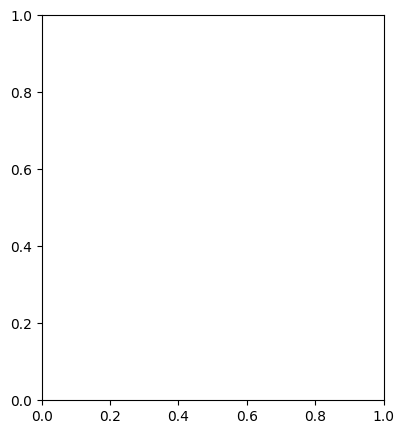

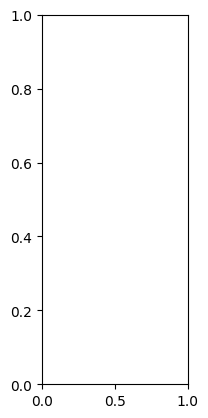

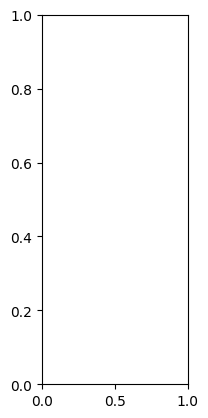

In [ ]:
import cirq
import numpy as np
import qutip as qt
from matplotlib import pyplot as plt

def single_qubit_angle_encode(data_point, rotation='x'):
    """
    Encode a single classical value into a qubit's rotation
    Args:
        data_point (float): Value to encode (should be normalized between 0 and 2π)
        rotation (str): Rotation axis ('x', 'y', or 'z')
    Returns:
        Circuit: Cirq circuit with encoded angle
        final_state: Final state vector after encoding
    """
    # Create circuit with single qubit
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit()

    # Choose rotation based on axis
    if rotation == 'x':
        circuit.append(cirq.rx(data_point)(qubit))
    elif rotation == 'y':
        circuit.append(cirq.ry(data_point)(qubit))
    else:  # z rotation
        circuit.append(cirq.rz(data_point)(qubit))

    # Simulate to get state vector
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    final_state = result.final_state_vector

    return circuit, final_state

def plot_bloch_sphere(state_vector, title="Bloch Sphere Representation"):
    """
    Visualize a single-qubit state on the Bloch sphere
    Args:
        state_vector: Complex numpy array representing quantum state
        title: Title for the plot
    """
    # Create a new figure
    plt.figure(figsize=(8, 8))

    # Create Bloch sphere
    b = qt.Bloch()

    # Convert state vector to Qutip state
    psi = qt.Qobj(state_vector)

    # Add state to Bloch sphere
    b.add_states(psi)
    b.add_states(psi, 'point')

    # Customize appearance
    b.sphere_alpha = 0.1
    b.vector_color = ['r']
    b.point_color = ['b']

    # Add title
    plt.title(title)

    # Render Bloch sphere
    b.render()
    plt.close()

    return b

# Example usage
angles = [np.pi/4, np.pi/2, 3*np.pi/4]

# Plot for different angles with Y-rotation
for angle in angles:
    circuit, state = single_qubit_angle_encode(angle, rotation='y')
    print(f"\nCircuit for {angle:.3f} radians Y-rotation:")
    print(circuit)
    print(f"Final state vector: {state}")

    # Visualize on Bloch sphere
    b = plot_bloch_sphere(state, f"Y-rotation by {angle:.3f} radians")
    plt.show()

# Compare different rotation axes
angle = np.pi/3
rotations = ['x', 'y', 'z']

plt.figure(figsize=(15, 5))
for i, rotation in enumerate(rotations, 1):
    plt.subplot(1, 3, i)
    circuit, state = single_qubit_angle_encode(angle, rotation=rotation)
    b = plot_bloch_sphere(state, f"{rotation.upper()}-rotation by {angle:.3f} radians")
    plt.show()

**Multi-Qubit Angle Encoding**

$|\psi(x_1, x_2, \ldots , x_n)\rangle = R_1(x_1) \otimes R_2(x_2) \otimes \ldots \otimes R_n(x_n) |0\rangle \otimes n$

In [ ]:
import cirq
import numpy as np

def multi_qubit_angle_encode(data_vector):
    """
    Encode multiple classical values into multiple qubits using rotation gates
    Args:
        data_vector (list): List of values to encode (should be normalized between 0 and 2π)
    Returns:
        Circuit: Cirq circuit with encoded angles
    """
    # Create qubits for each data point
    qubits = [cirq.GridQubit(0, i) for i in range(len(data_vector))]
    circuit = cirq.Circuit()

    # Encode each value using Ry rotation
    for qubit, value in zip(qubits, data_vector):
        circuit.append(cirq.ry(value)(qubit))

    # Add measurements
    circuit.append(cirq.measure(*qubits, key='result'))
    return circuit

# Example usage
data = [np.pi/4, np.pi/3, np.pi/2]  # Example values to encode
circuit = multi_qubit_angle_encode(data)
print(f"Circuit for encoding {data}:")
print(circuit)

# Simulate results
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=100)
print("\nMeasurement results:")
print(result.histogram(key='result'))

Circuit for encoding [0.7853981633974483, 1.0471975511965976, 1.5707963267948966]:
(0, 0): ───Ry(0.25π)────M('result')───
                        │
(0, 1): ───Ry(0.333π)───M─────────────
                        │
(0, 2): ───Ry(0.5π)─────M─────────────

Measurement results:
Counter({1: 30, 0: 30, 2: 16, 3: 10, 4: 5, 7: 4, 5: 3, 6: 2})


**Dense Angle Encoding**

$|\psi(x_1, x_2, \ldots , x_n)\rangle = R_1(x_1) P_1(x_2) \otimes R_2(x_3) P_2(x_4) \otimes \ldots \otimes R_n(x_{2n-1}) P_n(x_{2n}) |0\rangle \otimes n$

In [ ]:
import cirq
import numpy as np

def dense_angle_encode(data_vector):
    """
    Dense angle encoding using both Ry and Rz rotations on each qubit
    Args:
        data_vector (list): List of values to encode (length should be 2*n_qubits)
    Returns:
        Circuit: Cirq circuit with densely encoded angles
    """
    n_qubits = len(data_vector) // 2  # Each qubit encodes 2 values
    qubits = [cirq.GridQubit(0, i) for i in range(n_qubits)]
    circuit = cirq.Circuit()

    # Encode pairs of values using Ry and Rz rotations
    for i, qubit in enumerate(qubits):
        # Ry rotation for first value
        circuit.append(cirq.ry(data_vector[2*i])(qubit))
        # Rz rotation for second value
        circuit.append(cirq.rz(data_vector[2*i + 1])(qubit))

    # Add measurements
    circuit.append(cirq.measure(*qubits, key='result'))
    return circuit

# Example usage
data = [np.pi/4, np.pi/3, np.pi/2, np.pi/6]  # 4 values to encode into 2 qubits
circuit = dense_angle_encode(data)
print(f"Circuit for encoding {data}:")
print(circuit)

# Simulate results
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=100)
print("\nMeasurement results:")
print(result.histogram(key='result'))

Circuit for encoding [0.7853981633974483, 1.0471975511965976, 1.5707963267948966, 0.5235987755982988]:
(0, 0): ───Ry(0.25π)───Rz(0.333π)───M('result')───
                                    │
(0, 1): ───Ry(0.5π)────Rz(0.167π)───M─────────────

Measurement results:
Counter({1: 44, 0: 41, 3: 9, 2: 6})


**Amplitude Encoding**

$|\psi(x)\rangle =  x_1 |0\rangle + x_2 |1\rangle + ... + x_N |N-1\rangle = \sum_{i=0}^{N-1} x_i |i\rangle $

In [ ]:
import cirq
import numpy as np
from scipy.linalg import logm, expm

def amplitude_encode(normalized_vector):
    """
    Encode classical data into quantum amplitudes
    Args:
        normalized_vector (list): Normalized vector to encode (length must be power of 2)
    Returns:
        Circuit: Cirq circuit that prepares the state with given amplitudes
    """
    # Check if length is power of 2
    n_qubits = int(np.log2(len(normalized_vector)))
    if 2**n_qubits != len(normalized_vector):
        raise ValueError("Input vector length must be power of 2")

    # Create qubits
    qubits = [cirq.GridQubit(0, i) for i in range(n_qubits)]
    circuit = cirq.Circuit()

    # Create state preparation unitary
    # This is a simplified version that works for some cases
    # A full implementation would use quantum state preparation algorithms
    # like the Quantum Random Access Memory (QRAM) or Möttönen method

    def create_state_preparation():
        # Initialize in |0...0⟩ state
        initial_state = np.zeros(2**n_qubits)
        initial_state[0] = 1

        # Calculate required unitary
        target_state = np.array(normalized_vector)
        initial_state = initial_state.reshape(-1, 1)
        target_state = target_state.reshape(-1, 1)

        # Using a simple rotation approach
        cos_theta = np.abs(initial_state.T @ target_state)[0, 0]
        theta = np.arccos(cos_theta)

        if np.abs(theta) < 1e-10:
            return []

        axis = np.cross(initial_state.T, target_state.T)[0]
        axis = axis / np.linalg.norm(axis)

        generator = np.zeros((2**n_qubits, 2**n_qubits))
        for i in range(2**n_qubits):
            for j in range(2**n_qubits):
                if i != j:
                    generator[i, j] = theta * axis[j]
                    generator[j, i] = -theta * axis[j]

        unitary = expm(generator)
        return unitary

    # Try to decompose the unitary into gates (simplified approach)
    try:
        unitary = create_state_preparation()
        circuit.append(cirq.MatrixGate(unitary).on(*qubits))
    except:
        print("Warning: Could not create exact encoding. Using approximate approach.")
        # Add some basic rotations as approximation
        for i, amplitude in enumerate(normalized_vector):
            if amplitude != 0:
                angle = 2 * np.arccos(np.abs(amplitude))
                circuit.append(cirq.ry(angle)(qubits[0]))

    # Add measurements
    circuit.append(cirq.measure(*qubits, key='result'))
    return circuit

# Example usage
# Create normalized vector (must sum to 1)
data = [0.5, 0.5, 0.5, 0.5]  # Example normalized vector for 2 qubits
normalized_data = np.array(data) / np.linalg.norm(data)

circuit = amplitude_encode(normalized_data)
print(f"Circuit for encoding {normalized_data}:")
print(circuit)

# Simulate results
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=100)
print("\nMeasurement results:")
print(result.histogram(key='result'))

# Optional: Check state vector
final_state = simulator.simulate(circuit).final_state_vector
print("\nFinal state vector:")
print(final_state)

Circuit for encoding [0.5 0.5 0.5 0.5]:
(0, 0): ───Ry(0.667π)───Ry(0.667π)───Ry(0.667π)───Ry(0.667π)───M('result')───
                                                               │
(0, 1): ───────────────────────────────────────────────────────M─────────────

Measurement results:
Counter({2: 71, 0: 29})

Final state vector:
[ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]


##### <font color="blue">*Quantum Fourier Transform*

Momentum Space and Position Space with Quantum Fourier Transform

https://youtu.be/W8QZ-yxebFA

> **Quantum Fourier Transform is the change from one basis (computational) to another (Fourier basis)**

* Quantum Fourier Transform is the inverse Discrete Fourier Transform)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_047.png)

**General formula**

* Remember: <font color="blue">$e^{2\pi i}$ = 1</font> (identity operation), and see why $e^{\pi i}$ = -1 in [this video](https://youtu.be/-AyE1Wpgo3Q)


* In QFT we change the <font color="blue">$\theta$ = phase in $e^{2\pi i \theta}$</font> = Eigenvalue of Oracle function $U$ associated with an eigenvector |u⟩

* The phase $\theta$ is expressed as: <font color="blue">$\theta$ = $\frac{x_n}{2^{k_n}}$</font> with:

  * <font color="blue">$x_n$ = 0 or 1</font> state

  * <font color="blue">$k_n$</font> number of Qubits

* This is expressed in a so-called "controlled-R quantum gate" that **applies a relative phase change to |1>**

* The matrix form of this operator is: <font color="blue">$\hat{R}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{2 \pi i \frac{x_n}{ 2^{k_n}}}\end{array}\right)$</font>

*Quantum Fourier Transform with 3 Qubits: Introduction*

**Computational Basis States:** <font color="blue">$\tilde{x_1}$ = 0 or 1</font>, <font color="blue">$\tilde{x_2}$ = 0 or 1</font>, <font color="blue">$\tilde{x_3}$ = 0 or 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1, $k_2$ = 2, $k_3$ = 3</font>

> <font color="blue">$\tilde{x_1}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^{k_1}}+\frac{x_{2}}{2^{k_2}}+\frac{x_{3}}{2^{k_3}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^1}+\frac{x_{2}}{2^2}+\frac{x_{3}}{2^3}\right)}|1\rangle\right)$  = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$

* If only $\tilde{x_1}$ is activated, then it is a 180° Z-rotation of $\pi$ radians = -1

* If only $\tilde{x_2}$ is activated, then it is a 90° S-rotation of $\frac{\pi}{2}$ radians = i

* If only $\tilde{x_3}$ is activated, then it is a 45° T-rotation of $\frac{\pi}{4}$ radians = between 1 and i

> <font color="blue">$\tilde{x_2}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_2}{2^{k_1}}+\frac{x_3}{2^{k_2}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_2}{2^1}+\frac{x_3}{2^2}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_2}{2}+\frac{x_3}{4}\right)}|1\rangle\right)$

* If only $\tilde{x_2}$ is activated, then it is a 180° Z-rotation of $\pi$ radians = -1

* If only $\tilde{x_3}$ is activated, then it is a 90° S-rotation of $\frac{\pi}{2}$ radians = i

* If both $\tilde{x_2}$ and $\tilde{x_3}$ are activated, then it is a 180° + 90° = 170° rotation of $\pi + \frac{\pi}{2}$ radians = -i

> <font color="blue">$\tilde{x_3}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_3}{2^{k_1}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_3}{2^1}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{\pi \mathrm{i}x_3}|1\rangle\right)$

* If $\tilde{x_3}$ is activated, then it is a 180° Z-rotation of $\pi$ radians = -1


**Circuit Construction**

*Compare the equations above with the circuit activations below (how a circuits computes the results). For example for the first qubit the operator / gate $S$ = 90° rotation is only activated if the second qubit $x_2$ is in state 1. Here it is activated because $x_2$ = 1:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Here including the 8x8 matrix form for the complete operator:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0801.png)

*Quantum Fourier Transform with 1 Qubit*

**Computational Basis States:** <font color="blue">$\tilde{x_1}$ = 0 or 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1</font>


*Linear transformation of a qubit in the computational basis 0 and 1 each separately to the Fourier basis:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0813.png)

**Computational Basis in $|0\rangle$**

> <font color="blue">For $x_1$ = 0 $\Rightarrow$</font> <font color="blue">$\tilde{x_1}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^{k_1}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^1}\right)}|1\rangle\right)$  $\Rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{0}{2}\right)}$ = $\mathrm{e}^{2 \pi \mathrm{i} 0}$  = $\mathrm{e}^{0}$ = 1 (no rotation)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0810.png)

**Computational Basis in $|1\rangle$**

> <font color="blue">For $x_1$ = 1 $\Rightarrow$</font> <font color="blue">$\tilde{x_1}$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^{k_1}}\right)}|1\rangle\right)$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{x_1}{2^1}\right)}|1\rangle\right)$ $\Rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{1}{2}\right)}$ = $e^{\pi i 1} =$ <font color="blue">$-1$</font> (180° Z-rotation)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0811.png)

*Quantum Fourier Transform with 1 Qubit is a Hadamard transform!*

**One qubit QFT matrix**: $\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1 & 1 \\ 1 & \mathrm{e}^{\pi i}\end{array}\right)$, where $\mathrm{e}^{\pi \mathrm{i}}$ = -1. So it is: <font color="blue"> QFT für x=1 = $\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1 & 1 \\ 1 & -1\end{array}\right)$

**Compare with Hadamard transform matrix:**

In quantum computing, the Hadamard gate is a one-qubit rotation, mapping the qubitbasis states $|0\rangle$ and $|1\rangle$ to two **superposition** states with **equal weight of the computational basis** states $|0\rangle$ and $|1\rangle$. Usually the phases are chosen so that

>$
H=\frac{|0\rangle+|1\rangle}{\sqrt{2}}\langle 0|+\frac{|0\rangle-|1\rangle}{\sqrt{2}}\langle 1|
$

in Dirac notation. This corresponds to the transformation matrix

> <font color="blue">$
H_{1}=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}
1 & 1 \\
1 & -1
\end{array}\right)
$

in the $|0\rangle,|1\rangle$ basis, also known as the computational basis. The states $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$ and $\frac{|0\rangle-|1\rangle}{\sqrt{2}}$ are known as $|+\rangle$ and $|-\rangle$ respectively, and together constitute the polar basis in quantum computing.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_073.jpg)


**Why Hadamard transform is exactly a 1 qubit Quantum Fourier Transform:** (see result of + for 0 state and - for 1 state) - Matrix-Vector-Multiplication (Single Qubit)

> <font color="blue">$H |0\rangle$</font> $ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right] =\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$ <font color="blue">$ \,\,= |+\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

> <font color="blue">$H |1\rangle$</font>$ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$ <font color="blue">$ = |-\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$

$|+\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ weil <font color="gray">wegen $|0\rangle=\left[\begin{array}{l}1 \\ 0\end{array}\right]$ und $|1\rangle=\left[\begin{array}{l}0 \\ 1\end{array}\right]$ daher:</font> $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 + 0 \\ 0 + 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$

$|-\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$ weil: $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 - 0 \\ 0 - 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_045.png)

2 im denominator verschwindet hier. 2^n für n=1 qubit. mit 2 oben und unten verschwinden beide.

*Quantum Fourier Transform with 3 Qubits for $|001\rangle$*

**Computational Basis in $|001\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0804.png)

**Fourier Basis for $|001\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0805.png)

**Computational States:** <font color="blue">$\tilde{x_1}$ = 0</font>, <font color="blue">$\tilde{x_2}$ = 0</font>, <font color="blue">$\tilde{x_3}$ = 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1 qubit, $k_2$ = 2 qubits, $k_3$ = 3 qubits</font>

> <font color="blue">Qubit 1 = $\tilde{x_1}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^{k_1}}+\frac{x_{2}}{2^{k_2}}+\frac{x_{3}}{2^{k_3}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{0}{2}+\frac{0}{4}+\frac{1}{8}\right)}|1\rangle\right)$  = <font color="blue">$\frac{\pi i}{4}$</font> (45° T-rotation)

> <font color="blue">Qubit 2 = $\tilde{x_2}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{2}}{2^{k_1}}+\frac{x_{3}}{2^{k_2}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{0}{2}+\frac{1}{4}\right)}|1\rangle\right)$ = <font color="blue">$\frac{\pi i}{2}$</font> (90° S-rotation)

> <font color="blue">Qubit 3 = $\tilde{x_3}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{3}}{2^{k_1}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i} \frac{1}{2}}|1\rangle\right)$ = $e^{\pi i 1} =$ <font color="blue">$-1$</font> (180° Z-rotation)

**Circuit Construction**

*Compare the equations above with the circuit activations below (how a circuits computes the results). For example for the first qubit the operator / gate $S$ = 90° rotation is only activated if the second qubit $x_2$ is in state 1. Here it is not activated because $x_2$ = 0:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Quantum Fourier Transform with 3 Qubits for $|111\rangle$*

**Computational Basis in $|111\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0802.png)

**Fourier Basis for $|111\rangle$**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0803.png)

**Computational States:** <font color="blue">$\tilde{x_1}$ = 1</font>, <font color="blue">$\tilde{x_2}$ = 1</font>, <font color="blue">$\tilde{x_3}$ = 1</font>. Number of Qubits: <font color="blue">$k_1$ = 1 qubit, $k_2$ = 2 qubits, $k_3$ = 3 qubits</font>

> <font color="blue">Qubit 1 = $\tilde{x_1}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2^{k_1}}+\frac{x_{2}}{2^{k_2}}+\frac{x_{3}}{2^{k_3}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{1}{2}+\frac{1}{4}+\frac{1}{8}\right)}|1\rangle\right)$ = $\mathrm{e}^{2 \pi i 0.875} = \mathrm{e}^{\pi i 1.75}$ (180° Z-rotation + 90° S-rotation + 45° T-rotation)

> <font color="blue">Qubit 2 = $\tilde{x_2}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{2}}{2^{k_1}}+\frac{x_{3}}{2^{k_2}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{1}{2}+\frac{1}{4}\right)}|1\rangle\right)$ = $e^{\pi i 1.5} =$ <font color="blue">$-i$</font> (180° Z-rotation + 90° S-rotation)

> <font color="blue">Qubit 3 = $\tilde{x_3}$</font> = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{3}}{2^{k_1}}\right)}|1\rangle\right)$ = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i} \frac{1}{2}}|1\rangle\right)$ = $e^{\pi i 1} =$ <font color="blue">$-1$</font> (180° Z-rotation)

**Circuit Construction**

*Compare the equations above with the circuit activations below (how a circuits computes the results). For example for the first qubit the operator / gate $S$ = 90° rotation is only activated if the second qubit $x_2$ is in state 1. Here it is activated because $x_2$ = 1:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Cirq Code for Quantum Fourier Transform*

*Compare the code above with the circuit activations below (how a circuits computes the results):*

* $H$ gate = bring qubit in superposition.

  * *For $x=0$, no further rotation*

  * *For $x=1$, then appy additional *$Z$ gate = 180° rotation = $\pi$**

* *$S$ gate = 90° rotation = $\frac{\pi}{2}$*

* *$T$ gate = 45° rotation = $\frac{\pi}{4}$*

$C R_{j}=C Z^{1 / 2^{j-1}}$

* $Z$ entspricht $\pi$ (ein halber Kreis, zB von +1 zu -1 auf X-Achse)

* $S$ entspricht $\frac{\pi}{2}$, also wenn qubit 1 = 1, dann bei qubit 0 das $S$ transform anwenden (0,5)

  * S: The square root of Z gate, equivalent to cirq.Z ** 0.5

  * See: [Cirq Gates](https://quantumai.google/cirq/gates)

* $T$ entspricht $\frac{\pi}{4}$

In [ ]:
!pip install cirq -q
import cirq

def make_qft(qubits):

    # Generate list of qubits
    qreg = list(qubits)

    # Make sure list is longer than 0 qubits:
    while len(qreg) > 0:

    # Remove first qubit from list and return its value (set as head-qubit):
        q_head = qreg.pop(0)

    # Apply Hadamard superposition to this head-qubit
        yield cirq.H(q_head)

    # Enumerate through list with i (index position) and corresponding qubit value (0 or 1)
        for i, qubit in enumerate(qreg):

    # Apply Controlled-Z * Theta-Phase-Shift on target ('q-head') if control-qubit ('qubit') is in state 1
            yield (cirq.CZ ** (1 / 2 ** (i + 1)))(qubit, q_head)

    # Do the inverse QFT as subroutine in quantum phase estimation
    #        yield (cirq.CZ ** (-1 / 2 ** (i + 1)))(qubit, q_head)

# Use inverse QFT as subroutine in quantum phase estimation
# phase_estimator.append(make_qft_inverse(qubits[::-1]))

    # Iterating through until "while len(qreg) = 0", then processes stops

"""Visually check the QFT circuit."""
qubits = cirq.LineQubit.range(17)
qft = cirq.Circuit(make_qft(qubits))
print(qft)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0815.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0812.png)

*Inverse Quantum Fourier Transform ('QFT Dagger' - Dagger is a complex conjugate operation!)*

Reminder of QFT:

* $QFT\,\,|x\rangle=|\tilde{x}\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{2 \pi i}{N} x y} |y\rangle$

**Remember: Dagger is a complex conjugate operation!**

QFT inverse (see -2 turning i in -i which is a complex conjugate operation):

* $QFT^{\dagger}|\tilde{x}\rangle=|x\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i}{N} x y} |y\rangle$


The operator is then (
We have already seen that the Hadamard gate is self-inverse, and the same is clearly true for the SWAP gate; the inverse of the rotations gate $R_k$ is given by):

> The matrix form of inverse QFT operator is: <font color="blue">${R^{\dagger}}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{-2 \pi i / 2^{k}}\end{array}\right)$</font> and compare with QFT operator:  <font color="blue">$\hat{R}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{2 \pi i / 2^{k}}\end{array}\right)$

https://www.cl.cam.ac.uk/teaching/1920/QuantComp/Quantum_Computing_Lecture_9.pdf

##### <font color="blue">*Quantum Phase Estimation*

*Exkurs: Quantum Phase Kickback*

**CNOT Gate and Phase Kickback**

<font color="blue">*CNOT-Gate applied to the computational basis 0 and 1*

* https://qiskit.org/textbook/ch-gates/phase-kickback.html

* Main article about Phase Kickback: https://towardsdatascience.com/quantum-phase-kickback-bb83d976a448

The CNOT-gate is a two-qubit gate. Thus, it transforms qubit states whose state we represent by a four-dimensional vector.

>$
|\psi\rangle=\alpha|0\rangle|0\rangle+\beta|0\rangle|1\rangle+\gamma|1\rangle|0\rangle+\delta|1\rangle|1\rangle=\left[\begin{array}{c}
\alpha \\
\beta \\
\gamma \\
\delta
\end{array}\right]
$

Remember Vector-Vector-Multiplikation (Kronecker / tensor product):

> $\mathbf{uv}$ = $\left[\begin{array}{c}u_{1} \\ u_{2}\end{array}\right]$ $\otimes$ $\left[\begin{array}{c}v_{1} \\ v_{2} \end{array}\right]$ = $\left[\begin{array}{l}u_{1}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right] \\ u_{2}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right]\end{array}\right]$=  $\left[\begin{array}{c}u_{1} v_{1} \\ u_{1} v_{2}\\ u_{2} v_{1} \\ u_{2} v_{2}\end{array}\right]$

> $\left[\begin{array}{l}1 \\ 0\end{array}\right]=|0\rangle, \quad\left[\begin{array}{l}0 \\ 1\end{array}\right]=|1\rangle$.

We choose two qubits in state $|0\rangle$:

> $|0\rangle \otimes|0\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right]=$</font> $\left[\begin{array}{l}1\left[\begin{array}{l}1 \\ 0\end{array}\right] \\ 0\left[\begin{array}{l}1 \\ 0\end{array}\right]\end{array}\right]=$ $\left [\begin{array}{l}11 \\ 10 \\ 01 \\ 00\end{array}\right]$ = <font color="gray">$\left [\begin{array}{l}3 \\ 2 \\ 1 \\ 0\end{array}\right]$</font> = <font color="blue">$\left [\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]$

Quits in two different states:

> $|0\rangle \otimes|1\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}0 \\ 1\end{array}\right]=\left[\begin{array}{l}1\left[\begin{array}{l}0 \\ 1\end{array}\right] \\ 0\left[\begin{array}{l}0 \\ 1\end{array}\right]\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]$

Accordingly, the CNOT-gate has a $4 \times 4$ transformation matrix.

>$
C N O T=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{array}\right]
$

There is no effect if the control qubit (at the left-hand position in the Dirac notation) is in state |0⟩, as in states |00⟩ and |01⟩.

> CNOT $\cdot|00\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=|00\rangle$

> CNOT $\cdot|01\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=|01\rangle$

<font color="blue">But if the control qubit is in state |1⟩, then the controlled (target) qubit switches from |0⟩ to |1⟩ and vice versa.</font>

> CNOT $\cdot|10\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=|11\rangle$

> CNOT $\cdot|11\rangle=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=|10\rangle$

When we describe the quantum states and operations in terms of mathematical formulae, we use the vectors |0⟩ and |1⟩ as a basis. |0⟩ and |1⟩ denote the standard or computational basis states. These states correspond to the possible measurements we might obtain when looking at the qubit. We measure a qubit in state |0⟩ as 0 with absolute certainty. And, we measure a qubit in state |1⟩ as 1, accordingly. While the basis {|0⟩,|1⟩} is convenient to work with mathematically, it is just a representation of the underlying physics.


<font color="blue">*CNOT-Gate applied to the superposition basis + and -*

The mathematical basis we chose leads to a specific representation of the CNOT-transformation. But this is not the only possible representation. In fact, there are infinitely many other possible choices. Our qubits are not limited to these two states. Qubits can be in a superposition of both states. For instance, there are the states that result from applying the Hadamard-gate on the basis states:

> $|+\rangle=\left[\begin{array}{c}\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}}\end{array}\right]$ and $|-\rangle=\left[\begin{array}{c}\frac{1}{\sqrt{2}} \\ -\frac{1}{\sqrt{2}}\end{array}\right]$

Remember: Apply Hadamard gate on a qubit that is in the |0> state:

> $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right]$

Now apply Hadamard gate on a qubit that is in the |1> state:

> $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ -1\end{array}\right]$

Mathematically, the following matrix represents the application of Hadamard gates on each of the two qubits.

> $H \otimes H=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}H & H \\ H & -H\end{array}\right]=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right]$

So, if we apply this matrix on two qubits in state |00⟩, they end up in state |++⟩.

> $\begin{aligned} H \otimes H(|00\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{l}1 \\ 1 \\ 1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle+|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|++\rangle \end{aligned}$

The input state |01⟩ results in state |+−⟩.

> $\begin{aligned} H \otimes H(|01\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ 1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle+|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|+-\rangle \end{aligned}$

The input state |10⟩ results in state |−+⟩.

> $\begin{aligned} H \otimes H(|10\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ 1 \\ -1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle-|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|-+\rangle \end{aligned}$

Finally, if we apply this transformation on two qubits in state |11⟩, we put them into state |−−⟩.

> $\begin{aligned} H \otimes H(|11\rangle) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ -1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle-|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|--\rangle \end{aligned}$

Now, let’s apply the CNOT-gate on qubits in superposition. We can calculate the overall transformation matrix by multiplying the matrices of the CNOT-gate and the H⊗H transformation. The CNOT-gate switches the second and fourth columns of the H⊗H-matrix.

> $\operatorname{CNOT}(H \otimes H)=\left[\begin{array}{cccc}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right] \cdot \frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right]=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right]$

* And now, we apply this transformation to the four combinations of basis states.

<font color="blue">If the target qubit (at the right-hand side) is in state |1⟩, the state of the control qubit (at the left-hand side) flips from |+⟩ to |−⟩ and vice versa:

>

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|00\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{l}1 \\ 1 \\ 1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle+|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|++\rangle \end{aligned}$

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|01\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ -1 \\ 1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle-|1\rangle|0\rangle+|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|--\rangle \end{aligned}$

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|10\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 1 \\ 0\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ 1 \\ -1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle+|0\rangle|1\rangle-|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\ &=|-+\rangle \end{aligned}$

> $\begin{aligned} \operatorname{CNOT}(H \otimes H(|11\rangle)) &=\frac{1}{2}\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\end{array}\right] \cdot\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 1\end{array}\right]=\frac{1}{2}\left[\begin{array}{c}1 \\ -1 \\ 1 \\ -1\end{array}\right] \\ &=\frac{1}{2}(|0\rangle|0\rangle-|0\rangle|1\rangle+|1\rangle|0\rangle-|1\rangle|1\rangle) \\ &=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \\ &=|+-\rangle \end{aligned}$

In short, we can say:

> $\operatorname{CNOT}(|++\rangle)=|++\rangle$

> $\operatorname{CNOT}(|+-\rangle)=|--\rangle$

> $\operatorname{CNOT}(|-+\rangle)=|-+\rangle$

> $\operatorname{CNOT}(|--\rangle)=|+-\rangle$

The two states |+⟩ and |−⟩ have the same measurement probabilities of |0⟩ and |1⟩. They result in either value with a probability of 0.5. **So, the CNOT-gate does not have any directly measurable implications**. <font color="blue">However, the control qubit switches its phase. It takes on the phase of the controlled (target) qubit.</font>

> For the phase of the target qubit is kicked up to the control qubit, we call this phenomenon phase kickback.

We learned the CNOT-gate is not a one-sided operation. It clearly has the potential to affect the state of the control qubit. Even though the phase is not directly measurable, there are ways to exploit differences in the phase between states. In fact, prominent algorithms, such as Grover’s search algorithm, exploit this effect.


<font color="red">**Phase Kickback: Control qubit changes:**
* from 0 to 1 or from 1 to 0 if target qubit was in state 1,
* from (+) to (-) or from (-) to (+) if the target was in (-)

**Quantum Phase Estimation**

* algorithm for determining the eigenvalues of a unitary operator

* the [quantum phase estimation algorithm](https://en.m.wikipedia.org/wiki/Quantum_phase_estimation_algorithm) (also referred to as quantum eigenvalue estimation algorithm), is a quantum algorithm to estimate the phase (or eigenvalue) of an eigenvector of a unitary operator.

* More precisely, given a unitary matrix $U$ and a quantum state $|\psi\rangle$ such that $U|\psi\rangle=e^{2 \pi i \theta}|\psi\rangle$, the algorithm estimates the value of $\theta$ with high probability within additive error $\varepsilon$, using $O(\log (1 / \varepsilon))$ qubits (without counting the ones used to encode the eigenvector state) and $O(1 / \varepsilon)$ controlled- $U$ operations.

* The algorithm was initially introduced by Alexei Kitaev in 1995.

* Phase estimation is frequently used as a subroutine in other quantum algorithms, such as Shor's algorithm and the quantum algorithm for linear systems of equations.

<font color="blue">*One Qubit Phase Estimation (with Hadamard Gate):*

![gg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_117.png)

<font color="blue">*Multi-Qubit Phase Estimation (with inverse Quantum Fourier Transform):*

![gg](https://upload.wikimedia.org/wikipedia/commons/a/a5/PhaseCircuit-crop.svg)

Remember in **Quantum Fourier Transform**:


> x1 = $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$

* <font color="blue">$e^{2\pi i}$ = 1 = identity</font>

* In Quantum Fourier Transform we change the phase <font color="blue">$\theta$ in $e^{2\pi i}$</font> <font color="red">$^{\theta}$</font>

  * <font color="red">= Eigenvalue of Oracle function $U$ associated with an eigenvector |u⟩</font>

* Phase <font color="blue">$\theta$ is $\frac{x_n}{2^{k}}$ with $x_n$ 0 or 1</font> state and $k$ number of Qubits.

* A controlled-R quantum gate applies a relative phase change to |1>. The matrix form of this operator is: <font color="blue">$\hat{R}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{2 \pi i / 2^{k}}\end{array}\right)$

**Now in Phase Estimation**:

> In $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$ dieser Teil ist die **Phase $\theta$** = $(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8})$ mit dem Operator: $U^{2^n} = \phi$

Quantum phase estimation addresses the following problem:
* We have a $n$-qubit oracle function $U$, encoded in the form of a controlled- $U$ unitary.
* **$U$ has an eigenvalue $e^{2 \pi i \phi}$, associated with an eigenvector $|u\rangle$ which we can prepare.**
* <font color="red">**We wish to estimate the phase, $\phi$, of the eigenvalue to $t$ bits of precision.**

> <font color="blue">**Given a unitary operator $U$, the algorithm estimates $\theta$ in $U|\psi\rangle=e^{2 \pi i \theta}|\psi\rangle$** $\quad$ (based on Eigenvalue equation)</font>

* Here $|\psi\rangle$ is an eigenvector / eigenstate and $e^{2 \pi i \theta}$ is the corresponding eigenvalue.

* <font color="red">For example: the eigenvalues of X are −1 and 1 and have the eigenvectors |−⟩ and |+⟩ respectively.*</font>

*Since $U$ is unitary, all of its eigenvalues have a norm of 1.*

Reminder: QFT

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_084.png)

>**See below: <font color="red">Remember that a unitary matrix has eigenvalues of the form $e^{i \theta_{\psi}}$ (ohne $2 \pi$ wie oben bei QFT) and that it has eigenvectors that form an orthonormal basis**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_083.png)

The problem: in both cases the probability is 0,5, just differs by the phase added: $=e^{\frac{i \pi}{2}}$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_078.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_079.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_080.png)

**The probability of measuring 0 and 1 is each 0,5, but there is a small factor that makes them differ from 0,5, depending on the phase (angle):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_081.png)

> **In the different between the probability of measuring 0 or 1, you've encoded that phase! (In other words: you've taken that phase information and turned it into and amplitude that you can measure.**

* How to do this experimentally: you do a million shots of the experiment, collect statistics and check what the statistics say. How many times did I get zero? How many times did I get one? The hope is that the difference between the statistics of zero and one would allow us to back out theta

* Next level: now getting more precision with more qubits: (there is another circuit to prepare Psi yet, which is assumed to be given here)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_082.png)

writing out the calculation:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_085.png)

**Comparing QPE with QFT (QPE is the same as QFT with a different phase):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_086.png)

It's like applying a QFT of something (of a special phase $\frac{\theta_{\psi}}{2^{n}} 2 \pi$, the green box above!), and in order to get back to the original state you need to apply an inverse QFT at the end:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_087.png)

*Step 1: Set up the unitary and number of bits to use in phase estimation*

<font color="blue">*Let's take as an example the T-gate, and use Quantum Phase Estimation to estimate its phase.*

You will remember that the $T$-gate adds a phase of $e^{\frac{i \pi}{4}}$ to the state $|1\rangle$ :

$
T|1\rangle=\left[\begin{array}{ll}
1 & 0 \\
0 & e^{\frac{i \pi}{4}}
\end{array}\right]\left[\begin{array}{l}
0 \\
1
\end{array}\right]=e^{\frac{i \pi}{4}}|1\rangle
$

Since QPE will give us $\theta$ where: $
T|1\rangle=e^{2 i \pi \theta}|1\rangle
$

<font color="red">We expect to find theta: $
\theta=\frac{1}{8}
$

We first perform a Hadamard gate on the first qubit to get the state

  * Original state of both qubits: $|0\rangle \otimes|\psi\rangle$

  * Hadamard on first qubit: $|+\rangle \otimes|\psi\rangle$ =

  * <font color="red">Distribute superposition: $|0\rangle|\psi\rangle+|1\rangle|\psi\rangle$</font>

  * <font color="blue">this part above is the rule from tensor products: If the state of the first particle is a superposition of two states, the state of the two-particle system is also a superposition: $\left(v_{1}+v_{2}\right) \otimes w=v_{1} \otimes w+v_{2} \otimes w$
</font>

    * The Hadamard states ∣+⟩ and ∣−⟩ are considered superposition states because they are a combination of the two computational states:

    * State: $|\pm\rangle=\frac{1}{\sqrt{2}}|0\rangle \pm \frac{1}{\sqrt{2}}|1\rangle$ so for + it is: $|\+\rangle=\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle$

  * we have intentionally omitted the normalization factor of 1/√2 for clarity

> $|+\rangle \otimes|\psi\rangle = \frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right] \otimes\left[\begin{array}{l}\psi\end{array}\right]= \frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \, [\psi] \\ 1 \, [\psi]\end{array}\right]$

Remember: Apply Hadamard gate on a qubit that is in the |0> state:

> $|+\rangle$ = $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right]$ =  $\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle$

In [ ]:
# Value of θ which appears in the definition of the unitary U above.
# Try different values.
theta = 0.125

# Define the unitary U-Gate:
U = cirq.Z ** (2 * theta)

# Accuracy of the estimate for theta. Try different values.
n_bits = 3

Here details about unitary U-Gate:

$U$ = $Z^{2^{n-n}}$

Z = $e^{\pi}$

* $Z$ entspricht $\pi$ (ein halber Kreis, zB von +1 zu -1 auf X-Achse)


then:

> <font color="blue">$U$ = $e^{\pi * 2^{n-n}}$


*Step 2: Build the first part of the circuit for phase estimation with controlled U-gate (Phase Kickback)*

We then perform a controlled U operation, which we have written as $U^{2^0}$. Here applies the **Phase Kickback!**

  * $|0\rangle|\psi\rangle+|1\rangle$ <font color="red">$U$</font> $|\psi\rangle$ =

  * $|0\rangle|\psi\rangle+$ <font color="red">$e^{2 \pi i 0. \phi_{1}}$</font> $|1\rangle|\psi\rangle$ =

  * $|0\rangle+$ <font color="red">$e^{2 \pi i 0. \phi_{1}}$</font> $|1\rangle) \otimes|\psi\rangle$

* Here are 2 things very important:

    * The second qubit register containing |ψ⟩ hasn’t changed. We shouldn’t expect it to, **since |ψ⟩ is an eigenstate of U (Remember: <font color="blue">**Given a unitary operator $U$, the algorithm estimates $\theta$ in $U|\psi\rangle=e^{2 \pi i \theta}|\psi\rangle$ based on the Eigenvalue equation**</font>). Thus, no matter how many times we apply U to this register, nothing happens to |ψ⟩**. But if we apply it more often it will 'amplify' the phase (Not in the sense of amplitude amplification) - we amplify it with adding more qubits and hence more $\phi$ to get more precision

    * what’s the point of applying U then? The effect was that **it wrote some information about the eigenvalue into the relative phase of the first qubit**. Namely, the entire effect was to
map: $|0\rangle+|1\rangle \mapsto|0\rangle+e^{2 \pi i 0. \phi_{1}}|1\rangle$

In [ ]:
# Get qubits for the phase estimation circuit.
qubits = cirq.LineQubit.range(n_bits)
u_bit = cirq.NamedQubit('u')

# Build the first part of the phase estimation circuit.
phase_estimator = cirq.Circuit(cirq.H.on_each(*qubits))

# Set the input state of the eigenvalue register: Add gate to change initial state to |1>
phase_estimator.insert(0, cirq.X(u_bit))

# bit = cirq.LineQubit
for i, bit in enumerate(qubits):
    phase_estimator.append(cirq.ControlledGate(U).on(bit, u_bit) ** (2 ** (n_bits - i - 1)))
    # explanation: U-rot control aktiviert wenn entsprechendes qubit in state 1 (??)
    # dann aktiviere formel: U^2^(n-1) ...U^2^(n-2) ...U^2^(n-n)

print(phase_estimator)

> <font color="blue">$U$ = $Z^{2^{n-n}}$ = $e^{\pi * 2^{n-n}}$ fur das erste Gate: = $e^{\pi * (-0.128)}$ ????


*Why are we adding Pauli-X? The initial state for u_bit is the  state, but the phase for this state is trivial with the operator we chose. Inserting a Pauli  operator at the begining of the circuit changes this to the  state, which has the nontrivial  phase.*

*The controlled u gate*:

$|00\rangle \mapsto|00\rangle$

$|01\rangle \mapsto|01\rangle$

$|10\rangle \mapsto|1\rangle \otimes U|0\rangle=|1\rangle \otimes\left(u_{00}|0\rangle+u_{10}|1\rangle\right)$

$|11\rangle \mapsto|1\rangle \otimes U|1\rangle=|1\rangle \otimes\left(u_{01}|0\rangle+u_{11}|1\rangle\right)$

The matrix representing the controlled $U$ is

>$
\mathrm{C} U=\left[\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & u_{00} & u_{01} \\
0 & 0 & u_{10} & u_{11}
\end{array}\right]
$

**When U is one of the Pauli operators, X,Y, Z, the respective terms "controlled-X", "controlled-Y", or "controlled-Z" are sometimes used**.
Sometimes this is shortened to just CX, CY and CZ.

<font color="blue">*Why should we use more than one control Qubit?*

**Remember from Eigenvalue problem: Ax = λx in our case with the unitary operator: Ux = λx**

> $Ux =$ <font color="red">$e^{2πi*0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} }$</font> $x$

> Beispiel: Wenn $0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} = 0$, dann ist $e^{2πi*0}$ = λ = 1, so dass Ux = 1x. Damit ist λ = 1 ist der Eigenwert von f.

* Since |λ| = 1, we can write it without loss of generality as λ = $e^{2πiφ}$, where <font color="red">$e^{2πi}$ = 1 (= identity, if you insert 2*π*i into exponent at random, you will not change the result. Sometimes it can be a useful identity [Source](https://www.physicsforums.com/threads/e-2-pi-i-where-from.430393/), from Euler identity)</font> and **0 ≤ φ ≤ 1 is called the phase. This is what we want to estimate!**

* We saw that in QFT, φ being between 0 and 1 $\rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}$

> **The term “estimation” comes about not from the fact that quantum computation is probabilistic, but rather in the degree of precision that we are going to compute, or estimate, the phase to.**

* The phase φ is going to be between zero and one, so we can write it as a decimal in binary notation as follows: $φ = 0.φ_1 φ_2 ···φ_n$, where each φi is either zero or one

  * The expression $\phi=0 . \phi_{1} \phi_{2} \cdots \phi_{n}$ is equivalent to $\phi=0 . \phi_{1} \phi_{2} \cdots \phi_{n} \Longleftrightarrow \phi=\sum_{k=1}^{n} \phi_{k} 2^{-k}$. Some numbers as binary decimals:

    * <font color="blue">The number 0.5 in decimal is 0.1 in binary, since 0.1 ≡ (1) · $2^{−1}$ = 1/2 = 0.5. So: $0.5_{10} = 0.1_2$. Note that 0.1 is the same as 0.100000....</font>

    * <font color="blue">The number 0.75 in decimal is 0.11 in binary, since 0.11 ≡ (1)·$2^{−1}$ +1·$2^{−2}$ = 1/2+1/4 = 3/4 = 0.75. To get this we need 2 Qubits. So we get more precision with more qubits</font>

    * 0.111 = 0.875

    * 0.1111 = 0.9375 in decimal, because: $0 \cdot 2^{0}+1 \cdot 2^{-1}+1 \cdot 2^{-2}+1 \cdot 2^{-3}+1 \cdot 2^{-4}=0 \cdot 1+1 \cdot 0.5+1 \cdot 0.25+1 \cdot 0.125+1 \cdot 0.0625=0+0.5+0.25+0.125+0.0625=0.937510$

  * Check also what is the value of the infinitely repeating binary decimal 0.1111111...

  * If it needed to be proved, the above exercise proves that 0 ≤ 0.φ1φ2 · · · ≤ 1


*Operator $U^{2^n}$ in QPE*

* $U^{2^0}$: 1 (decimal) = 00001

* $U^{2^1}$: 2 (decimal) = 00010

* $U^{2^2}$: 4 (decimal) = 00100

* $U^{2^3}$: 8 (decimal) = 01000

* $U^{2^4}$: 16 (decimal) = 10000


**So for falls die Phase 0.111 ist, wuerde bei 3 Qubits QPE berechnen:**

* $e^{2 \pi i 0. \varphi_{1} \varphi_{2} \varphi_{3}}$</font> = $e^{2 \pi i 0.(U^{2^0} + U^{2^1} + U^{2^2})}$  = <font color="red">$e^{2 \pi i 0.001 + 010 + 100)}$</font>  = $e^{2 \pi i 0.111}$

  * $2^0$ = 1 in decimal = 001 in binary

  * $2^1$ = 2 in decimal = 010 in binary

  * $2^2$ = 4 in decimal = 100 in binary

* in this case the phase $\theta$ = 0.111


**Compare that with Quantum Fourier Transform:**

* In $\frac{1}{\sqrt{2}}\left(|0\rangle+\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8}\right)}|1\rangle\right)$ dieser Teil ist die **Phase $\theta$** = $(\frac{\mathrm{x}_{1}}{2}+\frac{x_{2}}{4}+\frac{x_{3}}{8})$

* Let's say all $x_1, x_2$ and $x_3$ = 1 $\rightarrow$ $\mathrm{e}^{2 \pi \mathrm{i}\left(\frac{{1}}{2}+\frac{1}{4}+\frac{1}{8}\right)}$ = $\mathrm{e}^{2 \pi \mathrm{i}(0.5+0.25+0.125)}$ and in binary form: <font color="red">$\mathrm{e}^{2 \pi \mathrm{i}(0.100+0.010+0.001)}$</font>

* **We see that in QFT and QPE it's the same (both in red)!**

<font color="red">Jedes $U^{2^n}$ wird immer dann aktiviert, wenn im Control-Qubit oben eine 1 gemessen wird (siehe Bild hier unten):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_118.png)

*Step 3: Perform the inverse QFT on the estimation qubits and measure them*


How can we read out this information from the quantum state? Consider the effect of applying another Hadamard transformation on the first qubit (without another H we will always measure 50/50 % a 0 or 1), which will produce (ignoring the normalization factor of 1/2):

  * $H(|0\rangle+$ <font color="red">$e^{2 \pi i 0 \cdot \phi_{1}}$</font> $|1\rangle)=$ $(1+$<font color="red">$e^{2 \pi i 0. \phi_{1}}$</font>$)|0\rangle$ + $(1-$<font color="red">$e^{2 \pi i 0 . \phi_{1}}$</font>$)|1\rangle$

  * this shares the phase with the first Qubit and allows us to read it out

  * Now, $\phi_{1}$ can only be zero or one. In the case that $\phi_{1}=0, e^{2 \pi i 0 . \phi_{1}}=1$, hence the state is exactly $|0\rangle$: $(\frac{1}{2}\left(1+e^{2 \pi i 0 . 0}\right)|0\rangle+\frac{1}{2}\left(1-e^{2 \pi i 0 . 0}\right)|1\rangle$ = $\frac{1}{2}\left(1+1\right)|0\rangle+\frac{1}{2}\left(1-1\right)|1\rangle$ = $|0\rangle$

  * these values in front of $|0\rangle$ and $|1\rangle$ are probabilities (here 0 has probability of being measured = 1, but small differences her reveal the phase and hence the Eigenvalue in other cases. See here:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_081.png)

* **For 1 Qubit we can use a Hadamard Gate, and for more than 1 Qubit we use the inverse Fourier Transform**: on Quantum Phase Estimation $\frac{1}{2^{\frac{n}{2}}} \sum_{k=0}^{2^{n}-1} e^{2 \pi i \theta k}$ then the inverse Quantum Fourier transform:  <font color="red">$ \frac{1}{2^{\frac{n}{2}}} \sum_{x=0}^{2^{n}-1} e^{\frac{-2 \pi i k x}{2^{n}}}|x\rangle$</font> so that: $\frac{1}{2^{\frac{n}{2}}} \sum_{k=0}^{2^{n}-1} e^{2 \pi i \theta k}$ <font color="red">$ \frac{1}{2^{\frac{n}{2}}} \sum_{x=0}^{2^{n}-1} e^{\frac{-2 \pi i k x}{2^{n}}}|x\rangle$</font>

  * inverse QFT for 1 Qubit is: $ \frac{1}{2^{\frac{1}{2}}} \sum_{x=0}^{2^{1}-1} e^{\frac{-2 \pi i k x}{2^{1}}}|x\rangle$ = $\frac{1}{\sqrt{2}} e^{-1 \pi i k x}$ fur $k$ = $\varphi$ = 0 and $x$ = 0. --> somehting is not right here yet!

Thus, we measure with certainty (i.e., not probabilistically) a state that tells us exactly what the phase,
and hence the eigenvalue, is.

In [ ]:
def make_qft_inverse(qubits):
    """Generator for the inverse QFT on a list of qubits."""
    qreg = list(qubits)[::-1]
    while len(qreg) > 0:
        q_head = qreg.pop(0)
        yield cirq.H(q_head)
        for i, qubit in enumerate(qreg):
            yield (cirq.CZ ** (-1 / 2 ** (i + 1)))(qubit, q_head)

# Do the inverse QFT
phase_estimator.append(make_qft_inverse(qubits[::-1]))

# Add measurements to the end of the circuit
phase_estimator.append(cirq.measure(*qubits, key='m'))
print(phase_estimator)

In [ ]:
# Syntax explanation for list(qubits)[::-1]: list[<start>:<stop>:<step>]
# So, when you do a[::-1], it starts from the end towards the first taking each element.
# So it reverses a. This is applicable for lists/tuples as well.
# Example: >>> a = '1234' >>> a[::-1] will get you: '4321'

*Step 4: Simulate the circuit and convert from measured bit values to estimated θ values*

In [ ]:
# Simulate the circuit.
sim = cirq.Simulator()
result = sim.run(phase_estimator, repetitions=10)

# Convert from output bitstrings to estimate θ values.
theta_estimates = np.sum(2 ** np.arange(n_bits) * result.measurements['m'], axis=1) / 2**n_bits
print(theta_estimates)

In [ ]:
"""Plot the results."""
plt.style.use("seaborn-whitegrid")

plt.plot(theta_estimates, "--o", label="Phase estimation")
plt.axhline(theta, label="True value", color="black")

plt.legend()
plt.xlabel("Number of trials")
plt.ylabel(r"$\theta$");

In [ ]:
def phase_estimation(theta, n_bits, n_reps=10, prepare_eigenstate_gate=cirq.X):
    # Define qubit registers.
    qubits = cirq.LineQubit.range(n_bits)
    u_bit = cirq.NamedQubit('u')

    # Define the unitary U.
    U = cirq.Z ** (2 * theta)

    # Start with Hadamards on every qubit.
    phase_estimator = cirq.Circuit(cirq.H.on_each(*qubits))

    # Do the controlled powers of the unitary U.
    for i, bit in enumerate(qubits):
        phase_estimator.append(cirq.ControlledGate(U).on(bit, u_bit) ** (2 ** (n_bits - 1 - i)))

    # Do the inverse QFT.
    phase_estimator.append(make_qft_inverse(qubits[::-1]))

    # Add measurements.
    phase_estimator.append(cirq.measure(*qubits, key='m'))

    # Gate to choose initial state for the u_bit. Placing X here chooses the |1> state.
    phase_estimator.insert(0, prepare_eigenstate_gate.on(u_bit))

    # Code to simulate measurements
    sim = cirq.Simulator()
    result = sim.run(phase_estimator, repetitions=n_reps)

    # Convert measurements into estimates of theta
    theta_estimates = np.sum(2**np.arange(n_bits)*result.measurements['m'], axis=1)/2**n_bits

    return theta_estimates

In [ ]:
"""Analyze convergence vs n_bits."""
# Set the value of theta. Try different values.
theta = 0.123456

max_nvals = 16
nvals = np.arange(1, max_nvals, step=1)

# Get the estimates at each value of n.
estimates = []
for n in nvals:
    estimate = phase_estimation(theta=theta, n_bits=n, n_reps=1)[0]
    estimates.append(estimate)

print(theta_estimates)
print(estimates)

"""Plot the results."""
plt.style.use("seaborn-whitegrid")

plt.plot(nvals, estimates, "--o", label="Phase estimation")
plt.axhline(theta, label="True value", color="black")

plt.legend()
plt.xlabel("Number of bits")
plt.ylabel(r"$\theta$");

*Step 5: Compute the Eigenvalues from the theta value*

Eigenvalue: $e^{2 \pi i \theta}$ is the corresponding eigenvalue, so for $\theta$ = 0.125 $\rightarrow$ $e^{2 * \pi * i * 0.125}$ = <font color="blue">0.707106781 + 0.707106781 i (Eigenvalue of T-gate)</font>

* Verification: $
T|1\rangle=\left[\begin{array}{ll}
1 & 0 \\
0 & e^{\frac{i \pi}{4}}
\end{array}\right]\left[\begin{array}{l}
0 \\
1
\end{array}\right]=e^{\frac{i \pi}{4}}|1\rangle
$ $\rightarrow$ <font color="blue">$e^{\frac{i \pi}{4}}$ is the same as $e^{2 * \pi * i * 0.125}$ bzw. $e^{\frac{2 * \pi * i}{8}}$</font>

* $e^{2 \pi i 0. \varphi_{1} \varphi_{2} \varphi_{3}}$</font> = $e^{2 \pi i 0.(U^{2^0} + U^{2^1} + U^{2^2})}$  = <font color="red">$e^{2 \pi i 0.001 + 010 + 100)}$</font>  = $e^{2 \pi i 0.111}$

* ps: $e^{2 \pi i}$ =  1 (identity) - ohne theta, die phase

* From Eigenvalue euqation: $Ux =$ <font color="red">$e^{2πi*0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} }$</font> $x$. Beispiel: Wenn $0.\varphi_{1} \varphi_{2} \cdots \varphi_{n} = 0$, dann ist $e^{2πi*0}$ = λ = 1, so dass Ux = 1x. Damit ist λ = 1 ist der Eigenwert von f.

* https://quantumcomputing.stackexchange.com/questions/9577/how-to-find-eigenvalues-and-eigenvector-for-a-quantum-gate


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_115.png)


##### <font color="blue">*Grover Search*

https://web.archive.org/web/20171221161408/http://twistedoakstudios.com/blog/Post2644_grovers-quantum-search-algorithm

https://www.lesswrong.com/posts/5vZD32EynD9n94dhr/configurations-and-amplitude

> **[Grover’s algorithm](https://en.m.wikipedia.org/wiki/Grover's_algorithm) teaches us how we can search for an item in an unsorted list without needing to look at each item one by one but by looking at them all at once.**

It accomplishes that using two techniques:

  * First, it uses a quantum oracle to mark the searched state.

  * Second, it uses a diffuser that amplifies the amplitude of the marked state to increase its measurement probability.

Grover's Algorithm : Suche in grossen Datenbanken (Squared speedup: get result in the square root of time that on classical computers)

* Auf einem klassischen Computer ist der prinzipiell schnellstmögliche Suchalgorithmus in einer unsortierten Datenbank die [lineare Suche](https://de.m.wikipedia.org/wiki/Lineare_Suche), die ${\mathcal {O}}\left(N\right)$ Rechenschritte erfordert (Der Suchaufwand wächst linear mit der Anzahl der Elemente in der Liste.)

* Die effizientere [Binäre Suche](https://de.m.wikipedia.org/wiki/Binäre_Suche) kann nur bei geordneten Listen benutzt werden. Die Binäre Suche ist deutlich schneller als die lineare Suche, welche allerdings den Vorteil hat, auch in unsortierten Feldern zu funktionieren. In Spezialfällen kann die [Interpolationssuche](https://de.m.wikipedia.org/wiki/Interpolationssuche) schneller sein als die binäre Suche.

* Makes use of Amplitude Amplification, Quantum Walk & Quantum Counting

> Grover's Algorithm uses a phase shift to increase the amplitude of the favorable state and to decrease the amplitudes of all other states (=Phase Flip of Desired Outcome + Probability Amplitudes Inversion about the Mean to Amplify)

Grover’s algorithm solves oracles that **add a negative phase to the solution states**. I.e. for any state |x⟩ in the computational basis:

> $U_{\omega}|x\rangle=\left\{\begin{aligned}|x\rangle & \text { if } x \neq \omega \\-|x\rangle & \text { if } x=\omega \end{aligned}\right.$

We create a function $f$ that takes a proposed solution $x$, and returns

* $f(x)=0$ if $x$ is not a solution ( $x \neq \omega)$

* $f(x)=1$ for a valid solution $(x=\omega)$.

The oracle can then be described as:

> $U_{\omega}|x\rangle=(-1)^{f(x)}|x\rangle$

* you can see this is an Eigenvalue equation

The oracle's matrix will be a diagonal matrix of the form:

> $U_{\omega}=\left[\begin{array}{cccc}(-1)^{f(0)} & 0 & \cdots & 0 \\ 0 & (-1)^{f(1)} & \cdots & 0 \\ \vdots & 0 & \ddots & \vdots \\ 0 & 0 & \cdots & (-1)^{f\left(2^{n}-1\right)}\end{array}\right]$

*Source: https://qiskit.org/textbook/ch-algorithms/grover.html*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_105.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_106.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_107.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_108.jpg)

*Step 1: Hadamard-Operator for Superposition + Assign a Phase -1 to the desired outcome*

Start with a balanced superposition, and assign a phase of -1 to the chosen ket, 111). Assigning -1 means applying a Pauli-Z-operator in the superposition to this one !!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_102.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_101.jpg)

**<font color="blue">More about Amplitude Amplification**

* [Amplitude amplification](https://en.m.wikipedia.org/wiki/Amplitude_amplification) is a technique in quantum computing which **generalizes the idea behind the Grover's search algorithm**, and gives rise to a family of quantum algorithms.

* In a quantum computer, amplitude amplification can be used to **obtain a quadratic speedup over several classical algorithms**.

1. If there are $G$ good entries in the database in total, then we can find them by initializing a quantum register $|\psi\rangle$ with $n$ qubits where $2^{n}=N$ into a uniform superposition of all the database elements $N$ such that

>$| \psi \rangle=\frac{1}{\sqrt{N}} \sum_{k=0}^{N-1}|k\rangle
$

2. and running the above algorithm. In this case the overlap of the initial state with the good subspace is equal to the square root of the frequency of the good entries in the database, $\sin (\theta)=|P| \psi\rangle \mid=\sqrt{G / N}$. If $\sin (\theta) \ll 1$,

3. we can
approximate the number of required iterations as

>$
n=\left\lfloor\frac{\pi}{4 \theta}\right\rfloor \approx\left\lfloor\frac{\pi}{4 \sin (\theta)}\right\rfloor=\left\lfloor\frac{\pi}{4} \sqrt{\frac{N}{G}}\right\rfloor=O(\sqrt{N})
$

Measuring the state will now give one of the good entries with high probability.

Since each application of $S_{P}$ requires a single oracle query (assuming that the oracle is implemented as a quantum gate), we can find a good entry with just $O(\sqrt{N})$ oracle queries, thus obtaining a quadratic speedup over the best possible classical algorithm. (The classical method for searching the database would be to perform the query for every $e \in\{0,1, \ldots, N-1\}$ until a solution is found, thus costing $O(N)$ queries.) Moreover, we can find all $G$ solutions using $O(\sqrt{G N})$ queries.

* Now, let’s say four qubits are enough and Mr. Grover is known as |0010⟩. The oracle uses the specific characteristic of this state to identifying it. That is the state has a |1⟩ at the third position and |0⟩ otherwise.

* Since the quantum oracle takes all qubits as input, it can easily apply a transformation of this exact state. It doesn’t matter whether we use four qubits or 33. The oracle identifies Mr. Grover in a single turn.

* The transformation the oracle applies to the searched state is an inversion of the amplitude.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_109.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_110.png)

* In the representation above representation (the dark one) of the amplitudes, we can clearly see a difference between the searched state and all the other states. We could prematurely declare the search is over.

* The only difference is in the sign of the amplitude. For the measurement probability results from the amplitude’ absolute square, the sign does not matter at all.

* The amplitude originates from the concept that every quantum entity may be described not only as a particle but also as a wave. The main characteristic of a wave is that it goes up and down as it moves. The amplitude is the distance between the center and the crest of the wave.

* If we invert the amplitude of a wave at all positions, the result is the same wave shifted by half of its wavelength.

* These two waves differ only in their relative position. This is the phase of the wave. For the outside world, the phase of a wave is not observable. Observed individually, the two waves appear identical. So, the problem is we can’t tell the difference between these two waves.

> As a consequence, the system does not appear any different from the outside. Even though the oracle marked the searched state and it, therefore, differs from the other states, all states still have the same measurement probability.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_111.png)


*Step 2: Invert all probability amplitudes about the mean + Measure*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_103.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_103.jpg)

* We need to turn the difference into something measurable. We need to increase the measurement probability of the marked state. This is the task of the diffuser. The diffuser applies an inversion about the mean amplitude.

* Let’s have a look at the average amplitude.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_112.png)

* With four qubits, we have 16 different states. Each state has an amplitude of 1/sqrt(16)=1/4. In fact, each but one state — the searched state has this amplitude. The searched state has an amplitude of −1/4. Thus, the average is (15∗1/4−1/4)/16=0.21875.

* The average is a little less than the amplitude of all states we did not mark. If we invert these amplitudes by this mean, they end up a little lower than the average at 0.1875.

* For the amplitude of the marked state is negative, it is quite far away from the average. The inversion about the mean has a greater effect. It flips the amplitude from −0.25 by 2∗(0.25+0.21875) to 0.6875 (bzw: =0,21875-(-0,25-0,21875)).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_113.png)

* The inversion about the mean works well if we search for a single or a few negative amplitudes among many positive amplitudes. Then, this operation increases the negative amplitudes we know are the correct ones. And this operation decreases the positive amplitudes, we know are wrong.

> This operation increases the negative amplitude by a large amount while decreasing the positive amplitudes by a small amount.

* But the more states we have, the lower the overall effect will be. In our example, we calculated the new amplitude of the searched state as 0.6875. The corresponding measurement probability is 0.6875^2=0.47265625. Accordingly, we measure this system only about every other time in the state we are looking for. Otherwise, we measure it in any other case.

* Of course, we could now measure the system many times and see our searched state as the most probable one. But running the algorithm so many times would give away any advantage we gained from not searching all the states.

> **Instead, we repeat the algorithm. We use the same oracle to negate the amplitude of the searched state. Then we invert all the amplitudes around the mean, again**.

However, we must not repeat this process too many times. There is an optimal number of times of repeating this process to get the greatest chance of measuring the correct answer.

* The probability of obtaining the correct result grows until we reach about π/4*sqrt(N) with N is the number of states of the quantum system. Beyond this number, the probability of measuring the correct result decreases again.

* In our example with four qubits and N=16 states, the optimum number of iterations is 3.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_104.jpg)

https://towardsdatascience.com/towards-understanding-grovers-search-algorithm-2cdc4e885660

*Grover Search: Simple Examples (Z-Gate and I-Gate as amplifiers. with H as Diffuser)*

**Example 1: Z Gate to switch from 0 to 1**

* Let’s say the state |1⟩ depicts the favorable state we want to find. Then, the oracle consists of the Z-gate that switches the amplitude when the corresponding qubit is in state |1⟩.

* As a result, we see the amplitude changed for state |1⟩. The qubit is now in state |−⟩. Its two states |0⟩ and |1⟩ are in two different phases, now.

* In other words, we flipped the amplitude of state |1⟩ from positive to negative.

* Both states still have a measurement probability of 0.5. It is the task of the diffuser to magnify the amplitude to favor the searched state.

* **The diffuser in a single-qubit circuit is quite simple. It is another H-gate**. This circuit results in state |1⟩ with absolute certainty.

We apply an important sequence on the qubit, the HZH-circuit. This circuit is known as an identity to the NOT-gate (X-gate) that turns state |0⟩ into |1⟩ and vice versa.

The following equation proves this identity.

> $H Z H=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]\left[\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right] \frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]=X$

Then, why would we use the HZH-sequence? If it is similar to the NOT-gate, why don’t we use that instead?

<font color="red">Simply put, the HZH-sequence is more flexible. It is the simplest form of Grover’s search algorithm.</font> It starts with all states being equal (the first H-gate). It applies an oracle (Z-gate).

And, <font color="blue">**it uses a diffuser that amplifies the amplitude of the selected state |1⟩ (the second H-gate)**.

> While we could rewrite these two circuits more succinctly, the circuit identities of HZH=X and HIH=I let us use the general structure of Grover’s algorithm. Simply by changing the oracle, we can mark and amplify different states. We don’t need to come up with a new algorithm for each possible state we want to select out of a list. But we only need to find an appropriate oracle. This ability comes in handy the more states our quantum system has.

> The search for one of two possible states does not even deserve to be called a search. But the general structure of Grover’s algorithm is not different from this very simple example. **It uses a phase shift to increase the amplitude of the favorable state and to decrease the amplitudes of all other states**.



**Quantum Counting**

> **In quantum counting, we simply use the quantum phase estimation algorithm to find an eigenvalue of a Grover search iteration.**

* how many solutions exist?

* does there any solution exist?


The percentage number of solutions in our search space affects the difference between $|s\rangle$ and $\left|s^{\prime}\right\rangle$. For example, if there are not many solutions, $|s\rangle$ will be very close to $\left|s^{\prime}\right\rangle$ and $\theta$ will be very small. It turns out that the eigenvalues of the Grover iterator are $e^{\pm i \theta}$, and **we can extract this using quantum phase estimation (QPE) to estimate the number of solutions $(M)$**.

**First we want to get $\theta$ from measured_int. (phase estimation)**

* You will remember that $\mathrm{QPE}$ gives us a measured value $=2^{n} \phi$ from the eigenvalue $e^{2 \pi i \phi}$,

* so to get $\theta$ we need to do:

> $
\theta=\text { value } \times \frac{2 \pi}{2^{t}}
$

**Second, we calculate the inner product of $|s\rangle$ and $\left|s^{\prime}\right\rangle:$**

> $
\left\langle s^{\prime} \mid s\right\rangle=\cos \frac{\theta}{2}
$

* And that $|s\rangle$ (a uniform superposition of computational basis states) can be written in terms of $|\omega\rangle$ and $\left|s^{\prime}\right\rangle$ as:

> $
|s\rangle=\sqrt{\frac{M}{N}}|\omega\rangle+\sqrt{\frac{N-M}{N}}\left|s^{\prime}\right\rangle
$

* The inner product of $|s\rangle$ and $\left|s^{\prime}\right\rangle$ is:

> $
\left\langle s^{\prime} \mid s\right\rangle=\sqrt{\frac{N-M}{N}}=\cos \frac{\theta}{2}$

* From this, we can use some trigonometry and algebra to show:

> $
N \sin ^{2} \frac{\theta}{2}=M
$

**Third, calculate number of solutions**

* From the Grover's algorithm chapter, you will remember that a common way to create a diffusion operator, $U_{s}$, is actually to implement $-U_{s}$.

* This implementation is used in the Grover iteration provided in this chapter. In a normal Grover search, this phase is global and can be ignored, but now we are controlling our Grover iterations, this phase does have an effect.

* The result is that we have effectively searched for the states that are not solutions, and our quantum counting algorithm will tell us how mâny states are not solutions. To fix this, we simply calculate

> $N-M$

The ability to perform quantum counting efficiently is needed in order to use Grover's search algorithm (because running Grover's search algorithm requires knowing how many solutions exist). Moreover, this algorithm solves the quantum existence problem (namely, deciding whether any solution exists) as a special case.

##### <font color="blue">*Shor's Algorithm*

Shor’s algorithm for factoring, which is not NP-complete, has been run on real quantum computers. The largest number it has been used to factor (that I could find a reference to) is 56153: New largest number factored on a quantum device is 56,153. And that was on 4 qubits (https://phys.org/news/2014-11-largest-factored-quantum-device.html).

*(RSA) Encryption*

Video [Breaking RSA](https://youtu.be/-ShwJqAalOk)

Public key cryptography
* https is developed on top of this
* RSA: revest shavor edelmann, based on prime numbers, older more established algoithm
* Elliptic curve cryptography
* Modular arithmetic
* Feistel Cypher (block cypher): https://de.m.wikipedia.org/wiki/Feistelchiffre
* Diffie Hellmann key exchange
* It's an exponential problem on classical computers that quantum computers can solve in polynomial time

Extended Euclidean algorithm

$\begin{aligned} & (e, n)(d) \\ & n=p \cdot q \\ & \Phi(n)=(p-1) \cdot(q-1) \\ & e \cdot d \equiv 1 \bmod (\Phi(n))\end{aligned}$

Fermat‘s factorization algorithm: if p and q are close to each other, this gives you a solution extremely quickly

$\begin{aligned} & N=a^2-b^2=(a+b) \cdot(a-b) \\ & b^2=a^2-N \\ & a=[\sqrt{N}]\end{aligned}$

[Prime Numbers and RS Encryption Algorithm](https://youtu.be/JD72Ry60eP4)



(2019) How to factor 2048 bit RSA integers in 8 hours using 20 million noisy qubits

https://arxiv.org/abs/1905.09749

https://quantumai.google/cirq/experiments/shor

Der Shor-Algorithmus lässt sich am besten für die Primfaktorzerlegung erklären. Damit Quantencomputer diese Aufgabe meistern können, muss man das Problem allerdings etwas umformulieren. Denn der Quantenalgorithmus stützt sich auf eine Anleitung zum Faktorisieren von Zahlen, die aus den 1970er Jahren stammt. Damals fand man heraus, dass nur vier Schritte nötig sind, um die Primfaktoren p und q einer Zahl N = p·q zu berechnen.

1. Wähle eine zufällige Zahl a < N.

2. Finde die Periodenlänge r von a Modulo N.

3. Stelle sicher, dass r eine gerade Zahl ist und dass (a^(r/2) + 1) nicht durch N teilbar ist.

4. Dann ist p der größte gemeinsame Teiler von (a^(r/2) − 1) und N. Der andere Primteiler q ist entsprechend der größte gemeinsame Teiler von (a^(r/2) + 1) und N.

https://www.spektrum.de/kolumne/shor-algorithmus-wie-quantencomputer-verschluesselungen-knacken/2133048


**Classical Calculation**

* <font color="blue">Factoring is equivalent to finding a nontrivial squareroot of 1 mod N.

* all we need to do is find this nontrivial squareroot of unity, and we can factor whatever number we need. As promised, we can do this with period finding, specifically by computing the order of a random integer

* The order of some integer x modulo N is the smallest integer r such that $x^r$ = 1 mod N

*Modular Arithmetic*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_088.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_089.jpg)

**<font color="blue">Step 1: Pick coprime of N**

*Drei mögliche Verfahren zur Berechnung des ggT :*

Erstes Verfahren: Euklidischer Algorithmus
* 15	:	13	  = 	1	  Rest  	2.	  Also ist ggT (15,13)= ggT (13,2)
* 13	:	2	  = 	6	  Rest  	1.	  Also ist ggT (13,2)= ggT (2,1)
* 2	:	1	  = 	2	  Rest  	0.	  Also ist ggT (2,1)= ggT (1,0)
* Ergebnis: Der ggT von 15 und 13 ist 1.

Zweites Verfahren: Vergleichen der Teilermengen .
* Die Teilermenge von 15 lautet: {1,3,5,15}.
* Die Teilermenge von 13 lautet: {1,13}.
* Die größte in beiden Teilermengen vorkommende Zahl ist 1. Also ist 1 der ggT von 15 und 13.

Dritte Möglichkeit: Vergleichen der Primfaktorzerlegung
* Die Primfaktorzerlegung von 15 lautet: 15= 3·5.
* Die Primfaktorzerlegung von 13 lautet: 13= 13.
* Die gemeinsamen Primfaktoren sind: 1.
* Also ist 1 der ggT.

*Modulo (kurz: mod) berechnet den Rest einer Division zweier Zahlen. In Mathematischen Formeln wird modulo mit mod abgekürzt, beispielsweise: 23 mod 8 = 7. Bei dieser Rechnung kommt 7 heraus, weil die 8 zweimal in die 23 passt und dann 7 übrig bleiben.*

In [ ]:
# Product of two prime numbers (to check later if result is correct)
N=5 * 3

# Pick coprime (!) number to N to factorize N into primes
a=13

# Code Example to understand periodicity in the context of factoring prime numbers:

import math
# Compute greated common divisor between a and N
math.gcd(a, N)

**<font color="blue">Step 2: Find the period of $a^r$ $\equiv$ 1 $(modN)$:**

* <font color="blue">the order of x is just the period of the function f(i) = $x^i$ mod N.

* <font color="blue">In quantum computing you use QFT in order to determine the period !!

In [ ]:
import matplotlib. pyplot as plotter
sns.set(rc={'figure.figsize':(12, 5), "lines.linewidth": 1.5})

r = list(range(N))
y= [a**r0 % N for r0 in r]

plotter.plot (r, y)
plotter.xlabel('r')
plotter.ylabel('Rest:' f'{a}^r (mod{N})')
plotter.title('Periode der Restwerte (aus den Multiples von r)')
plotter.show()

<font color="red">**Beispiel: Choose any number $a$ and takes its multiple $r$ so many times, until the rest in modulo is 1, (except r=0)**</font>

> $13^0$ (mod 15) = 1 (mod 15) = 1

> $13^1$ (mod 15) = 13

> $13^2$ (mod 15) = 169 (mod 15) = 4

* <font color="blue">*Erlauterung: Nimm 15 * 11 = 165, bis zur 169 verbleibt ein Rest 4*

> $13^3$ (mod 15) = 2197 (mod 15) = 7

* <font color="blue">*Erlauterung: Nimm 15 * 146 = 2190, bis zur 2197 verbleibt ein Rest 7*

> $13^4$ (mod 15) = 28561 (mod 15) = 1 (<font color="blue"><u>hier started die Periode wieder, that's the r we are looking for!</u>)

> usw..

In [ ]:
r= r[y[1:].index(1)+1]
print(f'r = {r}')

**<font color="blue">Step 3: Bestimme $x \equiv a^{\frac{r}{2}}(\operatorname{mod} N)$**. Mindestens einer der beiden Primfaktoren von N={p,q} is beinhalted in gcd(x+1, N) bzw. gcd(x-1, N)

*In this case with a=13, N=15 and r=4:*

* $x \equiv a^{\frac{r}{2}}(\operatorname{mod} N)$

* $x \equiv 13^{\frac{4}{2}}(\operatorname{mod} 15)$

* x = 169 (mod 15) = 4

  * gcd(x-1, N) = 3 = p

  * gcd(x+1, N) = 5 = q

Achtung: in einem anderen Beispiel: N=11*7 (Primzahlen), a=18, ergibt x=43.

* Davon x-1=42 und x+1=44.
* Das sind naturlich keine Primzahlen,
* Aber deren Faktoren sind: 44 = 2 * 2 * 11 und 42 = 2 * 3 * 7
* das heisst, x-1 und x+1 kann auch die Primzahlen indirekt enthalten!

In [ ]:
if r % 2 == 0:
  x = (a**(r/2.)) % N
  print(f'x = {x}')
  if ((x + 1) % N) != 0:
    print(math.gcd((int(x)+1), N), math.gcd((int(x)-1), N))
  else:
      print ("x + 1 is 0 (mod N)")
else:
  print (f'r = {r} is odd')

**Shor's Algorithm**

* When finding order using the period finding algorithm, it is important to use enough qubits. A sensible rule is that you need to use m qubits so that $2^m$ >> $N^2$, where N is the number we are trying to factor, because the order of a random number might be as large as N

* Example: Lets factor N=119. Suppose we pick the number 16 to start with. Wie viele Qubits m sollten wir mindestens nehmen? $N^2$ = $119^2$ =14.161 und $2^m$ muss deutlich grosser sein, also mindestens = $2^{14}$ = 16.384. Wir brauchen also mindestens 14 Qubits, um 119 zu faktorisieren.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_090.jpg)

* Because we know that the order of x will be even and $x^{s/2}$ will be a nontrivial square root with probability at least 1/2, we can be confident that we will be able to factor N in just a few runs of the algorithm. Because the time it takes to find the period grows as a polynomial in the number of bits, and the number of bits grows like 2logN(by the above requirement), we expect the time it takes to factor N to grow as a polynomial in logN.

* Here is the circuit for Shor’s Algorithm. It relies heavily on period finding, and so the circuit looks a lot like the circuit for period finding. The key difference is that we are finding the period of f(i) = xi, and the number of bits we need to input is very large.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_091.jpg)

**How does it work in the quantum circuit?**

That's the function in $U$: given an $x$, the $U$ will compute:

> $f_{a, N}(x) \equiv a^{x}(\bmod N)$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_092.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_093.png)

**<font color="blue">Shor's Algorithm: Step by Step**

**Beispiel: a=13 und N=15, was macht Shor's Algorithm genau im Circuit an der Stelle $U_{f_{(a,N)}}$ und $QFT^{\dagger}$?**

ps: a muss ein Coprime von N sein. Wenn es kein Coprime ist, muessen wir nicht durch Shor's Algorithm gehen, weil a dann einen Faktor mit N teilt :) Aber es ist very unlikely to find a coprime of a large number N.

**First let's divide it into steps. 1-5:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_095.png)

**Step 1**: Get Qubits in state 0 and apply Hadamard Superposition

We start with 4 Qubits all in zeros, mit den Registers x und w, und jedes 4 Mal Tensorproduct multipliziert, weil wir 4 Qubits haben:

> $|0\rangle_{x}^{\otimes 4}$ $|0\rangle_{w}^{\otimes 4}$

All Hamadard Gates are applied to top 4 Qubits (x register), and right part (w register) gets nothing applied to it:

> $[H^{\otimes 4}|0\rangle] \,\, |0\rangle^{\otimes^{4}}$

> = $\frac{1}{4}[|0\rangle+|1\rangle+|2\rangle+\cdots+|15\rangle]$ $|0\rangle$

* Reminder 1: Multiplikation mit $\frac{1}{4}$, weil 4 Qubits in Hadamard-Superposition

* Reminder 2: this is the 4 bit representation of the decimal number, so for example 15 in binary = 1111. Daher kann man auch die 4 angeben als Erinnerung der Bit representation:

> = $\frac{1}{4}[|0\rangle_4+|1\rangle_4+|2\rangle_4+\cdots+|15\rangle_4]$ $|0\rangle_4$


**Step 2**: Compute $U$ with $f_{a, N}(x) \equiv a^{x}(\bmod N)$ - Was passiert genau in der Box mit $U_{f_{(a,N)}}$?

**Given an $x$, the $U$ will compute: <font color="red">$f_{a, N}(x) \equiv a^{x}(\bmod N)$</font>**

Schauen wir nochmal im vorherigen Schritt und markieren eine Komponente:

> = $\frac{1}{4}[$ <font color="red">$|0\rangle_4$</font> $+|1\rangle_4+|2\rangle_4+\cdots+|15\rangle_4]$ $\,$ $|0\rangle_4$

<font color="red">$U_{f_{(a,N)}}$</font> macht dann folgendes:

> = $\frac{1}{4}$ <font color="red">[$|0\rangle_{4}\, \left|  0 \bigoplus 13^{0}(\bmod 15)\right\rangle_{4}$</font> + $|1\rangle_{4}\left|0 \bigoplus 13^{1}(\bmod 15)\right\rangle_{4}$ + $|2\rangle_{4}\left|0 \bigoplus 13^{2}(\bmod 15)\right\rangle_{4}$ + $|3\rangle_{4}\left|0 \bigoplus 13^{3}(\bmod 15)\right\rangle_{4}$ etc..]

Remember: $\bigoplus$ means "addition modular 2" bzw. "XOR". Anything XORs with 0, is thing itself: 0 $\bigoplus$ Z = Z. damit ergibt sich folgende Rechnung:

> = $\frac{1}{4}$ <font color="red">[$|0\rangle_{4}\, \left|   13^{0}(\bmod 15)\right\rangle_{4}$</font> + $|1\rangle_{4}\left| 13^{1}(\bmod 15)\right\rangle_{4}$ + $|2\rangle_{4}\left| 13^{2}(\bmod 15)\right\rangle_{4}$ + $|3\rangle_{4}\left| 13^{3}(\bmod 15)\right\rangle_{4}$ etc..]


Aus der Modulo-Rechnung ergeben sich die Restwerte:

* <font color="red">$13^{0}(\bmod 15)$ = 1</font>

* $13^{1}(\bmod 15)$ = 13

* $13^{2}(\bmod 15)$ = 4

* $13^{3}(\bmod 15)$ = 7

* $13^{4}(\bmod 15)$ = 1

* usw..

Since it's periodic, it will repeat, with the x and w register:

> = $\frac{1}{4}$ <font color="red">[$|0\rangle_{4}\,\left|1\right\rangle_{4}$</font> + $|1\rangle_{4}\left|13\right\rangle_{4}$ + $|2\rangle_{4}\left|4\right\rangle_{4}$ + $|3\rangle_{4}\left|7\right\rangle_{4}$ etc..]

Hier nochmal untereinander mit denselben Restwerten zur besseren Visualisierung:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_094.png)

**Step 3: Measurement of the w register / bottom 4 Qubits**

* the outputs of the w-register measurements are either 1, 13, 4 or 7 (die Restwerte) with equal probability

* let's say we measure 7, what happens to x? X becomes either 3, 7, 11 or 15 (the value in front of the qubit with 7!) with equal probability:

  * after $|\omega\rangle$ = $|7\rangle_4$ , $|x\rangle$ becomes:

  * <font color="blue">$|x\rangle$ $|\omega\rangle$ = $\frac{1}{2}\left[|3\rangle_{4}+|7\rangle_{4}+|11\rangle_{4}+ |15 \rangle_{4}\right]$ $\otimes |7\rangle_4$

  * Normalization has changed: before we had 16 combinations mit 1/4, here we have only 4 combinations with 1/2 (=one over square root of 4)

* **For the next step 4, the Restwert doesn't matter anymore, here: $\otimes |7\rangle_4$. We can ignore it. Because it step 4 we apply the measured $|x\rangle$ in the $QFT^{\dagger}$, and don't care about $|\omega\rangle$ anymore**. And $|x\rangle$ is in this case: $\frac{1}{2}\left[|3\rangle_{4}+|7\rangle_{4}+|11\rangle_{4}+ |15 \rangle_{4}\right]$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_095.png)

*Exkurs: Eine komplexe Zahl $z=a+b i$ und die zu ihr konjugiert komplexe Zahl $\bar{z}=a-b i$*:

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Komplexe_konjugation.svg/294px-Komplexe_konjugation.svg.png)

Ändert man das Vorzeichen des Imaginärteils $b$ einer komplexen Zahl

> $z=a+b \mathrm{i}$

so erhält man die zu $z$ konjugiert komplexe Zahl

> $\bar{z}=a-b \mathrm{i}$

(manchmal auch $z^{*}$ geschrieben).

Die Konjugation $\mathbb{C} \rightarrow \mathbb{C}, z \mapsto \bar{z}$ ist ein (involutorischer) Körperautomorphismus, da sie mit Addition und Multiplikation verträglich ist, d. h., für alle $y, z \in \mathbb{C}$ gilt

>$
\overline{y+z}=\bar{y}+\bar{z}, \quad \overline{y \cdot z}=\bar{y} \cdot \bar{z}
$

In der Polardarstellung hat die konjugiert komplexe Zahl $\bar{z}$ bei unverändertem Betrag gerade den negativen Winkel von $z$.

* **Man kann die Konjugation in der komplexen Zahlenebene also als die Spiegelung an der reellen Achse interpretieren**.

* <font color="blue">**Insbesondere werden unter der Konjugation genau die reellen Zahlen auf sich selbst abgebildet**.

Das Produkt aus einer komplexen Zahl $z=a+b$ i und ihrer komplex Konjugierten $\bar{z}$ ergibt das Quadrat ihres Betrages:

> $
z \cdot \bar{z}=(a+b i)(a-b i)=a^{2}+b^{2}=|z|^{2}
$

Die komplexen Zahlen bilden damit ein triviales Beispiel einer [C*-Algebra](https://de.m.wikipedia.org/wiki/C*-Algebra).

**Step 4**: Apply inverse $QFT^{\dagger}$ on the $|x\rangle$ register

* $QFT\,\,|x\rangle=|\tilde{x}\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{2 \pi i}{N} x y} |y\rangle$ (Reminder!)

* $QFT^{\dagger}|\tilde{x}\rangle=|x\rangle=$ $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i}{N} x y} |y\rangle$ (see -2 turning i in -i which is a **complex conjugate operation**)

* We want to know what QFT dagger is doing to (it is $\frac{1}{\sqrt{16}}$ because we have 4 Qubits)

  * $QFT^{\dagger}|3\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 3 y}{16}}|y\rangle$

  * $QFT^{\dagger}|7\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 7 y}{16}}|y\rangle$

  * $QFT^{\dagger}|11\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 11 y}{16}}|y\rangle$

  * $QFT^{\dagger}|15\rangle_4$ = $\frac{1}{\sqrt{16}} \sum_{y=0}^{N-1} e^{\frac{-2 \pi i 15 y}{16}}|y\rangle$

Alltogether:

  * $QFT^{\dagger}|x\rangle$ = $\frac{1}{{8}} \sum_{y=0}^{15}$ [ $e^{-i\frac{ 3 \pi}{8}y}$ + $e^{-i\frac{ 7 \pi}{8}y}$ + $e^{-i\frac{ 11 \pi}{8}y}$ + $e^{-i\frac{ 15 \pi}{8}y}$] $|y\rangle$

    * with: $e^{-i\frac{ 3 \pi}{8}y}$ = $\cos \left(\frac{3 \pi}{8} y\right)-i \sin \left(\frac{3 \pi}{8} y\right)$ (und aquivalent fur alle anderen drei)

    * siehe coding rechnung unten was genau passiert hier!

  * <font color="blue">$QFT^{\dagger}|x\rangle$ = $\frac{1}{{8}}$ [ $4|0\rangle_4$ + $4i|4\rangle_4$ $-4|8\rangle_4$ $-4i|12\rangle_4$ ]</font>

  * Remember we had a sum before: $\frac{1}{{8}} \sum_{y=0}^{15}$. And notice how all the other terms now vanished to zero, because you had equal contributions of plus and minus.

    * **This is exactly what it means when people tell you that quantum computers take advantage of interference!! = when a lot of the terms vanish, and the answer only converges to the terms that we care about.**

    * here is the calculation what happened, you see many zeros:

<font color="red">Hier Beispielrechnung fur y=1, um vanishing components zu verstehen</font>. Unten im Code die Ergebnisse, zum Beispiel fur y=1 als Ergebnis = 0, $QFT^{\dagger}|x\rangle$ fur y = 1:

  * $e^{-i\frac{ 3 \pi}{8}y}$ + $e^{-i\frac{ 7 \pi}{8}y}$ + $e^{-i\frac{ 11 \pi}{8}y}$ + $e^{-i\frac{ 15 \pi}{8}y}$ =

  * $e^{-i\frac{ 3 \pi}{8}1}$ + $e^{-i\frac{ 7 \pi}{8}1}$ + $e^{-i\frac{ 11 \pi}{8}1}$ + $e^{-i\frac{ 15 \pi}{8}1}$ =

    * $e^{-i\frac{ 3 \pi}{8}1}$ = <font color="green">0,382683432 - 0,923879533 i</font>

    * $e^{-i\frac{ 7 \pi}{8}1}$ = <font color="orange">-0,923879533 - 0,382683432 i</font>

    * $e^{-i\frac{ 11 \pi}{8}1}$ = <font color="green">-0,382683432 + 0,923879533 i</font>

    * $e^{-i\frac{ 15 \pi}{8}1}$ = <font color="orange">0,923879533 + 0,382683432 i</font>

  * Wie man sieht canceln sich die Terme aus (in gleicher Farbe), weshalb als Ergebnis fur y=1 Null entsteht.

In [ ]:
# Hier Beispiel fur y=1 und den ersten e-Term:
y = 1
pi = np.pi
coeff = np.exp(-1j*3*pi/8 * y)
if abs(coeff) < 1e-10: coeff= 0
print(y, coeff)

In [ ]:
# Hier die komplette Rechnung fur alle y und alle 4 e-Terme:
import numpy as np

pi = np.pi
for y in range (15) :
  coeff = np.exp(-1j*3*pi/8 * y) + \
          np.exp(-1j*7*pi/8 * y) + \
          np.exp(-1j*11*pi/8* y) + \
          np.exp(-1j*15*pi/8* y)
  if abs(coeff) < 1e-10: coeff= 0
  print(y, coeff)

**Step 5: Measure the |x> register**

* You get either 0 or 4 or 8 or 12 with equal probability

* Remaining steps are classical post-processing

* You can already see the periodicity in the result: the difference is always 4

* Analyse what happens for each outcome: **The measurement results peak near $j\frac{N}{r}$ for same integer j $\in Z$. And r is the period that we are looking for. N = $2^n$ Qubits!**

  * if we measure |4>$_4$: $j\frac{16}{r}$ = 4, true if j=1 and r=4

  * there are multiple values that would work, but this is the lowest one

* now check our protocoll for r=4:

  * Is r even? yes!

  * $x \equiv a^{r / 2}(\bmod N)$ = $13^{4 / 2}(\bmod 15)$ = 4

  * x+1 = 5 and x-1 = 3

* This looks good, now check:

  * $\operatorname{gcd}(x+1, N)=\operatorname{gcd}(5,15)=5$

  * $\operatorname{gcd}(x-1, N)=\operatorname{gcd}(3,15)=3$

What do you do if r = 8 ?

* |8>$_4$: $j\frac{16}{r}$ = 8, true if j=1 and r=2 AND j=2 and r=4

* if r=4 we are back in the case before

* if r=2 then $x \equiv a^{r / 2}(\bmod N)$ = $13^{2 / 2}(\bmod 15)$ = 2, which brings x+1 = 3 and x-1 = 1

  * $\operatorname{gcd}(x+1, N)=\operatorname{gcd}(3,15)=3$

  * $\operatorname{gcd}(x-1, N)=\operatorname{gcd}(1,15)=1$

* This leads you to a partial solution. Now you can back out the other solution, with checking 3 divides into 15

* If we get r=0, then we need to do the experiment again

Hier die Faktorisierungsergebnisse fur verschiedene QC-Ausgaben r. Mit r=0 geht es nicht, also kann man in 3 von 4 Faellen faktorisieren (und mit r=8 bekommt man eine partial solution, kann aber immer noch faktorisieren).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_097.png)

Aus dem 2001 Paper von IBM, Faktorisierung von 15 auf einem Quantum Computer:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_096.png)

**Appendix: What is the Gate structure in $U$?**

* $a^{x_1}$, $a^{x_2}$, $a^{x_n}$ tells you this is a controlled operation

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_098.png)

* look now how the exponent doesn't contain $x_1$, $x_2$, .. $x_n$ anymore

* this is done by implementing it by doing these controls

* this is exactly like quantum phase estimation

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_099.png)

**Der linke Term stammt aus QPE, der rechte Term ist der Teil $U$ aus Shor's Algorithms:**

> <font color="blue">$U^{2^{x}}=a^{2^{x}}(\bmod N)$</font>

continue: https://youtu.be/IFmkzWF-S2k?t=1181

Die Berechnungsmethode folgt aus dem kleinen Fermatschen Satz und sucht nach Perioden bei der Modularen Exponentiation (MER). Aber auf entsprechend dicken Eisen kann man das noch klassisch mit Quantensimulation überbieten, jedenfalls in Jülich. Dazu braucht man nur 2048 Nvidia-GPUs mit A100-Tensor-Kernen und einen Simulator für 40 Qubits und schon weiß man nach 49,5 GPU-Jahren, dass 549755813701 = 712321 × 771781 ist.

https://www.heise.de/hintergrund/ISC-Nachlese-Hohn-fuer-Intels-Aurora-Lob-fuer-Nvidias-Grace-Hopper-9723133.html?seite=2

##### <font color="blue">*Harrow-Hassidim-Lloyd Algorithm (HHL)*

<font color="blue">**Solving a system of linear equations with a quantum computer (HHL)**

* **Given a matrix $A \in \mathbb{C}^{N \times N}$ and a vector $\vec{b} \in \mathbb{C}^{N}$, find $\vec{x} \in \mathbb{C}^{N}$ satisfying $A \vec{x}=\vec{b}$**

* The spectrum of $A$ is given by: $A\left|v_{j}\right\rangle=\lambda_{j}\left|v_{j}\right\rangle, 1 \geq\left|\lambda_{j}\right| \geq 1 / \kappa$


**Objective: We want to solve a system of linear equations by finding $\vec{x}$**

* Familiar methods of solutions: Substitution method, Graphical method, Matrix method, Cramer's rule, Gaussian elimination

* The classical algorithm returns the full solution, while the HHL can only approximate functions of the solution vector.


> $A \vec{x} = \vec{b}$

Classically you would take the inverse of $A$ (via spectral decomposition / eigendecomposition):

> $\vec{x} = A^{-1} \vec{b}$

The first step towards solving a system of linear equations with a quantum computer is to encode the problem in the quantum language.

* By rescaling the system, we can assume $\vec{b}$ and $\vec{x}$ to be normalised and map them to the respective quantum states $|b\rangle$ and $|x\rangle$.

* Usually the mapping used is such that $i^{\text {th }}$ component of $\vec{b}$ (resp. $\vec{x}$ ) corresponds to the amplitude of the $i^{\text {th }}$ basis state of the quantum state $|b\rangle$ (resp. $|x\rangle$ ).

From now on, we will focus on the rescaled problem

><font color="blue">$A|x\rangle=|b\rangle
$</font> $\quad$ (System of linear equations in a quantum state)

And we want to find this:

><font color="blue">$|x\rangle=A^{-1}|b\rangle$</font> $\quad$ (the solution is: $|x\rangle = \sum_{j=0}^{N-1} \lambda_{j}^{-1} b_{j}\left|u_{j}\right\rangle$)

We need to find the inverse matrix $A^{-1}$. We can get the matrix inverse via eigendecomposition. Since $A$ is Hermitian (normal!), it has a spectral decomposition:

>$
A=\sum_{j=0}^{N-1} \lambda_{j}\left|u_{j}\right\rangle\left\langle u_{j}\right|, \quad \lambda_{j} \in \mathbb{R}
$

where $\left|u_{j}\right\rangle$ is the $j^{t h}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$. Then,

>$
A^{-1}=\sum_{j=0}^{N-1} \lambda_{j}^{-1}\left|u_{j}\right\rangle\left\langle u_{j}\right|
$

and the right hand side of the system can be written in the eigenbasis of $A$ as

>$
|b\rangle=\sum_{j=0}^{N-1} b_{j}\left|u_{j}\right\rangle, \quad b_{j} \in \mathbb{C}
$

It is useful to keep in mind that the goal of the HHL is to exit the algorithm with the readout register in the state

>$
|x\rangle=A^{-1}|b\rangle=\sum_{j=0}^{N-1} \lambda_{j}^{-1} b_{j}\left|u_{j}\right\rangle
$

Note that here we already have an implicit normalisation constant since we are talking about a quantum state.

**HHL-Algorithm**

*Main Subroutines in HHL: Hamiltonian simulation, Phase estimation (newer: linear combination of unitaries) and (Variable-time) amplitude amplification*

1. Prepare the initial state $|b\rangle$. Note that $|b\rangle=\sum_{j} c_{j}\left|v_{j}\right\rangle$.

2. Use the so-called phase estimation algorithm to perform the map
$|b\rangle \rightarrow \sum_{j} c_{j}\left|v_{j}\right\rangle\left|\tilde{\lambda}_{j}\right\rangle$

* $|\tilde{\lambda}_{j}\rangle$ -> This register contains the eigenvalue estimates.

3. Apply a one-qubit conditional rotation to perform the map
$|0\rangle \rightarrow \frac{1}{\kappa \tilde{\lambda}_{j}}|0\rangle+\sqrt{1-\frac{1}{\kappa^{2} \tilde{\lambda}_{j}^{2}}}|1\rangle$

4. Undo step 2 - apply the inverse of phase estimation
$\sum_{j} \frac{c_{j}}{\kappa \tilde{\lambda}_{j}}\left|v_{j}\right\rangle|0\rangle+|\mathrm{bad}\rangle|1\rangle \approx \frac{1}{\kappa A}|b\rangle|0\rangle+|\mathrm{bad}\rangle|1\rangle$

5. Use amplitude amplification to get rid of the „bad“ part of the state with |1>


In [ ]:
# pylint: disable=wrong-or-nonexistent-copyright-notice
# https://github.com/quantumlib/Cirq/blob/main/examples/hhl.py

"""Demonstrates the algorithm for solving linear systems by Harrow, Hassidim, Lloyd (HHL).

The HHL algorithm solves a system of linear equations, specifically equations of the form Ax = b,
where A is a Hermitian matrix, b is a known vector, and x is the unknown vector. To solve on a
quantum system, b must be rescaled to have magnitude 1, and the equation becomes:

|x> = A**-1 |b> / || A**-1 |b> ||

The algorithm uses 3 sets of qubits: a single ancilla qubit, a register (to store eigenvalues of
A), and memory qubits (to store |b> and |x>). The following are performed in order:
1) Quantum phase estimation to extract eigenvalues of A
2) Controlled rotations of ancilla qubit
3) Uncomputation with inverse quantum phase estimation

For details about the algorithm, please refer to papers in the REFERENCE section below. The
following description uses variables defined in the HHL paper.

This example is an implementation of the HHL algorithm for arbitrary 2x2 Hermitian matrices. The
output of the algorithm are the expectation values of Pauli observables of |x>. Note that the
accuracy of the result depends on the following factors:
* Register size
* Choice of parameters C and t

The result is perfect if
* Each eigenvalue of the matrix is in the form

  2π/t * k/N,

  where 0≤k<N, and N=2^n, where n is the register size. In other words, k is a value that can be
  represented exactly by the register.
* C ≤ 2π/t * 1/N, the smallest eigenvalue that can be stored in the circuit.

The result is good if the register size is large enough such that for every pair of eigenvalues,
the ratio can be approximated by a pair of possible register values. Let s be the scaling factor
from possible register values to eigenvalues. One way to set t is

t = 2π/(sN)

For arbitrary matrices, because properties of their eigenvalues are typically unknown, parameters C
and t are fine-tuned based on their condition number.


=== REFERENCE ===
Harrow, Aram W. et al. Quantum algorithm for solving linear systems of
equations (the HHL paper)
https://arxiv.org/abs/0811.3171

Coles, Eidenbenz et al. Quantum Algorithm Implementations for Beginners
https://arxiv.org/abs/1804.03719

=== CIRCUIT ===
Example of circuit with 2 register qubits.

(0, 0): ─────────────────────────Ry(θ₄)─Ry(θ₁)─Ry(θ₂)─Ry(θ₃)──────────────M──
                     ┌──────┐    │      │      │      │ ┌───┐
(1, 0): ─H─@─────────│      │──X─@──────@────X─@──────@─│   │─────────@─H────
           │         │QFT^-1│    │      │      │      │ │QFT│         │
(2, 0): ─H─┼─────@───│      │──X─@────X─@────X─@────X─@─│   │─@───────┼─H────
           │     │   └──────┘                           └───┘ │       │
(3, 0): ───e^iAt─e^2iAt───────────────────────────────────────e^-2iAt─e^-iAt─

Note: QFT in the above diagram omits swaps, which are included implicitly by
reversing qubit order for phase kickbacks.
"""

import math
import numpy as np
import sympy
import cirq


class PhaseEstimation(cirq.Gate):
    """A gate for Quantum Phase Estimation.

    The last qubit stores the eigenvector; all other qubits store the estimated phase,
    in big-endian.

    Args:
        num_qubits: The number of qubits of the unitary.
        unitary: The unitary gate whose phases will be estimated.
    """

    def __init__(self, num_qubits, unitary):
        self._num_qubits = num_qubits
        self.U = unitary

    def num_qubits(self):
        return self._num_qubits

    def _decompose_(self, qubits):
        qubits = list(qubits)
        yield cirq.H.on_each(*qubits[:-1])
        yield PhaseKickback(self.num_qubits(), self.U)(*qubits)
        yield cirq.qft(*qubits[:-1], without_reverse=True) ** -1


class HamiltonianSimulation(cirq.EigenGate):
    """A gate that represents e^iAt.

    This EigenGate + np.linalg.eigh() implementation is used here purely for demonstrative
    purposes. If a large matrix is used, the circuit should implement actual Hamiltonian
    simulation, by using the linear operators framework in Cirq, for example.
    """

    def __init__(self, A, t, exponent=1.0):
        cirq.EigenGate.__init__(self, exponent=exponent)
        self.A = A
        self.t = t
        ws, vs = np.linalg.eigh(A)
        self.eigen_components = []
        for w, v in zip(ws, vs.T):
            theta = w * t / math.pi
            P = np.outer(v, np.conj(v))
            self.eigen_components.append((theta, P))

    def _num_qubits_(self) -> int:
        return 1

    def _with_exponent(self, exponent):
        return HamiltonianSimulation(self.A, self.t, exponent)

    def _eigen_components(self):
        return self.eigen_components


class PhaseKickback(cirq.Gate):
    """A gate for the phase kickback stage of Quantum Phase Estimation.

    It consists of a series of controlled e^iAt gates with the memory qubit as the target and
    each register qubit as the control, raised to the power of 2 based on the qubit index.
    unitary is the unitary gate whose phases will be estimated.
    """

    def __init__(self, num_qubits, unitary):
        super(PhaseKickback, self)
        self._num_qubits = num_qubits
        self.U = unitary

    def num_qubits(self):
        return self._num_qubits

    def _decompose_(self, qubits):
        qubits = list(qubits)
        memory = qubits.pop()
        for i, qubit in enumerate(qubits):
            yield cirq.ControlledGate(self.U ** (2**i))(qubit, memory)


class EigenRotation(cirq.Gate):
    """Perform a rotation on an ancilla equivalent to division by eigenvalues of a matrix.

    EigenRotation performs the set of rotation on the ancilla qubit equivalent to division on the
    memory register by each eigenvalue of the matrix. The last qubit is the ancilla qubit; all
    remaining qubits are the register, assumed to be big-endian.

    It consists of a controlled ancilla qubit rotation for each possible value that can be
    represented by the register. Each rotation is a Ry gate where the angle is calculated from
    the eigenvalue corresponding to the register value, up to a normalization factor C.
    """

    def __init__(self, num_qubits, C, t):
        super(EigenRotation, self)
        self._num_qubits = num_qubits
        self.C = C
        self.t = t
        self.N = 2 ** (num_qubits - 1)

    def num_qubits(self):
        return self._num_qubits

    def _decompose_(self, qubits):
        for k in range(self.N):
            kGate = self._ancilla_rotation(k)

            # xor's 1 bits correspond to X gate positions.
            xor = k ^ (k - 1)

            for q in qubits[-2::-1]:
                # Place X gates
                if xor % 2 == 1:
                    yield cirq.X(q)
                xor >>= 1

                # Build controlled ancilla rotation
                kGate = cirq.ControlledGate(kGate)

            yield kGate(*qubits)

    def _ancilla_rotation(self, k):
        if k == 0:
            k = self.N
        theta = 2 * math.asin(self.C * self.N * self.t / (2 * math.pi * k))
        return cirq.ry(theta)


def hhl_circuit(A, C, t, register_size, *input_prep_gates):
    """Constructs the HHL circuit.

    Args:
        A: The input Hermitian matrix.
        C: Algorithm parameter, see above.
        t: Algorithm parameter, see above.
        register_size: The size of the eigenvalue register.
        *input_prep_gates: A list of gates to be applied to |0> to generate the desired input
            state |b>.

    Returns:
        The HHL circuit. The ancilla measurement has key 'a' and the memory measurement is in key
        'm'.  There are two parameters in the circuit, `exponent` and `phase_exponent` corresponding
        to a possible rotation  applied before the measurement on the memory with a
        `cirq.PhasedXPowGate`.
    """

    ancilla = cirq.LineQubit(0)
    # to store eigenvalues of the matrix
    register = [cirq.LineQubit(i + 1) for i in range(register_size)]
    # to store input and output vectors
    memory = cirq.LineQubit(register_size + 1)

    c = cirq.Circuit()
    hs = HamiltonianSimulation(A, t)
    pe = PhaseEstimation(register_size + 1, hs)
    c.append([gate(memory) for gate in input_prep_gates])
    c.append(
        [
            pe(*(register + [memory])),
            EigenRotation(register_size + 1, C, t)(*(register + [ancilla])),
            pe(*(register + [memory])) ** -1,
            cirq.measure(ancilla, key='a'),
        ]
    )

    c.append(
        [
            cirq.PhasedXPowGate(
                exponent=sympy.Symbol('exponent'), phase_exponent=sympy.Symbol('phase_exponent')
            )(memory),
            cirq.measure(memory, key='m'),
        ]
    )

    return c


def simulate(circuit):
    simulator = cirq.Simulator()

    # Cases for measuring X, Y, and Z (respectively) on the memory qubit.
    params = [
        {'exponent': 0.5, 'phase_exponent': -0.5},
        {'exponent': 0.5, 'phase_exponent': 0},
        {'exponent': 0, 'phase_exponent': 0},
    ]

    results = simulator.run_sweep(circuit, params, repetitions=5000)

    for label, result in zip(('X', 'Y', 'Z'), list(results)):
        # Only select cases where the ancilla is 1.
        # TODO: optimize using amplitude amplification algorithm.
        # Github issue: https://github.com/quantumlib/Cirq/issues/2216
        expectation = 1 - 2 * np.mean(result.measurements['m'][result.measurements['a'] == 1])
        print(f'{label} = {expectation}')


def main():
    """The main program loop.

    Simulates HHL with matrix input, and outputs Pauli observables of the resulting qubit state |x>.
    Expected observables are calculated from the expected solution |x>.
    """

    # Eigendecomposition:
    #   (4.537, [-0.971555, -0.0578339+0.229643j])
    #   (0.349, [-0.236813, 0.237270-0.942137j])
    # |b> = (0.64510-0.47848j, 0.35490-0.47848j)
    # |x> = (-0.0662724-0.214548j, 0.784392-0.578192j)
    A = np.array(
        [
            [4.30213466 - 6.01593490e-08j, 0.23531802 + 9.34386156e-01j],
            [0.23531882 - 9.34388383e-01j, 0.58386534 + 6.01593489e-08j],
        ]
    )
    t = 0.358166 * math.pi
    register_size = 4
    input_prep_gates = [cirq.rx(1.276359), cirq.rz(1.276359)]
    expected = (0.144130, 0.413217, -0.899154)

    # Set C to be the smallest eigenvalue that can be represented by the
    # circuit.
    C = 2 * math.pi / (2**register_size * t)

    # Simulate circuit.
    print("Expected observable outputs:")
    print("X =", expected[0])
    print("Y =", expected[1])
    print("Z =", expected[2])
    print("Actual: ")
    simulate(hhl_circuit(A, C, t, register_size, *input_prep_gates))


if __name__ == '__main__':
    main()

Expected observable outputs:
X = 0.14413
Y = 0.413217
Z = -0.899154
Actual: 
X = 0.17136329017517138
Y = 0.4664561957379637
Z = -0.9179331306990881


**Applications of HHL**

* Systems of linear equations arise naturally in many real-life applications in a wide range of areas, such as in the solution of Partial Differential Equations, the calibration of financial models, fluid simulation or numerical field calculation.

* Used in many quantum machine learning algorithms as a building block


* The quantum algorithm for linear systems of equations has been applied to a support vector machine, which is an optimized linear or non-linear binary classifier (https://arxiv.org/abs/1307.0471v2)

* for Least-squares fitting (https://arxiv.org/abs/1204.5242)

* for finite-element-methods (https://arxiv.org/abs/1512.05903) (but only for higher problems which include solutions with higher-order derivatives and large spatial dimensions. For example, problems in many-body dynamics require the solution of equations containing derivatives on orders scaling with the number of bodies, and some problems in computational finance, such as Black-Scholes models, require large spatial dimensions)

**Promise**:

* Solving 10,000 linear equation: a classical computer needs in best case 10,000 steps. HHL just 13. The [quantum algorithm for linear systems of equations](https://en.m.wikipedia.org/wiki/Quantum_algorithm_for_linear_systems_of_equations) designed by Aram Harrow, Avinatan Hassidim, and Seth Lloyd: Provided the linear system is sparse and has a low condition number $\kappa_{1}$ and that the user is interested in the result of a scalar measurement on the solution vector, instead of the values of the solution vector itself, then the algorithm has a runtime of $O\left(\log (N) \kappa^{2}\right)$, where $N$ is the number of variables in the linear system. This offers an exponential speedup over the fastest classical algorithm, which runs in $O(N \kappa)$ (or $O(N \sqrt{\kappa})$ for positive semidefinite matrices).

* Unlike the classical solutions to the Deutsch-Jozsa and search problems, most of our classical methods for matrix manipulation do work in polynomial time. However, as data analysis becomes more and more powerful (and more and more demanding on today’s computers), the size of these matrices can make even polynomial time too long.

**Disadvantages:**

* solution vector is not yielded (rather it prepares a quantum state that is proportional to the solution): Actually reading out the solution vector would take O(N)time, so we can only maintain the logarithmic runtime by sampling the solution vector like ⟨x|M|x⟩, where M is a quantum-mechanical operator. Therefore, **HHL is useful mainly in applications where only samples from the solution vector are needed**.

* Entries of matrix have to be sparse: Additionally, although HHL is exponentially faster than Conjugate Gradient in N, it is polynomially slower in s and 𝜅, so HHL is restricted to only those matrices that are sparse and have low condition numbers.

* Must satisfy robust invertibility (means that entries of matrix must all approx. of same size)

* Preparation of input vector is complicated
